## Baseline thesis experiment MVP
 
This notebook provides the proof of concept for the baseline experiment for the thesis. That is, this implements the **multi-task learning** experiment from Lazaridou, Potapenko and Tieleman (2020), using the MS COCO dataset. The goal of the notebook is to ensure the conceptal and technical correctness of the code; the efficiency and minor updates to the flow of the process are still subject to improvement. 

I would really appreciate feedback on code contained in cells indicated with **<-- please check me -->**; these are also the ones containing code which I have questions about. 

In [1]:
import torch
import torchvision
from torchvision import datasets as dset
from torchvision import transforms as transforms
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
import os
import json
from random import shuffle
from pycocotools.coco import COCO
from PIL import Image
import matplotlib.pyplot as plt
import pickle
from collections import Counter
from torchtext.data import get_tokenizer
import numpy as np
import math
import time
import sys
import re
import pandas as pd

In [2]:
# set seed
torch.manual_seed(1234)

### Utilities

First, some utility functions are implemented. The Vocabulary class instantiates or loads the vocabulary (full vocabulary constructed from the entire dataset for now). The Dataset class loads image-caption pairs. The `get_loader` provides a DataLoader for training. 

In [3]:
# utils: vocab used by the agents (shared)

class Vocabulary(object):

    def __init__(self,
        vocab_threshold,
        vocab_file='./vocab.pkl',
        start_word="START",
        end_word="END",
        unk_word="UNK",         
        annotations_file="captions_val2014.json",
        pad_word="PAD",
        vocab_from_file=False):
        """
        Initialize the vocabulary.
        Args:
        -----
          vocab_threshold: Minimum word count threshold.
          vocab_file: File containing the vocabulary.
          start_word: Special word denoting sentence start.
          end_word: Special word denoting sentence end.
          unk_word: Special word denoting unknown words.
          annotations_file: Path for train annotation file.
          pad_word: Pad token.
          vocab_from_file: If False, create vocab from scratch & override any existing vocab_file
                           If True, load vocab from from existing vocab_file, if it exists
        """
        self.vocab_threshold = vocab_threshold
        self.vocab_file = vocab_file
        self.start_word = start_word
        self.end_word = end_word
        self.unk_word = unk_word
        self.pad_word = pad_word
        self.annotations_file = annotations_file
        self.vocab_from_file = vocab_from_file
        # create / load the vocab
        self.get_vocab()

    def get_vocab(self):
        """
        Load the vocabulary from file OR build the vocabulary from scratch.
        """
        if os.path.exists(self.vocab_file) & self.vocab_from_file:
            with open(self.vocab_file, 'rb') as f:
                vocab = pickle.load(f)
                self.word2idx = vocab.word2idx
                self.idx2word = vocab.idx2word
            print('Vocabulary successfully loaded from vocab.pkl file!')
        else:
            self.build_vocab()
            with open(self.vocab_file, 'wb') as f:
                pickle.dump(self, f)
        
    def build_vocab(self):
        """
        Populate the dictionaries for converting tokens to integers (and vice-versa).
        """
        self.init_vocab()
        # add special tokens andd all tokens from all captions
        self.add_word(self.start_word)
        self.add_word(self.end_word)
        self.add_word(self.unk_word)
        self.add_word(self.pad_word)
        self.add_captions()

    def init_vocab(self):
        """
        Initialize the dictionaries for converting tokens to integers (and vice-versa).
        """
        self.word2idx = {} 
        self.idx2word = {} 
        self.idx = 0

    def add_word(self, word):
        """
        Add a token to the vocabulary.
        Args:
        ----
            word: str
                Token to be added.
        """
        if not word in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def add_captions(self):
        """
        Loop over training captions and add all tokens to the vocabulary that meet or exceed the threshold.
        """
        coco = COCO(self.annotations_file)
        counter = Counter()
        ids = coco.anns.keys()
        for i, id in enumerate(ids):
            caption = str(coco.anns[id]['caption'])
            caption = caption.lower().strip()
            caption = re.sub(r"[^a-zA-Z.,!?]+", r" ", caption)
            tokenizer = get_tokenizer("basic_english")
            tokens = tokenizer(caption) 
            counter.update(tokens)

            if i % 100000 == 0:
                print("[%d/%d] Tokenizing captions..." % (i, len(ids)))

        words = [word for word, cnt in counter.items() if cnt >= self.vocab_threshold]

        for i, word in enumerate(words):
            self.add_word(word)

    def __call__(self, word):
        """
        Return index of given word.
        Args:
        ----
            word: str
        Returns:
            int: index of word
        """
        if not word in self.word2idx:
            return self.word2idx[self.unk_word]
        return self.word2idx[word]

    def __len__(self):
        """
        Returns number of unique tokens in vocabulary. 
        """
        return len(self.word2idx)

In [29]:
# build a dataset generator
# padding will be made more consistent across pre-training and reference game training

class COCOCaptionsDataset(Dataset):
    """
    Custom class for preprocessing datapoints and sampling a random caption per image.
    For training, 70.000 images are sampled.
    
    Args:
    ----
        file: str
            Path to annotations json file.
        download_dir: str
            Path to root directory containing images and annotations.
        img_transform: transformations.Compose
            Transformations to be applied to the loaded image before it is embedded.
        batch_size: int
            Batch size.
        mode: str
            Train, test or validation.
        vocab_threshold: int
            Minimal token frequency to be considered in the vocab.
        vocb_file: str
            Path to vocab file.
        start_toke, end_token, unk_token, pad_token: str
            Special tokens.
        vocab_from_file: bool
            Load existing vocab from file?
        max_sequence_length: int
            Max length to which captions will be truncated.
        
    """
    def __init__(self, file, download_dir, img_transform, batch_size, mode, 
                 vocab_threshold, vocab_file, start_token, end_token, unk_token, pad_token, 
                vocab_from_file, max_sequence_length=0):
        """
        Initialize a dataset instance loading image-caption pairs from the MS COCO Captions dataset.
        """
        self.transform = img_transform
        self.mode = mode
        self.batch_size = batch_size
        # instantiating the vocab object 
        self.vocab = Vocabulary(vocab_threshold, vocab_file, 
                                start_token, end_token, unk_token, file, pad_token, vocab_from_file) 
        self.max_sequence_length = max_sequence_length
        self.pad_token = pad_token
        
        # some distinctions below for Train and test mode (root dir and whether there are captions)
        if mode == "train":
            self.image_dir = os.path.join(download_dir, "train2014")
            self.coco = COCO(file) 
#             _ids = list(self.coco.anns.keys())
#             shuffle(_ids)
            # take 70.000 images from the dataset
            self.ids = torch.load("val_split_IDs_from_COCO_train.pt") #_ids[:70000] # torch.load("../pretrain_img_IDs_2imgs_512dim.pt").tolist() #
            print('Obtaining caption lengths...')
            tokenizer = get_tokenizer("basic_english") 
            all_tokens = [tokenizer(str(self.coco.anns[self.ids[index]]['caption']).lower()) for index in np.arange(len(self.ids))]
            self.caption_lengths = [len(token) for token in all_tokens]
            # get maximum caption length for padding
            self.max_caption_length = max(self.caption_lengths)
            
            # print pretraining IDs for later separation from functional training
#             with open("pretrain_img_IDs.txt", 'w') as f:
#                 f.write(",".join([str(i) for i in self.ids]))
                
        elif mode == "val":
            self.image_dir = os.path.join(download_dir, "val2014")
            self.coco = COCO(file) 
            self.ids = torch.load("../pretrain_img_IDs_2imgs_512dim.pt").tolist() #list(self.coco.anns.keys())
            print('Obtaining caption lengths...')
            tokenizer = get_tokenizer("basic_english")
            all_tokens = [tokenizer(str(self.coco.anns[self.ids[index]]['caption']).lower()) for index in np.arange(len(self.ids))] # tqdm(np.arange(len(self.ids)))
            self.caption_lengths = [len(token) for token in all_tokens]
            
        else:
            self.image_dir = os.path.join(download_dir, "val2014")
            # no annotations here 
            test_info = json.loads(open(file).read())
            self.paths = [item['file_name'] for item in test_info['images']]
    
    def __len__(self):
        """
        Return number of available data points.
        """
        if self.mode != "test":
            return len(self.ids)
        else:
            return len(self.paths)
    
    def __getitem__(self, idx):
        """
        Return an image-caption tuple. A random caption per images is chosen since the dataset maps captions onto images.
        
        Arguments:
        -------
        idx: int
            Index of the item to be returned.
        Returns:
        -----
        image: torch.tensor((3,224,224))
        caption: torch.tensor((len_caption))
        """
        
        # obtain image and caption if in training mode
        if self.mode != 'test':
            # get target and distractor indices
            target_idx = idx[0]
            distractor_idx = idx[1]
            
            ann_id = self.ids[target_idx]
            target_caption = self.coco.anns[ann_id]['caption']
            img_id = self.coco.anns[ann_id]['image_id']
            target_path = self.coco.loadImgs(img_id)[0]['file_name']

            # get distarctor
            dist_id = self.ids[distractor_idx]
            dist_img_id = self.coco.anns[dist_id]['image_id']
            distractor_path = self.coco.loadImgs(dist_img_id)[0]['file_name']

            # Convert image to tensor and pre-process using transform
            target_image = Image.open(os.path.join(self.image_dir, target_path)).convert('RGB')
            target_image = self.transform(target_image)

            distractor_image = Image.open(os.path.join(self.image_dir, distractor_path)).convert('RGB')
            distractor_image = self.transform(distractor_image)

            tokenizer = get_tokenizer("basic_english")
            tokens = tokenizer(str(target_caption).lower())
            # Convert caption to tensor of word ids, append start and end tokens.
            target_caption = []
            target_caption.append(self.vocab(self.vocab.start_word))

            # check if the sequence needs to be padded or truncated
            if self.max_sequence_length != 0:
                tokens = tokens[:self.max_sequence_length]

            target_caption.extend([self.vocab(token) for token in tokens])
            target_caption.append(self.vocab(self.vocab.end_word))
            target_caption = torch.Tensor(target_caption).long()
            return target_image, distractor_image, target_caption

        # obtain image if in test mode
        else:
            path = self.paths[idx[0]]

            # Convert image to tensor and pre-process using transform
            PIL_image = Image.open(os.path.join(self.image_dir, path)).convert('RGB')
            orig_image = np.array(PIL_image)
            image = self.transform(PIL_image)
            # return original image and pre-processed image tensor
            return orig_image, image
        
#     def get_train_indices(self):
#         """
#         Return a list of indices at which the captions have the same length which was sampled at random 
#         for the given batch. To be used for pretraining the speaker (base image-captioning model).
        
#         Returns:
#         -----
#             indices: list
#                 List of indices of caption-image pairs to be used in the batch.
#         """
#         sel_length = np.random.choice(self.caption_lengths)
#         all_indices = np.where([self.caption_lengths[i] == sel_length for i in np.arange(len(self.caption_lengths))])[0]
#         indices = list(np.random.choice(all_indices, size=self.batch_size))
        
#         return indices
    
    def get_func_train_indices(self):
        """
        Simple POC function returning two lists on indices for the functional training. 
        Returns a list of inidces for targets and a list f indices for distractors. 
        Captions are of same lengths for targets and distractors (will be optimized).
        
        Returns:
        -------
            list: (int, int)
                List of tuples of target and distractor indices, each for a single reference game iteration.
        """
        
        sel_length_t = np.random.choice(self.caption_lengths)

        all_indices_t = np.where([self.caption_lengths[i] == sel_length_t for i in np.arange(len(self.caption_lengths))])[0]

        indices_t = list(np.random.choice(all_indices_t, size=self.batch_size))
        possible_inds_dist = [x for x in np.arange(len(self.caption_lengths)) if x not in indices_t]
        indices_d = list(np.random.choice(possible_inds_dist, size=self.batch_size))
        
        return list(zip(indices_t, indices_d))

In [5]:
# torch.load("../pretrain_val_img_IDs_2imgs.pt").tolist()[:10] # 649113
coco_train = COCO("../../../data/train/annotations/captions_train2014.json")
# list(coco_val.anns.keys())

loading annotations into memory...
Done (t=0.51s)
creating index...
index created!


In [30]:
# utility wrapper returning a DataLoader for training 
def get_loader(transform,
               mode='val',
               batch_size=1,
               vocab_threshold=None,
               vocab_file='./vocab.pkl',
               start_word="START",
               end_word="END",
               unk_word="UNK",
               pad_word="PAD",
               vocab_from_file=True,
               num_workers=0,
               download_dir="../../../data/val/",
              ):
    """
    Returns the data loader.
    Args:
    ----
      transform: transforms.Compose
          Image transform.
      mode: str 
          One of 'train', 'val' or 'test'.
      batch_size: int
          Batch size (if in testing mode, must have batch_size=1).
      vocab_threshold: int
          Minimum word count threshold.
      vocab_file: str
          File containing the vocabulary. 
      start_word, end_word, unk_word, pad_word: str
          Special tokens.
      vocab_from_file: bool
          If False, create vocab from scratch & override any existing vocab_file.
          If True, load vocab from from existing vocab_file, if it exists.
      num_workers: int
          Number of subprocesses to use for data loading 
      
    Returns:
    ------
        data_loader: torch.DataLoader
    """
    
    assert mode in ['train', 'test', 'val'], "mode must be one of 'train' or 'test'."
    if vocab_from_file==False: assert mode=='train' or mode=='val', "To generate vocab from captions file, must be in training mode (mode='train')."

    # Based on mode (train, val, test), obtain img_folder and annotations_file.
    if mode == 'val':
        if vocab_from_file==True: assert os.path.exists(vocab_file), "vocab_file does not exist.  Change vocab_from_file to False to create vocab_file."
        img_folder = os.path.join(download_dir, "val2014/") 
        annotations_file = os.path.join(download_dir, 'annotations/captions_val2014.json')
    if mode == 'train':
        if vocab_from_file==True: assert os.path.exists(vocab_file), "vocab_file does not exist.  Change vocab_from_file to False to create vocab_file."
        img_folder = os.path.join(download_dir, "train2014/") 
        annotations_file = os.path.join(download_dir, 'annotations/captions_train2014.json')
    if mode == 'test':
        # TBD
        assert batch_size==1, "Please change batch_size to 1 if testing your model."
        assert os.path.exists(vocab_file), "Must first generate vocab.pkl from training data."
        assert vocab_from_file==True, "Change vocab_from_file to True."
        img_folder = os.path.join(download_dir, "val2014/") #'test2014/'
        annotations_file = os.path.join(download_dir, 'annotations/captions_val2014.json') 

    # build COCO caption dataset.
    dataset = COCOCaptionsDataset(
        file=annotations_file,
        download_dir = download_dir, 
        img_transform=transform,
        batch_size=batch_size,
        mode=mode,
        vocab_threshold=vocab_threshold,
        vocab_file=vocab_file,
        start_token=start_word,
        end_token=end_word,
        unk_token=unk_word,
        pad_token=pad_word, 
        vocab_from_file=vocab_from_file,
        max_sequence_length=25,
    )
    

    if mode == 'train':
        # Randomly sample a caption length, and sample indices with that length.
        indices = dataset.get_func_train_indices()
        # Create and assign a batch sampler to retrieve a batch with the sampled indices.
        initial_sampler = torch.utils.data.sampler.SubsetRandomSampler(indices=indices)
        # data loader for COCO dataset.
        data_loader = torch.utils.data.DataLoader(dataset=dataset, 
                                      num_workers=num_workers,
                                      batch_sampler=torch.utils.data.sampler.BatchSampler(
                                          sampler=initial_sampler,
                                          batch_size=dataset.batch_size,
                                          drop_last=False),
                                                 )
    else:
        data_loader = torch.utils.data.DataLoader(
            dataset=dataset,
            batch_size=dataset.batch_size,
            shuffle=True)

    return data_loader

### Agents
Next, the agents (speaker and listener) are implemented. Each agent consists of a CNN encoder embedding the images, and an RNN language module. The RNN is decoder in case of the speaker, and an encoder in case of thelistener. All four models are coded separately for purposes of explicitness. 

In [6]:
# speaker visual module
class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        """
        Initialize pretrained Resnet 50 for the speaker. 
        Put a linear layer on top, mapping ResNet features to desired visual embedding dimensionality.
        """
        super(EncoderCNN, self).__init__()
        resnet = models.resnet50(pretrained=True)
        for param in resnet.parameters():
            param.requires_grad_(False)
        
        # remove the last fully connected layer, adding a Linear one
        modules = list(resnet.children())[:-1] 
        self.resnet = nn.Sequential(*modules)
        self.embed = nn.Linear(resnet.fc.in_features, embed_size)
        self.embed.weight.data.normal_(0., 0.02)
        self.embed.bias.data.fill_(0)
        
    def forward(self, images):
        """
        Performs a forward step for embedding a batch of images received by the speaker.
        Args:
        -----
            images: torch.tensor((batch_size, 3, 224, 224))
            
        Returns:
        ------
            features: torch.tensor((batch_size, visual_embed_size))
        """
        features = self.resnet(images)
        # reshape features to shape (batch_size, -1)
        resnet_features = features.view(features.size(0), -1)
        features = self.embed(resnet_features)
        return features, resnet_features

In [7]:
class ImageCaptioner(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=1):
        """
        Initialize the langauge module consisting of a one-layer LSTM and 
        trainable embeddings. The image embedding is used as additional context at every step of the training 
        (prepended at the sentence beginning).
        
        Args:
        -----
            embed_size: int
                Dimensionality of trainable embeddings.
            hidden_size: int
                Hidden/ cell state dimensionality of the LSTM.
            vocab_size: int
                Length of vocabulary.
            num_layers: int
                Number of LST layers.
        """
        super(ImageCaptioner, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.embed_size= embed_size
        self.vocabulary_size = vocab_size
        self.lstm = nn.LSTM(self.embed_size, self.hidden_size , self.num_layers, batch_first=True)
        self.embed = nn.Embedding(self.vocabulary_size, self.embed_size) 
        self.linear = nn.Linear(hidden_size, self.vocabulary_size)
        self.embed.weight.data.uniform_(-0.1, 0.1)

        self.linear.weight.data.uniform_(-0.1, 0.1)
        self.linear.bias.data.fill_(0)

    def forward(self, features, captions):
        """
        Perform forward step through the LSTM.
        
        Args:
        -----
            features: torch.tensor((batch_size, embedd_size))
                Embeddings of images.
            captions: torch.tensor((batch_size, caption_length))
                Lists of indices representing tokens of each caption.
        Returns:
        ------
            outputs: torch.tensor((batch_size, caption_length, embedding_dim))
                Scores over vocabulary for each token in each caption.
        """
        
        embeddings = self.embed(captions)
        features = features.unsqueeze(1)
        # PREpend the feature embedding as additional context, cut off END token        
        embeddings = torch.cat((features, embeddings[:, :-1,:]), dim=1)
        hiddens, self.hidden = self.lstm(embeddings)
        
        outputs = self.linear(hiddens)
        return outputs
    

**<-- Please check me below -->**

Especially the sampling procedure and the retireval of the action probabilities therein is an important block which is employed in the reference game training and which is part of REINFORCE - quite unsure about the conceptual correctness of it. 

In [8]:
# speaker language module
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, visual_embed_size, batch_size=1, num_layers=1):
        """
        Initialize the langauge module consisting of a one-layer LSTM and 
        trainable embeddings. The image embedding is used as additional context at every step of the training 
        (prepended at the sentence beginning).
        
        Args:
        -----
            embed_size: int
                Dimensionality of trainable embeddings.
            hidden_size: int
                Hidden/ cell state dimensionality of the LSTM.
            vocab_size: int
                Length of vocabulary.
            visual_embed_size: int
                Dimensionality of the image embedding to be appended at each time step as additional context.
            num_layers: int
                Number of LST layers.
        """
        super(DecoderRNN, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.embed_size= embed_size
        self.vocabulary_size = vocab_size
        self.visual_embed_size = visual_embed_size
        self.embed = nn.Embedding(self.vocabulary_size, self.embed_size) 
        # LSTM takes as input the word embedding with prepended embeddings of the two images at each time step
        self.lstm = nn.LSTM(self.embed_size + 2*self.visual_embed_size, self.hidden_size , self.num_layers, batch_first=True) #self.embed_size+
        self.linear = nn.Linear(hidden_size, self.vocabulary_size)
        self.project = nn.Linear(2048, self.visual_embed_size)
        self.batch_size = batch_size
        self.hidden = self.init_hidden(self.batch_size)
        self.embed.weight.data.uniform_(-0.1, 0.1)

        self.linear.weight.data.uniform_(-0.1, 0.1)
        self.linear.bias.data.fill_(0)

    def init_hidden(self, batch_size):
            
        """ 
        At the start of training, we need to initialize a hidden state;
        Defines a hidden state with all zeroes
        The axes are (num_layers, batch_size, hidden_dim)
        """
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        return (torch.zeros((1, batch_size, self.hidden_size), device=device), \
                torch.zeros((1, batch_size, self.hidden_size), device=device))
    
    def forward(self, features, captions, prev_hidden):
        """
        Perform forward step through the LSTM.
        
        Args:
        -----
            features: torch.tensor((batch_size, embedd_size))
                Embeddings of images.
            captions: torch.tensor((batch_size, caption_length))
                Lists of indices representing tokens of each caption.
        Returns:
        ------
            outputs: torch.tensor((batch_size, caption_length, embedding_dim))
                Scores over vocabulary for each token in each caption.
        """
        
        image_emb = self.project(features)
        # print("Target emb after unsqueeze: ", target_emb.shape)
        # concat
        img_features = torch.cat((image_emb[:, 0, :], image_emb[:, 1, :]), dim=-1).unsqueeze(1)
        # print("concat features: ", img_features.shape)
        embeddings = self.embed(captions)
        # features = features.unsqueeze(1)
        
        # print("repeated img features: ", features_reps.shape)
        # PREpend the feature embedding as additional context AT EACH TIMESTEP, cut off END token 
        if self.training:
            features_reps = img_features.repeat(1, captions.shape[1]-1, 1) # captions.shape[1]-1
            embeddings = torch.cat((features_reps, embeddings[:, :-1,:]), dim=-1) # features_reps, dim=-1 # :-1
#         print("embeddings: ", embeddings.shape)
        else:
        # PUT BACK THE SHIFT FOR VALIDATION -- REMOVE FOR SAMPLING
            features_reps = img_features.repeat(1, captions.shape[1], 1) # captions.shape[1]-1
            
            embeddings = torch.cat((features_reps, embeddings[:, :,:]), dim=-1)
        hiddens, hidden_state = self.lstm(embeddings, prev_hidden)
        # print("Hidden_state within forward: ", hidden_state)
        
        outputs = self.linear(hiddens)
        return outputs, hidden_state
    
    def sample(self, inputs, max_sequence_length):
        """
        Function for sampling a caption during functional (reference game) training.
        Implements greedy sampling. Sampling stops when END token is sampled or when max_sequence_length is reached.
        Also returns the log probabilities of the action (the sampled caption) for REINFORCE.
        
        Args:
        ----
            inputs: torch.tensor(1, 1, embed_size)
                pre-processed image tensor.
            max_sequence_length: int
                Max length of sequence which the nodel should generate. 
        Returns:
        ------
            output: list
                predicted sentence (list of tensor ids). 
        """
        
        
        output = []
        raw_outputs = [] # for structural loss computation
        log_probs = []
        entropies = []
        batch_size = inputs.shape[0] # batch_size is 1 at inference, inputs shape : (1, 1, embed_size)
        hidden = self.init_hidden(batch_size) # Get initial hidden state of the LSTM
        softmax = nn.Softmax(dim=-1)
        # create initial caption input: "START"
        caption = torch.tensor([0]).repeat(batch_size, 1) # two 0s since we cut off last token in forward step, so that we actually keep one
        # make initial forward step, get output of shape (batch_size, 1, vocab_size)
        init_hiddens = self.init_hidden(batch_size)
        ####
        # outsource first step bc of image projection
        out, hidden_state = self.forward(inputs, caption, init_hiddens)
        raw_outputs.extend(out)
        probs = softmax(out)
        if self.training:
            cat_dist = torch.distributions.categorical.Categorical(probs)
            cat_samples = cat_dist.sample()
            entropy = cat_dist.entropy()
            entropies.append(entropy)
            log_p = cat_dist.log_prob(cat_samples)
        else:
            max_probs, cat_samples = torch.max(probs, dim = -1)
            log_p = torch.log(max_probs)
            entropy = -max_probs * log_p
            entropies.append(entropy)

        log_probs.append(log_p)
        output.append(cat_samples)
        word_emb = self.embed(cat_samples)

        # while True:
        for i in range(max_sequence_length):
            out, hidden_state = self.forward(inputs, cat_samples, hidden_state)
            # lstm_out, hidden_state = self.lstm(word_emb, hidden_state)
            # print("Self hidden after an iter of sampling loop: ", hidden_state )
            # out = self.linear(lstm_out)
            
            # get and save probabilities and save raw outputs
            raw_outputs.extend(out)
            probs = softmax(out)
            ####
            if self.training:
                # try sampling from a categorical
                cat_dist = torch.distributions.categorical.Categorical(probs)
                cat_samples = cat_dist.sample()
                entropy = cat_dist.entropy()
                entropies.append(entropy)
                log_p = cat_dist.log_prob(cat_samples)
            else: 
                # if in eval mode, take argmax
                max_probs, cat_samples = torch.max(probs, dim = -1)
                log_p = torch.log(max_probs)
                
                top5_probs, top5_inds = torch.topk(probs, 5, dim=-1)
                
            log_probs.append(log_p)
            ####
            output.append(cat_samples)
            # embed predicted tokens
            word_emb = self.embed(cat_samples)
            
        output = torch.stack(output, dim=-1).squeeze(1)
        # stack
        log_probs = torch.stack(log_probs, dim=1).squeeze(-1)
        entropies = torch.stack(entropies, dim=1).squeeze(-1)
        
        ####
        # get effective log prob and entropy values - the ones up to (including) END (word2idx = 1)  
        # mask positions after END - both entropy and log P should be 0 at those positions
        end_mask = output.size(-1) - (torch.eq(output, 1).to(torch.int64).cumsum(dim=-1) > 0).sum(dim=-1)
        # include the END token
        end_inds = end_mask.add_(1).clamp_(max=output.size(-1)) # shape: (batch_size,)
        for pos, i in enumerate(end_inds):  
            # zero out log Ps and entropies
            log_probs[pos, i:] = 0
            entropies[pos, i:] = 0
        ####
    
        raw_outputs = torch.stack(raw_outputs, dim=1).view(batch_size, -1, self.vocabulary_size)
        return output, log_probs, raw_outputs, entropies
    
#     def sample(self, inputs, max_sequence_length):
#         """
#         Function for sampling a caption during functional (reference game) training.
#         Implements greedy sampling. Sampling stops when END token is sampled or when max_sequence_length is reached.
#         Also returns the log probabilities of the action (the sampled caption) for REINFORCE.
        
#         Args:
#         ----
#             inputs: torch.tensor(1, 1, embed_size)
#                 pre-processed image tensor.
#             max_sequence_length: int
#                 Max length of sequence which the nodel should generate. 
#         Returns:
#         ------
#             output: list
#                 predicted sentence (list of tensor ids). 
#         """
        
        
#         output = []
#         raw_outputs = [] # for structural loss computation
#         scores = []
#         topk = []
#         batch_size = inputs.shape[0] # batch_size is 1 at inference, inputs shape : (1, 1, embed_size)
#         hidden = self.init_hidden(batch_size) # Get initial hidden state of the LSTM
#         softmax = nn.Softmax(dim=-1)
#         # embed the start token, repeat once for each item in the batch
#         word_emb = torch.tensor([0, 0]).unsqueeze(0).repeat(1, 1).long()
#         print("Init start tensor: ", word_emb.shape)
#         # init hidden
#         hiddens = self.init_hidden(batch_size)
#         # make initial forward step:

#         # below will be optimized
#         for i in range(max_sequence_length):
#             out, hiddens = self.forward(inputs, word_emb, hiddens)



#             # inputs_lstm = torch.cat((inputs, word_emb), dim=-1)
#             # lstm_out, hidden = self.lstm(inputs_lstm, hidden) # lstm_out shape : (1, 1, hidden_size)
#             # outputs = self.linear(lstm_out)  # outputs shape : (1, 1, vocab_size)
#             raw_outputs.extend(out) # outputs
#             # get the log probs of the actions
#             probs = softmax(out) # outputs
#             max_probs, max_inds = torch.max(probs, dim=-1)
#             top5_probs, top5_inds = torch.topk(probs, 5, dim=-1)
#             print("Top 5 inds: ", top5_inds)
#             scores.append(max_probs)
            
#             out = out.squeeze(1) # outputs shape : (1, vocab_size)
#             # _, max_indice = torch.max(out, dim=1) # predict the most likely next word, max_indice shape : (1)
#             output.append(max_inds)
#             topk.append(top5_inds)
#             if (torch.equal(max_inds, torch.ones((batch_size, 1), dtype=torch.int64))) or (len(output) == max_sequence_length):
#                 # We predicted the <end> word or reached max length, so there is no further prediction to do
#                 break
            
#             ## Prepare to embed the last predicted word to be the new input of the lstm
#             word_emb = torch.cat((word_emb, max_inds.long()), dim=-1) # inputs shape : (1, embed_size) # torch.tensor([max_inds.item(), max_inds.item()]).long() #
# #             word_emb = word_emb.unsqueeze(1) # inputs shape : (1, 1, embed_size)
            
#         # turn raw scores into log probabilities
#         log_probs = torch.log(scores[-1])#torch.log(torch.stack(scores, dim=1))
        
# #         if len(output) < max_sequence_length:
# #             # get the embedding and softmax output for pad
# #             pad = torch.tensor([3]).repeat(batch_size)
# #             pad_input = self.embed(pad).unsqueeze(1)
# #             pad_lstm_input = torch.cat((inputs, pad_input), dim=-1)
# #             lstm_pad, _ = self.lstm(pad_lstm_input, hidden)
# #             pad_output = self.linear(lstm_pad)
            
# #             while len(output) < max_sequence_length:
# #                 output.append(pad) # pad
# #                 raw_outputs.extend(pad_output)
        
#         return output, log_probs, raw_outputs, topk

In [53]:
# helper where the image embeddings are prepended as token 0
# speaker language module
class DecoderRNN_token0(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, visual_embed_size, num_layers=1):
        """
        Initialize the langauge module consisting of a one-layer LSTM and 
        trainable embeddings. The image embedding is used as additional context at every step of the training 
        (prepended at the sentence beginning).
        
        Args:
        -----
            embed_size: int
                Dimensionality of trainable embeddings.
            hidden_size: int
                Hidden/ cell state dimensionality of the LSTM.
            vocab_size: int
                Length of vocabulary.
            visual_embed_size: int
                Dimensionality of the image embedding to be appended at each time step as additional context.
            num_layers: int
                Number of LST layers.
        """
        super(DecoderRNN_token0, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.embed_size= embed_size
        self.vocabulary_size = vocab_size
        self.visual_embed_size = visual_embed_size
        self.embed = nn.Embedding(self.vocabulary_size, self.embed_size) 
        # LSTM takes as input the word embedding with prepended embeddings of the two images at each time step
        self.lstm = nn.LSTM(2*self.visual_embed_size, self.hidden_size , self.num_layers, batch_first=True) #self.embed_size+
        self.linear = nn.Linear(hidden_size, self.vocabulary_size)
        self.project = nn.Linear(2048, self.visual_embed_size)
        
        self.embed.weight.data.uniform_(-0.1, 0.1)

        self.linear.weight.data.uniform_(-0.1, 0.1)
        self.linear.bias.data.fill_(0)

    def init_hidden(self, batch_size):
            
        """ 
        At the start of training, we need to initialize a hidden state;
        Defines a hidden state with all zeroes
        The axes are (num_layers, batch_size, hidden_dim)
        """
        return (torch.zeros((1, batch_size, self.hidden_size), device=device), \
                torch.zeros((1, batch_size, self.hidden_size), device=device))
    
    def forward(self, features, captions, prev_hidden):
        """
        Perform forward step through the LSTM.
        
        Args:
        -----
            features: torch.tensor((batch_size, embedd_size))
                Embeddings of images.
            captions: torch.tensor((batch_size, caption_length))
                Lists of indices representing tokens of each caption.
        Returns:
        ------
            outputs: torch.tensor((batch_size, caption_length, embedding_dim))
                Scores over vocabulary for each token in each caption.
        """
        target_emb = self.project(features[0]).unsqueeze(1)
        # print("Target emb after unsqueeze: ", target_emb.shape)
        dist_emb = self.project(features[1]).unsqueeze(1)
        # concat
        img_features = torch.cat((target_emb, dist_emb), dim=-1) 
        # print("concat features: ", img_features.shape)
        
        embeddings = self.embed(captions)
#         features = features.unsqueeze(1)
#         features_reps = features.repeat(1, embeddings.shape[1]-1, 1)
        # PREpend the feature embedding as additional context AT EACH TIMESTEP, cut off END token        
        embeddings = torch.cat((img_features, embeddings[:, :-1,:]), dim=1) #
        hiddens, hidden_state = self.lstm(embeddings, prev_hidden)
        
        outputs = self.linear(hiddens)
        return outputs, hidden_state
    
    def sample(self, inputs, max_sequence_length):
        """
        Function for sampling a caption during functional (reference game) training.
        Implements greedy sampling. Sampling stops when END token is sampled or when max_sequence_length is reached.
        Also returns the log probabilities of the action (the sampled caption) for REINFORCE.
        
        Args:
        ----
            inputs: torch.tensor(1, 1, embed_size)
                pre-processed image tensor.
            max_sequence_length: int
                Max length of sequence which the nodel should generate. 
        Returns:
        ------
            output: list
                predicted sentence (list of tensor ids). 
        """
        
        
        output = []
        raw_outputs = [] # for structural loss computation
        scores = []
        topk = []
        batch_size = inputs[0].shape[0] # batch_size is 1 at inference, inputs shape : (1, 1, embed_size)
        hidden = self.init_hidden(batch_size) # Get initial hidden state of the LSTM
        softmax = nn.Softmax(dim=-1)
        # embed the start token, repeat once for each item in the batch
#         word_emb = self.embed(torch.tensor([0])).unsqueeze(0).repeat(inputs.shape[0], 1, 1)
        # below will be optimized
        target_ft = self.project(inputs[0]).unsqueeze(1)
        distractor_ft = self.project(inputs[1]).unsqueeze(1)
        inputs = torch.cat((target_ft, distractor_ft), dim=-1)
        
        start_emb = self.embed(torch.tensor([0]).unsqueeze(0).long())
        print("Start: ", start_emb.shape)
        inputs = torch.cat((inputs, start_emb), dim=1)
        print("embs concat: ", inputs.shape)

        while True:
#             inputs_lstm = torch.cat((inputs, word_emb), dim=1)
            lstm_out, hidden = self.lstm(inputs, hidden) # lstm_out shape : (1, 1, hidden_size) # _lstm
            print("Hidden after step ", hidden[0].shape)
            outputs = self.linear(lstm_out)  # outputs shape : (1, 1, vocab_size)
            raw_outputs.extend(outputs)
            # get the log probs of the actions
            probs = softmax(outputs)
            print("probs shape: ", probs.shape)
            max_probs, max_inds = torch.max(probs, dim=-1)
            print("max INDS: ", max_inds)
            scores.append(max_probs)
            top5_probs, top5_inds = torch.topk(probs, 5, dim=-1)
            topk.append(top5_inds)
            outputs = outputs.squeeze(1) # outputs shape : (1, vocab_size)
            _, max_indice = torch.max(outputs, dim=-1) # predict the most likely next word, max_indice shape : (1)
            output.append(max_indice)
            if (torch.equal(max_indice, torch.ones((inputs[0].shape[0], 1), dtype=torch.int64))) or (len(output) == max_sequence_length):
                # We predicted the <end> word or reached max length, so there is no further prediction to do
                break
            print("Max indice: ", max_indice)
            ## Prepare to embed the last predicted word to be the new input of the lstm
            word_emb = self.embed(max_indice) # inputs shape : (1, embed_size)
#             print("word emb hape at end: ", word_emb)
            inputs  = word_emb#.unsqueeze(1).unsqueeze(0) # inputs shape : (1, 1, embed_size) # word_emb
            print("Inputs shape at end of step: ", inputs.shape)
            
        # turn raw scores into log probabilities
        log_probs = torch.log(torch.stack(scores, dim=1))
        
        if len(output) < max_sequence_length:
            # get the embedding and softmax output for pad
            pad = torch.tensor([3]).repeat(batch_size)
            pad_input = self.embed(pad).unsqueeze(1)
            pad_lstm_input = torch.cat((inputs, pad_input), dim=-1)
            lstm_pad, _ = self.lstm(pad_lstm_input, hidden)
            pad_output = self.linear(lstm_pad)
            
            while len(output) < max_sequence_length:
                output.append(pad) # pad
                raw_outputs.extend(pad_output)
        
        return output, log_probs, raw_outputs, topk

**<-- Please check me below -->**

The forward steps includes the computation of the dot product based on which the listener makes its guess - not sure if the output scores are correct for cross entropy loss.

In [9]:
# Listener visual module
# has a different forward step than the speaker visual module

class ListenerEncoderCNN(EncoderCNN):
       
    def forward(self, features1, features2, caption): # self, images, caption
        """
        Performs forward pass through the listener ResNet 50 CNN.
        Computes the dot product between two images and the caption provided by the speaker.
        Outputs the index of the image which has the highest dot product with the caption - it is the predicted target.
        
        Args:
        ----
        images1: torch.tensor((batch_size, 3, 224, 224))
            List of images (potentially containing either targets or distractors).
        images2: torch.tensor((batch_size, 3, 224, 224))
            List of images (potentially containing either targets or distractors).
        caption: torch.tensor((batch_size, sentence_length, embed_size))
            Last hidden state of the RNN.
        Returns:
        ----
            indices: torch.tensor(batch_size)
                List of predicted target indices. 
            
        """
        # will be improved
#         images1 = torch.stack([im[0] for im in image_pairs])
#         images2 = torch.stack([im[1] for im in image_pairs])
#         features1 = self.resnet(images1) #images[0]
#         features2 = self.resnet(images2) # images[1]
        # reshape features to shape (batch_size, -1) - adapt to first dim
        features1 = features1.view(features1.size(0), -1)
        features1 = self.embed(features1)
        features2 = features2.view(features2.size(0), -1)
        features2 = self.embed(features2)
        # compute dot product between images and caption
        # compute mean over words as sentence embedding representation
        print("Caption shape in forward of listener CNN: ", caption.shape)
#         caption = caption.mean(1)
        dot_products_1 = torch.bmm(features1.view(images1.size()[0], 1, features1.size()[1]),
                                   caption.view(images1.size()[0], features1.size()[1], 1))
        dot_products_2 = torch.bmm(features2.view(images2.size()[0], 1, features2.size()[1]),
                                   caption.view(images2.size()[0], features2.size()[1], 1))
        # compose targets and distractors dot products
        # stack into pairs, assuming dim=0 is the batch dimension
        pairs = torch.stack((dot_products_1, dot_products_2), dim=1) 
        pairs_flat = pairs.squeeze(-1).squeeze(-1)
        
        return pairs_flat

In [10]:
# Listener language module
class ListenerEncoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=1):
        """
        Initialize the langauge module consisting of a one-layer LSTM and 
        trainable embeddings. The image embedding is used as additional context at every step of the training 
        (prepended at the embedding beginning). 
        
        Args:
        -----
            embed_size: int
                Dimensionality of trainable embeddings.
            hidden_size: int
                Hidden/ cell state dimensionality of the LSTM.
            vocab_size: int
                Length of vocabulary.
            num_layers: int
                Number of LST layers.
        """
        super(ListenerEncoderRNN, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.embed_size= embed_size
        self.vocabulary_size = vocab_size
        self.embed = nn.Embedding(self.vocabulary_size, self.embed_size) 
        self.lstm = nn.LSTM(self.embed_size, self.hidden_size , self.num_layers, batch_first=True)
        self.embed.weight.data.uniform_(-0.1, 0.1)
        
    def init_hidden(self, batch_size):
        """ 
        Initialize a hidden state with all zeroes.
        The axes are (num_layers, batch_size, hidden_dim)
        """
        return (torch.zeros((1, batch_size, self.hidden_size), device=device), \
                torch.zeros((1, batch_size, self.hidden_size), device=device))
    
    def forward(self, captions):
        """
        Compute forward step through the listener LSTM.
        
        Args:
        -----
            captions: torch.tensor((1, caption_length))
                Caption received from speaker
        Returns:
        -----
            hiddens: torch.tensor((1, caption_length, embed_size))
                Hidden sentence representations.
        """
        embeddings = self.embed(captions)
        hiddens, self.hidden = self.lstm(embeddings)
        print("LISTENER encoder last hidden out: ", self.hidden[0].shape)
        return hiddens, self.hidden[0] 

**<-- Please check me below -->**

Not sure if it is okay to just treat the LSTM time steps as iterations, and to use no discount factor. Also not sure about the computation of the batch update as sum. 

In [11]:
# utility function
def update_policy(rewards, log_probs):
    """
    This function calculates the weight updates accoring to the REINFORCE rule.
    
    Args:
    ----
        rewards: list
            List of rewards of length batch_size
        log_probs: torch.tensor((batch_size, caption_length))
            Log probabilities of each word in each predicted sentence.
    Returns:
    -----
        policy_gradient: torch.tensor
            Update to be applied together with the other loss components to the speaker parameters. 
    """

    policy_gradient = []
    print("Policy log probs in: ", log_probs.shape)
    sentence_prob = log_probs.sum(dim=1)
    print("Policy log probs by sentence (num=batch size): ", sentence_prob.shape, sentence_prob)
    for log_prob, Gt in zip(sentence_prob, rewards):
        policy_gradient.append(-log_prob * Gt)
    # here, we just sum to get the batch loss - consider average
    print("Policy update by datapoint: ", policy_gradient)
    policy_gradient = torch.stack(policy_gradient).mean()
    print("Policy gradient out: ", policy_gradient.shape, policy_gradient)
    return policy_gradient

### Pre-training set up

First, the speaker pretraining will be completed. The loop below exempliefies how that will be done; the full scale model has not been pretrained yet. The training details like the optimizer are kept maximally simple. For exploration purposes, the entire vocabulary is used.

All components are loaded, a training loop is started. 

In [16]:
# pre-training set up 

batch_size = 128         # batch size
vocab_threshold = 11        # minimum word count threshold
vocab_from_file = True    # if True, load existing vocab file
embed_size = 300           # dimensionality of word embeddings
visual_embed_size = 1024   # dimensionality of the image embeding
hidden_size = 512          # number of features in hidden state of the RNN decoder
num_epochs = 1             # number of training epochs (1 for testing)
save_every = 1             # determines frequency of saving model weights
print_every = 200          # determines window for printing average loss
log_file = 'training_log_train_prepend_2imgs.txt'       # name of file with saved training loss and perplexity

transform_train = transforms.Compose([ 
    transforms.Resize(256),                          # smaller edge of image resized to 256
    transforms.RandomCrop(224),                      # get 224x224 crop from random location
    transforms.RandomHorizontalFlip(),               # horizontally flip image with probability=0.5
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])

# Build data loader.
data_loader = get_loader(transform=transform_train,
                         mode='train',
                         batch_size=batch_size,
                         vocab_threshold=vocab_threshold,
                         vocab_from_file=vocab_from_file,
                         download_dir="../../../data/train", 
                        )

# The size of the vocabulary.
vocab_size = len(data_loader.dataset.vocab)
print("Vocab size: ", vocab_size)


Vocabulary successfully loaded from vocab.pkl file!
loading annotations into memory...
Done (t=0.53s)
creating index...
index created!
Obtaining caption lengths...
Vocab size:  6039


In [18]:
# Initialize the encoder and decoder. 
encoder = EncoderCNN(visual_embed_size)
decoder = DecoderRNN(embed_size, hidden_size, vocab_size, visual_embed_size)

# Move models to GPU if CUDA is available. 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder.to(device)
decoder.to(device)

# Define the loss function. 
criterion = nn.CrossEntropyLoss().cuda() if torch.cuda.is_available() else nn.CrossEntropyLoss()

# Specify the learnable parameters of the model.
params = list(decoder.lstm.parameters()) + list(decoder.linear.parameters()) + list(encoder.embed.parameters()) 

# Define the optimizer.
optimizer = torch.optim.Adam(params, lr=0.001, betas=(0.9, 0.999), eps=1e-08)

# Set the total number of training steps per epoch.
total_step = math.ceil(len(data_loader.dataset.caption_lengths) / data_loader.batch_sampler.batch_size)
print("Total steps: ", total_step)

Total steps:  547


In [20]:
test_emb = torch.zeros([128, 13, 300])
test_vis = torch.ones([128, 1, 1024])
print(test_vis.shape)
test_vis_rep = test_vis.repeat(1, test_emb.shape[1]-1, 1)
print(test_vis_rep.shape)
test_concat = torch.cat((test_vis_rep, test_emb[:, :-1,:]), dim=-1)
# test_concat


torch.Size([128, 1, 1024])
torch.Size([128, 12, 1024])


In [26]:
# Open the training log file.
f = open(log_file, 'w')

csv_out = "pretraining_losses_2imgs_"

speaker_losses=[]
perplexities = []
steps = []

for epoch in range(1, num_epochs+1):
    
    
    for i_step in range(1, total_step+1):
                
        # Randomly sample a caption length, and sample indices with that length.
        indices = data_loader.dataset.get_func_train_indices()
        # Create and assign a batch sampler to retrieve a batch with the sampled indices.
        new_sampler = torch.utils.data.sampler.SubsetRandomSampler(indices=indices)
        data_loader.batch_sampler.sampler = new_sampler
        
        # Obtain the batch.
        targets, distractors, target_captions = next(iter(data_loader))
        print("target caption shape: ", target_captions.shape)
        print("target images shape: ", targets.shape)
        print("distractors imgaes shape: ", distractors.shape)
        # Move batch of images and captions to GPU if CUDA is available.
        targets = targets.to(device)
        distractors = distractors.to(device)
        target_captions = target_captions.to(device)
        
        # Zero the gradients (reset).
        decoder.zero_grad()
        encoder.zero_grad()
        
        # Pass the inputs through the CNN-RNN model.
        target_features = encoder(targets)
        distractor_features = encoder(distractors)
        both_images = torch.cat((target_features, distractor_features), dim=-1)
        print("Concatenated images shape: ", both_images.shape)
        outputs = decoder(both_images, target_captions)
        
        # Calculate the batch loss.
        print("Without START: ", target_captions[:, 1:].shape)
        loss = criterion(outputs.contiguous().view(-1, vocab_size), target_captions[:, 1:].reshape(-1))
        # Backward pass.
        loss.backward()
        
        
        # Update the parameters in the optimizer.
        optimizer.step()
            
        # Get training statistics.
        stats = 'Epoch [%d/%d], Step [%d/%d], Loss: %.4f, Perplexity: %5.4f' % (epoch, num_epochs, i_step, total_step, loss.item(), torch.exp(loss))
        
        speaker_losses.append(loss.item())
        steps.append(i_step)
        perplexities.append(torch.exp(loss).item())
        
        # Print training statistics (on same line).
        print('\r' + stats, end="")
        sys.stdout.flush()
        
        # Print training statistics to file.
        f.write(stats + '\n')
        f.flush()
        
        # Print training statistics (on different line).
        if i_step % print_every == 0:
            print('\r' + stats)
            
    # Save the weights.
    if epoch % save_every == 0:
        torch.save(decoder.state_dict(), os.path.join('./models', 'func-decoder-2imgs-%d.pkl' % epoch))
        torch.save(encoder.state_dict(), os.path.join('./models', 'func-encoder-2imgs-%d.pkl' % epoch))
    
    # save the training metrics
    df_out = pd.DataFrame({
        "steps": steps,
        "losses": speaker_losses,
        "perplexities": perplexities
    })
    df_out.to_csv(csv_out + "epoch_" + str(epoch) + ".csv", index=False )
    
# Close the training log file.
f.close()

Original number of possible dist indices:  70000
Filtered number of possible dist indices:  69872
target caption shape:  torch.Size([128, 14])
target images shape:  torch.Size([128, 3, 224, 224])
distractors imgaes shape:  torch.Size([128, 3, 224, 224])
Concatenated images shape:  torch.Size([128, 2048])
Embeddings:  torch.Size([128, 14, 300])
Features:  torch.Size([128, 1, 2048])
Repeated features:  torch.Size([128, 13, 2048])
EMBEDDING At EACH TIMESTEP:  torch.Size([128, 13, 2348])
Outputs shape:  torch.Size([128, 13, 6039])
Without START:  torch.Size([128, 13])
Epoch [1/1], Step [1/547], Loss: 8.6951, Perplexity: 5973.5405Original number of possible dist indices:  70000
Filtered number of possible dist indices:  69887
target caption shape:  torch.Size([128, 20])
target images shape:  torch.Size([128, 3, 224, 224])
distractors imgaes shape:  torch.Size([128, 3, 224, 224])
Concatenated images shape:  torch.Size([128, 2048])
Embeddings:  torch.Size([128, 20, 300])
Features:  torch.Size

KeyboardInterrupt: 

In [33]:
# TODO preprocess all images with ResNet and save them to avoid the CNN computations over and over again

# the architecture will then be: 1) ResNet preprocessed images from file 
# 2) a trainable model with 1 linear layer (MLP)

class ResNetPreprocessor(nn.Module):
    def __init__(self):
        """
        Initialize pretrained Resnet 50.
        """
        super(ResNetPreprocessor, self).__init__()
        resnet = models.resnet50(pretrained=True)
        for param in resnet.parameters():
            param.requires_grad_(False)
        
        # remove the last fully connected layer
        modules = list(resnet.children())[:-1] 
        self.resnet = nn.Sequential(*modules)
        
    def forward(self, images):
        features = self.resnet(images)
        # reshape features to shape (300, -1) - adapt to first dim
        features = features.view(features.size(0), -1)
        
        return features
    
class EncoderMLP(nn.Module):
    def __init__(self, feature_size, embed_size):
        """
        Create the trainable projection layer on top of the resnet features.
        """
        super(EncoderMLP, self).__init__()
        self.embed = nn.Linear(feature_size, embed_size)
        self.embed.weight.data.normal_(0., 0.02)
        self.embed.bias.data.fill_(0)
        
    def forward(self, features):
        embedded_features = self.embed(features)
        
        return embedded_features

In [27]:
resnet = ResNetPreprocessor()
resnet.eval()
steps_total = 1#274
batch_size = 256
# load target image IDs
img_ids = torch.load("../pretrain_img_IDs_2imgs.pt")
data_loader = get_loader(transform=transform_train,
                         mode='train',
                         batch_size=1,
                         vocab_threshold=93,
                         vocab_from_file=True,
                         download_dir="../../../data/train", 
                        )
# saved_target_features = torch.index_select(embedded_imgs, 0,  test_targets)
# print(saved_target_features.shape)
# extract features for target from model
encoder_cnn = EncoderCNN(1048)

# print(resnet_ftr.shape)
# print("features equal?: ", torch.equal(saved_target_features, resnet_ftr))

Vocabulary successfully loaded from vocab.pkl file!
loading annotations into memory...
Done (t=0.45s)
creating index...
index created!
Obtaining caption lengths...


In [86]:
# data_loader = torch.utils.data.DataLoader(
#             dataset=dataset,
#             batch_size=dataset.batch_size,
#             shuffle=True)
data_loader.dataset.ids = img_ids.tolist()
img_ids_list = img_ids.tolist()
preprocessed_images = []
for i in range(10): # 70000
    torch.manual_seed(42)
    resnet.eval()
    # get the batch of ids (256)
    # Obtain the batch.
    index_tup = [(i, 0)]
    print("Inds: ", index_tup[0])
    print("Idx at the i: ", img_ids_list[i])
    new_sampler = torch.utils.data.sampler.SubsetRandomSampler(indices=index_tup)
    data_loader.batch_sampler.sampler = new_sampler
#     data_loader.dataset.batch_size = 1    
    # get the images from the data loader
    targets, distractors, target_captions = next(iter(data_loader))
#     print("Target sgape", targets.shape)
    ftr, resnet_ftr = encoder_cnn(targets)
    print(resnet_ftr)
    # pass them through the resnet
    features = resnet(targets)
    print(features)
    print("features equal?: ", torch.equal(features, resnet_ftr))
    print("Equals to saved features?: ", torch.equal(embedded_imgs[i, :], resnet_ftr))
    print("Embedded index selected and indexed equal? ", torch.equal(embedded_imgs[i, :], torch.index_select(embedded_imgs, 0, torch.tensor([i]).long())))
    print(embedded_imgs[i, :])
    print(torch.index_select(embedded_imgs, 0, torch.tensor([i]).long()))
    #     print("Targets features shape: ", features.shape)
    # get the out dimensionality for future reference
    # intermediate save 
    preprocessed_images.append(features)
#     print(preprocessed_images)
    
    # save all images then
preprocessed_images_tensor = torch.stack(preprocessed_images)
print(preprocessed_images_tensor.shape)
torch.save(preprocessed_images_tensor, "resnet_pretrain_embedded_imgs_10.pt")


Inds:  (0, 0)
Idx at the i:  541501
Ann_id in getitem:  541501
tensor([[0.3498, 0.5552, 0.4481,  ..., 0.2971, 0.4736, 0.3348]])
tensor([[0.1604, 0.1163, 0.1399,  ..., 0.0016, 0.2591, 0.2636]])
features equal?:  False
Equals to saved features?:  False
Embedded index selected and indexed equal?  False
tensor([0.3697, 0.5119, 0.4790,  ..., 0.3194, 0.4705, 0.3377])
tensor([[0.3697, 0.5119, 0.4790,  ..., 0.3194, 0.4705, 0.3377]])
Inds:  (1, 0)
Idx at the i:  774587
Ann_id in getitem:  774587
tensor([[0.3984, 0.5538, 0.4955,  ..., 0.3621, 0.4461, 0.2992]])
tensor([[0.0669, 0.9167, 0.1100,  ..., 0.5856, 0.3734, 0.0842]])
features equal?:  False
Equals to saved features?:  False
Embedded index selected and indexed equal?  False
tensor([0.3307, 0.5159, 0.4600,  ..., 0.3671, 0.4328, 0.3210])
tensor([[0.3307, 0.5159, 0.4600,  ..., 0.3671, 0.4328, 0.3210]])
Inds:  (2, 0)
Idx at the i:  90649
Ann_id in getitem:  90649
tensor([[0.3258, 0.5500, 0.4559,  ..., 0.3508, 0.4057, 0.3086]])
tensor([[0.7959,

In [35]:
torch.manual_seed(42)
test_saved_features = torch.load("resnet_pretrain_embedded_imgs_10.pt")
new_sampler = torch.utils.data.sampler.SubsetRandomSampler(indices=[(1,0)])
print(new_sampler)
data_loader.batch_sampler.sampler = new_sampler
#     data_loader.dataset.batch_size = 1    
    # get the images from the data loader
targets, distractors, target_captions = next(iter(data_loader))
#     print("Target sgape", targets.shape)
ftr, resnet_ftr = encoder_cnn(targets)
    
print(test_saved_features[1, :])
print(resnet_ftr)

Ann_id in getitem:  774587
tensor([[0.0669, 0.9167, 0.1100,  ..., 0.5856, 0.3734, 0.0842]])
tensor([[0.3984, 0.5538, 0.4955,  ..., 0.3621, 0.4461, 0.2992]])


In [59]:
# 651428 : 0.3464...
# resnet.training

True

In [46]:
# same for the validation images
resnet = ResNetPreprocessor()
img_ids = torch.load("../pretrain_val_img_IDs_2imgs.pt")
# data_loader = torch.utils.data.DataLoader(
#             dataset=dataset,
#             batch_size=dataset.batch_size,
#             shuffle=True)
data_loader.dataset.ids = img_ids.tolist()
print(len(data_loader.dataset.ids))
preprocessed_images = []
for i in range(0, 3700):
    # get the batch of ids (256)
    # Obtain the batch.
    index_tup = [(i, 0)]
    print("Inds: ", index_tup[0])
    new_sampler = torch.utils.data.sampler.SubsetRandomSampler(indices=index_tup)
    data_loader.batch_sampler.sampler = new_sampler
#     data_loader.dataset.batch_size = 1    
    # get the images from the data loader
    targets, distractors, target_captions = next(iter(data_loader))
#     print("Target sgape", targets.shape)
    # pass them through the resnet
    features = resnet(targets)
#     print("Targets features shape: ", features.shape)
    # get the out dimensionality for future reference
    # intermediate save 
    preprocessed_images.extend(features)
    
    # save all images then
preprocessed_images_tensor = torch.stack(preprocessed_images)
print(preprocessed_images_tensor.shape)
torch.save(preprocessed_images_tensor, "resnet_pretrain_embedded_val_imgs.pt")


3700
Inds:  (0, 0)
Ann_id in getitem:  649113
Inds:  (1, 0)
Ann_id in getitem:  651428
Inds:  (2, 0)
Ann_id in getitem:  782868
Inds:  (3, 0)
Ann_id in getitem:  430837
Inds:  (4, 0)
Ann_id in getitem:  145409
Inds:  (5, 0)
Ann_id in getitem:  279459
Inds:  (6, 0)
Ann_id in getitem:  769124
Inds:  (7, 0)
Ann_id in getitem:  558327
Inds:  (8, 0)
Ann_id in getitem:  786836
Inds:  (9, 0)
Ann_id in getitem:  569827
Inds:  (10, 0)
Ann_id in getitem:  258587
Inds:  (11, 0)
Ann_id in getitem:  460519
Inds:  (12, 0)
Ann_id in getitem:  511418
Inds:  (13, 0)
Ann_id in getitem:  829135
Inds:  (14, 0)
Ann_id in getitem:  463000
Inds:  (15, 0)
Ann_id in getitem:  44567
Inds:  (16, 0)
Ann_id in getitem:  228182


KeyboardInterrupt: 

## Reference game setup

Here, the actually interesting steps are hapenning. Both agents, the speaker and the listener, are trained in the reference game set up. 

For this, the speaker is initialized with a pretrained model and then further fine-tuned. To do so, a functional training dataset object is created which samples image pairs rather than single image-caption pairs as for pretraining the speaker. A respective data_loader is defined. 


Below, all the training parameters are instantiated, the pretrained speaker model is loaded.

In [28]:
batch_size = 5
vocab_threshold = 1        # minimum word count threshold
listener_embed_size = 512

# NOTE: embed_size for speaker is 1024, different from listener
speaker_vis_embed_size = 1024
speaker_embed_size = 300
vocab_from_file = True    # if True, load existing vocab file
hidden_size = 512          # number of features in hidden state of the RNN decoder
num_epochs = 1             # number of training epochs (1 for testing)
save_every = 1             # determines frequency of saving model weights
print_every = 1          # determines window for printing average loss
log_file = 'reference_game_log_train_2imgs_notebook.txt'       # name of file with saved training loss and perplexity
lambda_s = 0.1 # weight of the structural loss from the original paper

# define a data loader returning two images
transform_train = transforms.Compose([ 
    transforms.Resize(256),                          # smaller edge of image resized to 256
    transforms.RandomCrop(224),                      # get 224x224 crop from random location
    transforms.RandomHorizontalFlip(),               # horizontally flip image with probability=0.5
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])

# Build data loader.
data_loader_pairs = get_loader(transform=transform_train,
                         mode='train',
                         batch_size=batch_size,
                         vocab_threshold=vocab_threshold,
                         vocab_from_file=vocab_from_file,
                         download_dir="../../../data/train", 
                        )
vocab_size = len(data_loader_pairs.dataset.vocab)

# data_loader_pairs.dataset.ids = torch.load("../pretrain_img_IDs_2imgs.pt").tolist()

Vocabulary successfully loaded from vocab.pkl file!
loading annotations into memory...
Done (t=0.42s)
creating index...
index created!
Obtaining caption lengths...


In [23]:
embedded_imgs = torch.load("resnet_pretrain_embedded_imgs.pt")
embedded_imgs.shape

torch.Size([70000, 2048])

In [30]:
len(data_loader_pairs.dataset.ids)

70000

In [35]:
speaker_encoder = EncoderCNN(speaker_vis_embed_size)
speaker_decoder = DecoderRNN(speaker_embed_size, hidden_size, vocab_size, speaker_vis_embed_size)
# out features from resnet to desired embed size
speaker_mlp = EncoderMLP(2048, speaker_vis_embed_size)
# speaker_encoder.load_state_dict(torch.load(os.path.join('../models', 'encoder-earlystoppiing-4.pkl')))
# speaker_decoder.load_state_dict(torch.load(os.path.join('../models', 'decoder-earlystopping-4.pkl')))


listener_encoder = ListenerEncoderCNN(listener_embed_size)
listener_rnn = ListenerEncoderRNN(listener_embed_size, hidden_size, vocab_size)

# Move models to GPU if CUDA is available. 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
speaker_encoder.to(device)
speaker_encoder.eval()
speaker_decoder.to(device)
listener_encoder.to(device)
listener_rnn.to(device)

# Define the loss function. 
criterion = nn.CrossEntropyLoss().cuda() if torch.cuda.is_available() else nn.CrossEntropyLoss()

# Specify the learnable parameters of the model.
# different sets of params are defined because they are optimized with different losses
speaker_params = list(speaker_decoder.embed.parameters()) + list(speaker_decoder.lstm.parameters()) + list(speaker_decoder.linear.parameters()) + list(speaker_mlp.embed.parameters()) 
listener_params = list(listener_rnn.lstm.parameters()) + list(listener_encoder.embed.parameters()) # + list(listener_rnn.linear.parameters())

# Define the optimizer.
speaker_optimizer = torch.optim.Adam(speaker_params, lr=0.001, betas=(0.9, 0.999), eps=1e-08)
listener_optimizer = torch.optim.Adam(listener_params, lr=0.001, betas=(0.9, 0.999), eps=1e-08)

total_step = math.ceil(len(data_loader_pairs.dataset.caption_lengths) / data_loader_pairs.batch_sampler.batch_size)
print("Total steps: ", total_step)

Total steps:  14000


Below, the model is trained. The conceptual steps are:
* sample (target, distractor, target_index) tuples
* pass target images to the speaker which samples corresponding captions
* pass the produced captions to the listener LSTM
* pass both images and corresponding captions through the listener CNN
* compute speaker loss consisting of the structural (cross entropy) and the functional (REINFORCE) loss
* compute listener loss consisting of the cross entropy loss (predicted vs target image)

**<-- Please check me below -->**

Really not sure if the training loop is technically correct for computing all the loss components and training the model as expected.

In [43]:
# language drift metric (a)
# compute the difference between the token overlap between the ground truth caption of the target 
# and the ground truth caption of the distractor
# the larger the difference, the more discriminative the caption
# overlap computed as sum over 1 iff token match, 0 otherwise
# pretty instable since we might get semantically similar tokens but would count them as bad as completely unrelated ones
# check if START END etc need to be treated separately smh to avoid biasing the computation
# TODO: also return distractor caps during training 
def compute_discrete_overlap(generated_cap, target_cap, distractor_cap):
    """
    Compute an overlap score over the generated caption with the two ground truth captions.
    This score is an attempt to capture language drift, while being agnostic towards compositional alternations.
    
    For batched input, expected input shape is (batch_size, caption_len), output is (batch_size,)
    generated_cap: index lists
        Caption generated by the speaker.
    target_cap:
        Ground truth caption for the target image.
    distractor_cap:
        Ground truth caption for the distractor image.
    """
    target_score_list = [i == j for i, j in list(zip(generated_cap, target_cap))]
    # target_score_list = torch.eq(generated_cap, target_cap)
    distractor_score_list = [i == j for i, j in list(zip(generated_cap, distractor_cap))]
    # distractor_score_list = torch.eq(generated_cap, distractor_cap)
    overlap_score = sum(target_score_list) - sum(distractor_score_list)
    # overlap_score = target_score_list.sum(dim=1) - distractor_score_list.sum(dim=1) 
    
    return overlap_score

In [174]:
# language drift metric (b)
# same as above, but on the embeddings, to be more sensitive to actual semantic similarity

def compute_cont_overlap(generated_cap, target_cap, distractor_cap):
    """
    Compute an overlap score over the generated caption with the two ground truth captions.
    This score is an attempt to capture language drift, while being agnostic towards compositional alternations.
    
    generated_cap: embeddings tensors (batch_size, len_caption, embed_size)
        Caption generated by the speaker.
    target_cap:
        Ground truth caption for the target image.
    distractor_cap:
        Ground truth caption for the distractor image.
        
    Returns:
        overlap_scor (batch_size,)
            tensor of cosine similarity scores by-caption.
    """
    target_dist = nn.functional.cosine_similarity(generated_cap, target_cap, dim=-1) # elementwise, then take average 
    print(target_dist)
    distractor_dist = nn.functional.cosine_similarity(generated_cap, distractor_cap, dim=-1)
    print(distractor_dist)
    overlap_score = target_dist.mean(dim=1) - distractor_dist.mean(dim=1)
    return overlap_score

In [36]:
from transformers import TransfoXLLMHeadModel, TransfoXLTokenizer, TransfoXLConfig


In [69]:
# Lazaridou's original drift metrics


def structural_drift(caption, tokenizer, model):
    """
    P(caption) under some pretrained language model. 
    
    Caption needs to be natural language str.
    """
    inputs_str = clean_sentence(caption)
    inputs = tokenizer(inputs_str, return_tensors="pt")
    model.eval()
    with torch.no_grad():
        # pass labels in order to get neg LL estimates of the inputs as the loss
        outputs = model(**inputs, labels = inputs["input_ids"])
        neg_ll = outputs[0]
    # compute sentence-level LL
    sent_ll = -neg_ll.sum(-1)
    return sent_ll


def semantic_drift(caption, image, visual_embed_size, embed_size, hidden_size, vocab_size):
    """
    P(caption|image) under image caption model pretrained on one image only.
    
    image: (batch_size, 3, 224, 224)
    caption: (batch_size, caption_len)
    
    Returns:
    -------
        prob: (batch_size,)
            Tensor of conditional log probabilities measuring the semantic drift. 
    """
    # load pretrained models
    encoder = EncoderCNN(visual_embed_size)
    decoder = ImageCaptioner(embed_size, hidden_size, vocab_size) # this is a 1-image conditioned one now (with prepenading of embedding)
    encoder.load_state_dict(torch.load("../models/encoder-earlystoppiing-4_semantic-drift.pkl"))
    decoder.load_state_dict(torch.load("../models/decoder-earlystopping-4_semantic-drift.pkl"))
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    encoder.to(device)
    decoder.to(device)
    # set to .eval()
    encoder.eval()
    decoder.eval()
    # softmax for computing the probabilities over the scores
    softmax = nn.Softmax(dim=-1)
    sent_probs = []
    with torch.no_grad():   
        # embed image
        features = encoder(image)
        # pass image, embedded caption through lstm
        scores = decoder(features, caption) # TODO which format does the caption have to have?
        # retrieve log probs of the target tokens (probs at given indices) 
        scores_prob = softmax(scores) 
        # exclude START and END tokens
        sent_probs = []
        for num, cap in enumerate(caption.tolist()):
            sent_probs.append(torch.stack([scores_prob[num][i][j] for i, j in enumerate(cap[1:-1])]))
        # compute log probability of the sentence
        prob = torch.log(torch.stack(sent_probs)).sum(dim=1)
    return prob

def ngram_drift():
    pass

In [180]:
target = torch.tensor([[[1,2,3,1], [4,5,6,7]], [[1,2,3,1], [4,5,6,7]]]).to(torch.float64)
ground = torch.tensor([[[1,2,3,1], [8,9,10,3]], [[1,2,3,1], [4,5,6,7]]]).to(torch.float64)
dist = torch.tensor([[[2,2,2,2], [0,0,0,0]], [[1,2,3,1], [4,5,6,7]]]).to(torch.float64)
compute_cont_overlap(ground,target,dist)
# torch.eq(target, ground).sum(dim=1) - torch.eq(target, ground).sum(dim=1)
# target.shape
cap.tolist()

tensor([[1.0000, 0.8832],
        [1.0000, 1.0000]], dtype=torch.float64)
tensor([[0.9037, 0.0000],
        [1.0000, 1.0000]], dtype=torch.float64)


[[0, 4, 1173, 2114, 22, 1173, 328, 78, 4, 1208, 1],
 [0, 4, 134, 336, 136, 36, 4, 714, 205, 19, 1]]

In [192]:
embed_size = 1024
hidden_size = 512
visual_embed_size = 1024
vocab_size = len(data_loader_pairs.dataset.vocab)

print(semantic_drift(cap, orig_image, visual_embed_size, embed_size, hidden_size, vocab_size))
print(semantic_drift(cap, image, visual_embed_size, embed_size, hidden_size, vocab_size))


tensor([-75.5244, -73.8117])
tensor([-82.0249, -84.7585])


In [38]:
# instantiate model
# huggingface GPT-2 (Masked models don't really work?)
# check out smaller ones
# TODO
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_id = "transfo-xl-wt103"
# configuration = TransfoXLConfig(sample_softmax = 1) # try returning softmaxed probs already from model
model = TransfoXLLMHeadModel.from_pretrained(model_id).to(device)
tokenizer = TransfoXLTokenizer.from_pretrained(model_id)

In [70]:
img, dist, cap = next(iter(data_loader))
print(clean_sentence(cap))
str_drift = structural_drift(cap, tokenizer, model)
print("Out shape: ", str_drift.shape)
str_drift

Ann_id in getitem:  54684
Start a cat and dog laying next to each other on a couch .
Out shape:  torch.Size([1])


tensor([-62.3742])

In [47]:
str_drift.sum(dim=-1)

tensor([[1.0001, 1.0001, 1.0001, 1.0001, 1.0001, 1.0001, 1.0001, 1.0001, 1.0001,
         1.0000, 1.0001, 1.0000, 1.0001, 1.0000]])

In [38]:
# Open the training log file.
f = open(log_file, 'w')

csv_out = "functional_training_losses_2imgs_"

speaker_losses_structural = []
speaker_losses_functional = []
listener_losses = []
perplexities = []
steps = []
accuracies = []

for epoch in range(1, num_epochs+1):
    
    for i_step in range(1, total_step+1):
        
        # Randomly sample a caption length, and sample indices with that length.
        indices_pairs = data_loader_pairs.dataset.get_func_train_indices()
        # get separate lists for retrieving image embeddings
        target_inds = torch.tensor([x[0] for x in indices_pairs]).long()
        distractor_inds = torch.tensor([x[1] for x in indices_pairs]).long()
        print("Target inds: ", target_inds)
        
        # Create and assign a batch sampler to retrieve a target batch with the sampled indices.
        new_sampler_pairs = torch.utils.data.sampler.SubsetRandomSampler(indices=indices_pairs)
        
        data_loader_pairs.batch_sampler.sampler = new_sampler_pairs
        # Obtain the target batch.
        images1, images2, captions = next(iter(data_loader_pairs))
        # create target-distractor image tuples
#         train_pairs = list(zip(images1, images2))
        # Move batch of images and captions to GPU if CUDA is available.
#         images1 = images1.to(device)
#         images2 = images2.to(device)
        captions = captions.to(device)
        #######
        # NB  I did this weird shuffling before the training loop in order to not induce any bias
        # now Lazaridou et al 2017 just always have the first image as the target - maybe it's fine?
        # try to do this at a different point / avoid the wrangling for the speaker embedding
        # only the targets need to have the same length captions for batching because these are the only ones used
        #######
        
        # Zero the gradients (reset).
        speaker_encoder.zero_grad()
        speaker_decoder.zero_grad()
        speaker_mlp.zero_grad()
        listener_encoder.zero_grad()
        listener_rnn.zero_grad()
        
        ###### Pass the targets through the speaker model.
        
        # sample caption from speaker 
        # zip images and target indices such that we can input correct image into speaker
#         train_pairs = list(zip(zip(images1, images2), targets))
#         target_images = [im[j] for im, j in train_pairs]
        preds_out = []
        log_probs_batch = []
        speaker_features_batch = []
        speaker_raw_output = []
        # get predicted captions for each image in the batch (to be made more efficient)
#         for i, im in enumerate(images1): 
            # TODO
            # can I only embed this by-image, or can I concatenate more efficiently?
            # is this even correct to just call the visual encoder twice? because of the learning of the Linear layer later?
        #################
        # get image features
        target_speaker_features = torch.index_select(embedded_imgs, 0, target_inds)
        print("Retrieved target features shape: ", target_speaker_features.shape)
        distractor_speaker_features = torch.index_select(embedded_imgs, 0, distractor_inds)
        # project them with the linear layer
        target_speaker_features_emb = speaker_mlp(target_speaker_features)
        print("Projected features target: ", target_speaker_features_emb.shape )
        distractor_speaker_features_emb = speaker_mlp(distractor_speaker_features)
        print("Projected features dist: ", distractor_speaker_features_emb.shape )
        
        ##########
#         target_speaker_features = speaker_encoder(images1)
#         distractor_speaker_features = speaker_encoder(images2)
#         speaker_features_batch.append(speaker_features)
            # get predicted caption and its log probability
        # concatenate the two images 
        feature_pairs = torch.cat((target_speaker_features_emb, distractor_speaker_features_emb), dim=-1)
        print("Feature pairs shape before sampling: ", feature_pairs.shape)
        captions_pred, log_probs, raw_outputs = speaker_decoder.sample(feature_pairs.unsqueeze(1), max_sequence_length=captions[i].shape[0])

#         preds_out.append(captions_pred)
#         log_probs_batch.append(log_probs)
#         speaker_raw_output.extend(raw_outputs)
            
        #########################
        # assume train_pairs is just (img1, img2, cap_img1)
        # TODO make this batch-level
        targets_list = []
        features1_list = []
        features2_list = []
        target_indices = np.random.choice([0,1], size=captions.shape[0]).tolist()
        print("Sampled target indices: ", target_indices)
        for i, target in enumerate(target_indices):
            if target == 0:
#                 listener_img = (train_pairs[i][0], train_pairs[i][1])  
                features1_list.append(target_speaker_features[i])
                features2_list.append(distractor_speaker_features[i])
            else:
#                 listener_img = (train_pairs[i][1], train_pairs[i][0])
                features2_list.append(target_speaker_features[i])
                features1_list.append(distractor_speaker_features[i])
#             train_pairs[i] = listener_img    
            # memorize the target index    
            targets_list.append(target)
        features1 = torch.stack(features1_list)
        features2 = torch.stack(features2_list)
        print("Optimized features1 / 2 lists: ", features1.shape)
        print("Optimized features1 / 2 lists: ", features2.shape)
#         train_pairs.to(device)
#         target_idx = idx[target]
#         distractor_idx = idx[(1-target)]
        #######    
        
#         targets = targets.to(device)
        # TODO
        targets_list = torch.tensor(targets_list).to(device)
        print("Tensor targets list: ", targets_list)
        ############################
        # transform predicted word indices to tensor
#         preds_out_tensor = [torch.stack(x) for x in preds_out]
        preds_out = torch.stack(captions_pred, dim=-1)#.squeeze(-1)    
        print("Stacked preds out: ", preds_out.shape)
        print(torch.stack(captions_pred, dim=-1).squeeze(-1).shape  )
        print("Log probs out:", log_probs.shape, log_probs)
        #######
        # pass images and generated message form speaker through listener
        hiddens_scores, hidden = listener_rnn(preds_out) #  captions_pred
        print("Listener RNN output: ", hidden.shape)
        print(hidden.shape)
        # TODO this will change for new sampler, it will just take images which is batch of tuples (img1, img2)
        predictions = listener_encoder(features1, features2, hidden.squeeze(0)) # train_pairs
        print("Listener CNN output: ", predictions.shape)
        # retrieve the index of the larger dot product
        predicted_max_dots, predicted_inds = torch.max(predictions, dim = 1)
        print("Max dots and inds: ", predicted_max_dots, predicted_inds)
        ######
        # RL step
#         log_probs = torch.stack(log_probs_batch)
        # if target index and output index match, 1, else -1
        
        accuracy = torch.sum(torch.eq(targets_list, predicted_inds).to(torch.int64))/predicted_inds.shape[0]
        print("Batch average accuracy: ", accuracy)
        accuracies.append(accuracy.item())
        rewards = [1 if x else -1 for x in torch.eq(targets_list, predicted_inds).tolist()]
        print("Rewards: ", rewards)
        # compute REINFORCE update
        rl_grads = update_policy(rewards,  log_probs)
        
        
        # Calculate the batch loss.
        
        # REINFORCE for functional part, applied to speaker LSTM weights (maybe also Linear ones)
        # cross entropy for Listener
        # and also cross entropy for Speaker params, optimizing against target caption of the target image
        # (last implemented just like for pretraining), this is the structural loss component
        
        # combine structural loss and functional loss for the speaker # torch.stack(speaker_raw_output)
        print("Raw outputs: ", torch.stack(raw_outputs))
        loss_structural = criterion(torch.stack(raw_outputs).contiguous().view(-1, vocab_size), captions.reshape(-1)) 
        speaker_loss =  lambda_s*loss_structural + rl_grads
        
        print("L_s: ", loss_structural, " L_f: ", rl_grads)
        
        # listener loss
        listener_loss = criterion(predictions, targets_list)
        
        
        # Backward pass.
        speaker_loss.backward(retain_graph=True)
        listener_loss.backward(retain_graph=True)
        
        # Update the parameters in the respective optimizer.
        speaker_optimizer.step()
        listener_optimizer.step()
        
        # Get training statistics.
        # perplexity computation questionable
        stats = 'Epoch [%d/%d], Step [%d/%d], Speaker loss: %.4f, Listener loss: %.4f, Perplexity: %5.4f' % (epoch, num_epochs, i_step, total_step, speaker_loss.item(), listener_loss.item(), torch.exp(speaker_loss))
        
        speaker_losses_structural.append(loss_structural.item())
        speaker_losses_functional.append(rl_grads.item())
        listener_losses.append(listener_loss.item())
        perplexities.append(torch.exp(speaker_loss).item())
        steps.append(i_step)
        
        # Print training statistics (on same line).
        print('\r' + stats, end="")
        sys.stdout.flush()
        
        # Print training statistics to file.
        f.write(stats + '\n')
        f.flush()
        
        # Print training statistics (on different line).
        if i_step % print_every == 0:
            print('\r' + stats)
            
    # Save the weights.
    if epoch % save_every == 0:
        torch.save(decoder.state_dict(), os.path.join('./models', 'decoder-2imgs-%d.pkl' % epoch))
        torch.save(encoder.state_dict(), os.path.join('./models', 'encoder-2imgs-%d.pkl' % epoch))
        
    # save the training metrics
    df_out = pd.DataFrame({
        "steps": steps,
        "speaker_s": speaker_losses_structural,
        "speaker_f": speaker_losses_functional,
        "listener": listener_losses,
        "perplexities": perplexities
    })
    df_out.to_csv(csv_out + "epoch_" + str(epoch) + ".csv", index=False )

# Close the training log file.
f.close()

Target inds:  tensor([12951, 60545, 40509, 59784, 65574])
Retrieved target features shape:  torch.Size([5, 2048])
Projected features target:  torch.Size([5, 1024])
Projected features dist:  torch.Size([5, 1024])
Feature pairs shape before sampling:  torch.Size([5, 2048])
Sampled target indices:  [0, 0, 0, 0, 1]
Optimized features1 / 2 lists:  torch.Size([5, 2048])
Optimized features1 / 2 lists:  torch.Size([5, 2048])
Tensor targets list:  tensor([0, 0, 0, 0, 1])
Stacked preds out:  torch.Size([5, 11])
torch.Size([5, 11])
Log probs out: torch.Size([5, 11, 1]) tensor([[[-8.1754],
         [-7.8983],
         [-7.7656],
         [-7.6954],
         [-7.6557],
         [-7.6324],
         [-7.6184],
         [-7.6098],
         [-7.6044],
         [-7.6010],
         [-7.5989]],

        [[-8.1493],
         [-7.8583],
         [-7.7185],
         [-7.6449],
         [-7.6039],
         [-7.5802],
         [-7.5660],
         [-7.5574],
         [-7.5522],
         [-7.5489],
         [-7.

Epoch [1/1], Step [3/14000], Speaker loss: 1.4928, Listener loss: 0.7168, Perplexity: 4.4498
Target inds:  tensor([43805, 48311, 66067, 68747, 12549])
Retrieved target features shape:  torch.Size([5, 2048])
Projected features target:  torch.Size([5, 1024])
Projected features dist:  torch.Size([5, 1024])
Feature pairs shape before sampling:  torch.Size([5, 2048])
Sampled target indices:  [0, 0, 1, 1, 1]
Optimized features1 / 2 lists:  torch.Size([5, 2048])
Optimized features1 / 2 lists:  torch.Size([5, 2048])
Tensor targets list:  tensor([0, 0, 1, 1, 1])
Stacked preds out:  torch.Size([5, 13])
torch.Size([5, 13])
Log probs out: torch.Size([5, 13, 1]) tensor([[[-0.0356],
         [-0.0018],
         [-0.0010],
         [-0.0009],
         [-0.0008],
         [-0.0008],
         [-0.0008],
         [-0.0008],
         [-0.0008],
         [-0.0008],
         [-0.0008],
         [-0.0008],
         [-0.0008]],

        [[-0.0354],
         [-0.0018],
         [-0.0010],
         [-0.0009],


L_s:  tensor(12.6014, grad_fn=<NllLossBackward0>)  L_f:  tensor(-0.0997, grad_fn=<MeanBackward0>)
Epoch [1/1], Step [6/14000], Speaker loss: 1.1604, Listener loss: 0.7346, Perplexity: 3.1913
Target inds:  tensor([21923, 52183, 17939,  5367, 57829])
Retrieved target features shape:  torch.Size([5, 2048])
Projected features target:  torch.Size([5, 1024])
Projected features dist:  torch.Size([5, 1024])
Feature pairs shape before sampling:  torch.Size([5, 2048])
Sampled target indices:  [0, 0, 0, 0, 0]
Optimized features1 / 2 lists:  torch.Size([5, 2048])
Optimized features1 / 2 lists:  torch.Size([5, 2048])
Tensor targets list:  tensor([0, 0, 0, 0, 0])
Stacked preds out:  torch.Size([5, 10])
torch.Size([5, 10])
Log probs out: torch.Size([5, 10, 1]) tensor([[[-0.1511],
         [-0.0156],
         [-0.0108],
         [-0.0102],
         [-0.0101],
         [-0.0100],
         [-0.0100],
         [-0.0100],
         [-0.0100],
         [-0.0100]],

        [[-0.1516],
         [-0.0157],
  

LISTENER encoder last hidden out:  torch.Size([1, 5, 512])
Listener RNN output:  torch.Size([1, 5, 512])
torch.Size([1, 5, 512])
Caption shape in forward of listener CNN:  torch.Size([5, 512])
Listener CNN output:  torch.Size([5, 2])
Max dots and inds:  tensor([-5.7924, -6.1392, -5.7091, -5.8610, -5.9224], grad_fn=<MaxBackward0>) tensor([1, 1, 0, 1, 0])
Batch average accuracy:  tensor(0.2000)
Rewards:  [-1, 1, -1, -1, -1]
Policy log probs in:  torch.Size([5, 12, 1])
Policy log probs by sentence (num=batch size):  torch.Size([5, 1]) tensor([[-0.3900],
        [-0.3896],
        [-0.3895],
        [-0.3897],
        [-0.3886]], grad_fn=<SumBackward1>)
Policy update by datapoint:  [tensor([-0.3900], grad_fn=<MulBackward0>), tensor([0.3896], grad_fn=<MulBackward0>), tensor([-0.3895], grad_fn=<MulBackward0>), tensor([-0.3897], grad_fn=<MulBackward0>), tensor([-0.3886], grad_fn=<MulBackward0>)]
Policy gradient out:  torch.Size([]) tensor(-0.2336, grad_fn=<MeanBackward0>)
Raw outputs:  tensor

Epoch [1/1], Step [11/14000], Speaker loss: 1.3544, Listener loss: 0.5798, Perplexity: 3.8745
Target inds:  tensor([ 7518, 57070, 41251, 19162, 46798])
Retrieved target features shape:  torch.Size([5, 2048])
Projected features target:  torch.Size([5, 1024])
Projected features dist:  torch.Size([5, 1024])
Feature pairs shape before sampling:  torch.Size([5, 2048])
Sampled target indices:  [1, 0, 0, 1, 0]
Optimized features1 / 2 lists:  torch.Size([5, 2048])
Optimized features1 / 2 lists:  torch.Size([5, 2048])
Tensor targets list:  tensor([1, 0, 0, 1, 0])
Stacked preds out:  torch.Size([5, 11])
torch.Size([5, 11])
Log probs out: torch.Size([5, 11, 1]) tensor([[[-0.2280],
         [-0.0307],
         [-0.0224],
         [-0.0214],
         [-0.0213],
         [-0.0213],
         [-0.0213],
         [-0.0213],
         [-0.0213],
         [-0.0213],
         [-0.0213]],

        [[-0.2280],
         [-0.0307],
         [-0.0224],
         [-0.0214],
         [-0.0213],
         [-0.0213],

Epoch [1/1], Step [14/14000], Speaker loss: 1.1372, Listener loss: 0.5935, Perplexity: 3.1179
Target inds:  tensor([61737, 42422, 62045, 22738, 45108])
Retrieved target features shape:  torch.Size([5, 2048])
Projected features target:  torch.Size([5, 1024])
Projected features dist:  torch.Size([5, 1024])
Feature pairs shape before sampling:  torch.Size([5, 2048])
Sampled target indices:  [1, 1, 0, 1, 0]
Optimized features1 / 2 lists:  torch.Size([5, 2048])
Optimized features1 / 2 lists:  torch.Size([5, 2048])
Tensor targets list:  tensor([1, 1, 0, 1, 0])
Stacked preds out:  torch.Size([5, 13])
torch.Size([5, 13])
Log probs out: torch.Size([5, 13, 1]) tensor([[[-0.2331],
         [-0.0322],
         [-0.0236],
         [-0.0226],
         [-0.0225],
         [-0.0225],
         [-0.0225],
         [-0.0225],
         [-0.0225],
         [-0.0225],
         [-0.0225],
         [-0.0225],
         [-0.0225]],

        [[-0.2331],
         [-0.0322],
         [-0.0236],
         [-0.0226],

Epoch [1/1], Step [17/14000], Speaker loss: 1.0922, Listener loss: 0.8013, Perplexity: 2.9809
Target inds:  tensor([13647, 24974, 20902, 56017, 27727])
Retrieved target features shape:  torch.Size([5, 2048])
Projected features target:  torch.Size([5, 1024])
Projected features dist:  torch.Size([5, 1024])
Feature pairs shape before sampling:  torch.Size([5, 2048])
Sampled target indices:  [1, 0, 1, 0, 0]
Optimized features1 / 2 lists:  torch.Size([5, 2048])
Optimized features1 / 2 lists:  torch.Size([5, 2048])
Tensor targets list:  tensor([1, 0, 1, 0, 0])
Stacked preds out:  torch.Size([5, 12])
torch.Size([5, 12])
Log probs out: torch.Size([5, 12, 1]) tensor([[[-0.2279],
         [-0.0325],
         [-0.0241],
         [-0.0231],
         [-0.0229],
         [-0.0229],
         [-0.0229],
         [-0.0229],
         [-0.0229],
         [-0.0229],
         [-0.0229],
         [-0.0229]],

        [[-0.2279],
         [-0.0325],
         [-0.0241],
         [-0.0231],
         [-0.0229],

Epoch [1/1], Step [19/14000], Speaker loss: 0.8640, Listener loss: 0.7796, Perplexity: 2.3725
Target inds:  tensor([11437, 30596, 29716, 47830, 50280])
Retrieved target features shape:  torch.Size([5, 2048])
Projected features target:  torch.Size([5, 1024])
Projected features dist:  torch.Size([5, 1024])
Feature pairs shape before sampling:  torch.Size([5, 2048])
Sampled target indices:  [0, 1, 1, 0, 0]
Optimized features1 / 2 lists:  torch.Size([5, 2048])
Optimized features1 / 2 lists:  torch.Size([5, 2048])
Tensor targets list:  tensor([0, 1, 1, 0, 0])
Stacked preds out:  torch.Size([5, 12])
torch.Size([5, 12])
Log probs out: torch.Size([5, 12, 1]) tensor([[[-0.2325],
         [-0.0348],
         [-0.0260],
         [-0.0250],
         [-0.0249],
         [-0.0249],
         [-0.0249],
         [-0.0249],
         [-0.0249],
         [-0.0249],
         [-0.0249],
         [-0.0249]],

        [[-0.2327],
         [-0.0348],
         [-0.0261],
         [-0.0250],
         [-0.0249],

Epoch [1/1], Step [22/14000], Speaker loss: 1.3422, Listener loss: 0.6147, Perplexity: 3.8275
Target inds:  tensor([34276,   659, 57861, 33076, 25347])
Retrieved target features shape:  torch.Size([5, 2048])
Projected features target:  torch.Size([5, 1024])
Projected features dist:  torch.Size([5, 1024])
Feature pairs shape before sampling:  torch.Size([5, 2048])
Sampled target indices:  [1, 0, 0, 0, 0]
Optimized features1 / 2 lists:  torch.Size([5, 2048])
Optimized features1 / 2 lists:  torch.Size([5, 2048])
Tensor targets list:  tensor([1, 0, 0, 0, 0])
Stacked preds out:  torch.Size([5, 14])
torch.Size([5, 14])
Log probs out: torch.Size([5, 14, 1]) tensor([[[-0.2478],
         [-0.0414],
         [-0.0317],
         [-0.0306],
         [-0.0305],
         [-0.0304],
         [-0.0304],
         [-0.0304],
         [-0.0304],
         [-0.0304],
         [-0.0304],
         [-0.0304],
         [-0.0304],
         [-0.0304]],

        [[-0.2478],
         [-0.0414],
         [-0.0317],

Epoch [1/1], Step [25/14000], Speaker loss: 0.6046, Listener loss: 1.0023, Perplexity: 1.8306
Target inds:  tensor([18147, 14819, 60129, 10298, 19229])
Retrieved target features shape:  torch.Size([5, 2048])
Projected features target:  torch.Size([5, 1024])
Projected features dist:  torch.Size([5, 1024])
Feature pairs shape before sampling:  torch.Size([5, 2048])
Sampled target indices:  [1, 0, 0, 0, 0]
Optimized features1 / 2 lists:  torch.Size([5, 2048])
Optimized features1 / 2 lists:  torch.Size([5, 2048])
Tensor targets list:  tensor([1, 0, 0, 0, 0])
Stacked preds out:  torch.Size([5, 14])
torch.Size([5, 14])
Log probs out: torch.Size([5, 14, 1]) tensor([[[-0.2271],
         [-0.0401],
         [-0.0313],
         [-0.0302],
         [-0.0301],
         [-0.0301],
         [-0.0301],
         [-0.0301],
         [-0.0301],
         [-0.0301],
         [-0.0301],
         [-0.0301],
         [-0.0301],
         [-0.0301]],

        [[-0.2271],
         [-0.0401],
         [-0.0313],

Epoch [1/1], Step [28/14000], Speaker loss: 0.7760, Listener loss: 0.7905, Perplexity: 2.1727
Target inds:  tensor([ 4106, 18652, 53966, 66604, 46676])
Retrieved target features shape:  torch.Size([5, 2048])
Projected features target:  torch.Size([5, 1024])
Projected features dist:  torch.Size([5, 1024])
Feature pairs shape before sampling:  torch.Size([5, 2048])
Sampled target indices:  [1, 1, 0, 1, 1]
Optimized features1 / 2 lists:  torch.Size([5, 2048])
Optimized features1 / 2 lists:  torch.Size([5, 2048])
Tensor targets list:  tensor([1, 1, 0, 1, 1])
Stacked preds out:  torch.Size([5, 14])
torch.Size([5, 14])
Log probs out: torch.Size([5, 14, 1]) tensor([[[-0.2445],
         [-0.0491],
         [-0.0392],
         [-0.0380],
         [-0.0379],
         [-0.0379],
         [-0.0379],
         [-0.0379],
         [-0.0379],
         [-0.0379],
         [-0.0379],
         [-0.0379],
         [-0.0379],
         [-0.0379]],

        [[-0.2445],
         [-0.0491],
         [-0.0392],

Sampled target indices:  [1, 1, 1, 1, 1]
Optimized features1 / 2 lists:  torch.Size([5, 2048])
Optimized features1 / 2 lists:  torch.Size([5, 2048])
Tensor targets list:  tensor([1, 1, 1, 1, 1])
Stacked preds out:  torch.Size([5, 10])
torch.Size([5, 10])
Log probs out: torch.Size([5, 10, 1]) tensor([[[-0.3197],
         [-0.0768],
         [-0.0631],
         [-0.0614],
         [-0.0612],
         [-0.0612],
         [-0.0612],
         [-0.0612],
         [-0.0612],
         [-0.0612]],

        [[-0.3197],
         [-0.0768],
         [-0.0631],
         [-0.0614],
         [-0.0612],
         [-0.0612],
         [-0.0612],
         [-0.0612],
         [-0.0612],
         [-0.0612]],

        [[-0.3197],
         [-0.0768],
         [-0.0631],
         [-0.0614],
         [-0.0612],
         [-0.0612],
         [-0.0612],
         [-0.0612],
         [-0.0612],
         [-0.0612]],

        [[-0.3197],
         [-0.0768],
         [-0.0631],
         [-0.0614],
         [-0.0612],
 

KeyboardInterrupt: 

In [41]:
accuracies

[tensor(0.6000), tensor(0.2000), tensor(0.6000), tensor(0.)]

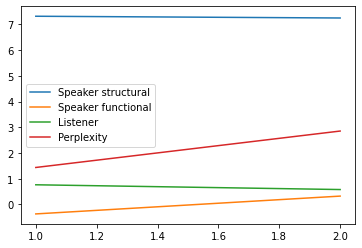

In [24]:
plt.plot(steps, speaker_losses_structural, label="Speaker structural")
plt.plot(steps, speaker_losses_functional, label="Speaker functional")
plt.plot(steps, listener_losses, label="Listener")
plt.plot(steps, perplexities, label="Perplexity")
plt.legend()
plt.show()

### Testing the pretrained sepaker

Below, some initial code for testing the pretrained speaker (basic image captioning model) is provided. Ignore for now.

In [11]:
embedded_imgs = torch.load("../COCO_train_ResNet_features_reshaped_dict.pt")

In [34]:
# transforms like in train
transform_test = transforms.Compose([transforms.Resize((224, 224)), \
                                     transforms.ToTensor(), \
                                     transforms.Normalize((0.485, 0.456, 0.406), \
                                                          (0.229, 0.224, 0.225))])
data_loader_test = get_loader(transform=transform_test,
                         mode='train',
                         batch_size=1,
                         vocab_threshold=25,
                         vocab_from_file=True,
                         download_dir="../../../data/train", 
                              vocab_file="vocab4000.pkl"
#                          vocab_file='../../../data/vocab.pkl'
                        )


Vocabulary successfully loaded from vocab.pkl file!
loading annotations into memory...
Done (t=0.41s)
creating index...
index created!
Obtaining caption lengths...


In [17]:
# extract features for target from file
sanity_check = torch.load("../pretrain_img_IDs_2imgs_512dim.pt").tolist()

saved_target_features = embedded_imgs[str(sanity_check[test_targets.item()])]#torch.index_select(embedded_imgs, 0,  test_targets).squeeze(1)
print(str(sanity_check[test_targets.item()]))
saved_dist_features = embedded_imgs[str(sanity_check[test_dists.item()])]#torch.index_select(embedded_imgs, 0,  test_dists).squeeze(1)
print(str(sanity_check[test_dists.item()]))
# print(saved_target_features.shape)
# # extract features for target from model
# encoder_cnn = EncoderCNN(1048)
# ftr, resnet_ftr = encoder_cnn(orig_image)
# print(resnet_ftr.shape)
# print("features equal?: ", torch.equal(saved_target_features, resnet_ftr))
# print("features equal?: ", torch.equal(embedded_imgs[test_targets.item(), :], resnet_ftr))

603148
462417


In [35]:
len(data_loader_test.dataset.ids)

264048

In [57]:
# create a testing split from the unused part of the train split bc i have extracted features for those
coco_train_keys = coco_train.anns.keys()
val_split = set(coco_train_keys) - set(sanity_check)
# torch.save(list(val_split), "val_split_IDs_from_COCO_train.pt")

In [52]:
sanity_check[138448]

508123

In [18]:
def clean_sentence(output):
    """
    Transform list of indices to a sentence.
    """
    list_string = []
    
    for idx in output:
#         print(idx)
        for i in idx:
#             print("i: ", i)
            try:
                list_string.append(data_loader_test.dataset.vocab.idx2word[i.item()])
            except ValueError:
                for y in i:
                    list_string.append(data_loader_test.dataset.vocab.idx2word[y.item()])
    list_string = list_string[:-1] # Discard <start> and <end> words
    sentence = ' '.join(list_string) # Convert list of string to full string
    sentence = sentence.capitalize()  # Capitalize the first letter of the first word
    return sentence


In [19]:
len(data_loader_test.dataset.ids)

150065

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Target idx in getitem:  138448
Ann_id in getitem:  508123
A person holding a cell phone in their left hand.
IMG  228330


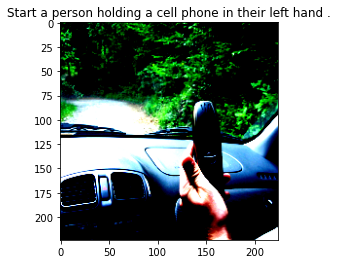

In [46]:
# Visualize sample image, before pre-processing.
# for img, dist, cap in iter(data_loader_test):
orig_image, dist_image, cap = next(iter(data_loader_test))
# print(cap)
#     dist_img, dist, cap_dist = next(iter(data_loader_test))
plt.imshow(orig_image[0].squeeze(0).permute(1,2,0))
plt.title(clean_sentence(cap))
#     plt.imshow(dist_image[0].squeeze(0).permute(1,2,0))
#     plt.title("Distractor")
    
plt.show()
# orig_image.squeeze(0).shape

In [43]:
clean_sentence(cap)

'Start a car dashboard with a led display and a plush rabbit'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


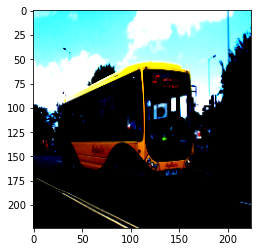

In [54]:
plt.imshow(dist_image[0].squeeze(0).permute(1,2,0))
# plt.title(clean_sentence(cap_dist))

plt.show()

In [50]:
orig_image.shape

torch.Size([1, 3, 224, 224])

In [20]:

# encoder_file = 'speaker-encoder-jointImgs-preprend-vocab6000-1.pkl' 
decoder_file = 'decoder-noEnc-prepend-512dim-4000vocab-rs1234-leon-cont-7.pkl' # 'decoder-noEnc-prepend-1024dim-4000vocab-rs1234-1.pkl'

embed_size = 512
visual_embed_size = 512
hidden_size = 512

# The size of the vocabulary.
vocab_size = len(data_loader_test.dataset.vocab)
print("VOCAB: ", vocab_size)
# Initialize the encoder and decoder, and set each to inference mode.
# encoder = EncoderMLP(2*2048, 2*visual_embed_size)
# encoder.eval()
decoder = DecoderRNN(embed_size, hidden_size, vocab_size, visual_embed_size)
decoder.eval()

# Load the trained weights.
# encoder.load_state_dict(torch.load(os.path.join('./../models', encoder_file)))
decoder.load_state_dict(torch.load(os.path.join('./../models', decoder_file)))

# Move models to GPU if CUDA is available.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# encoder.to(device)
decoder.to(device)

VOCAB:  4054


DecoderRNN(
  (embed): Embedding(4054, 512)
  (lstm): LSTM(1536, 512, batch_first=True)
  (linear): Linear(in_features=512, out_features=4054, bias=True)
  (project): Linear(in_features=2048, out_features=512, bias=True)
)

In [56]:
# test_dists = torch.tensor([0, 1]).long()
# test_target = torch.tensor([2, 3]).long()
# torch.equal(embedded_imgs[0, :], embedded_imgs[1, :])
data_loader_test.dataset.vocab.idx2word[49]
# print(saved_target_features)
# saved_dist_features

'two'

/Users/polinatsvilodub/.local/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


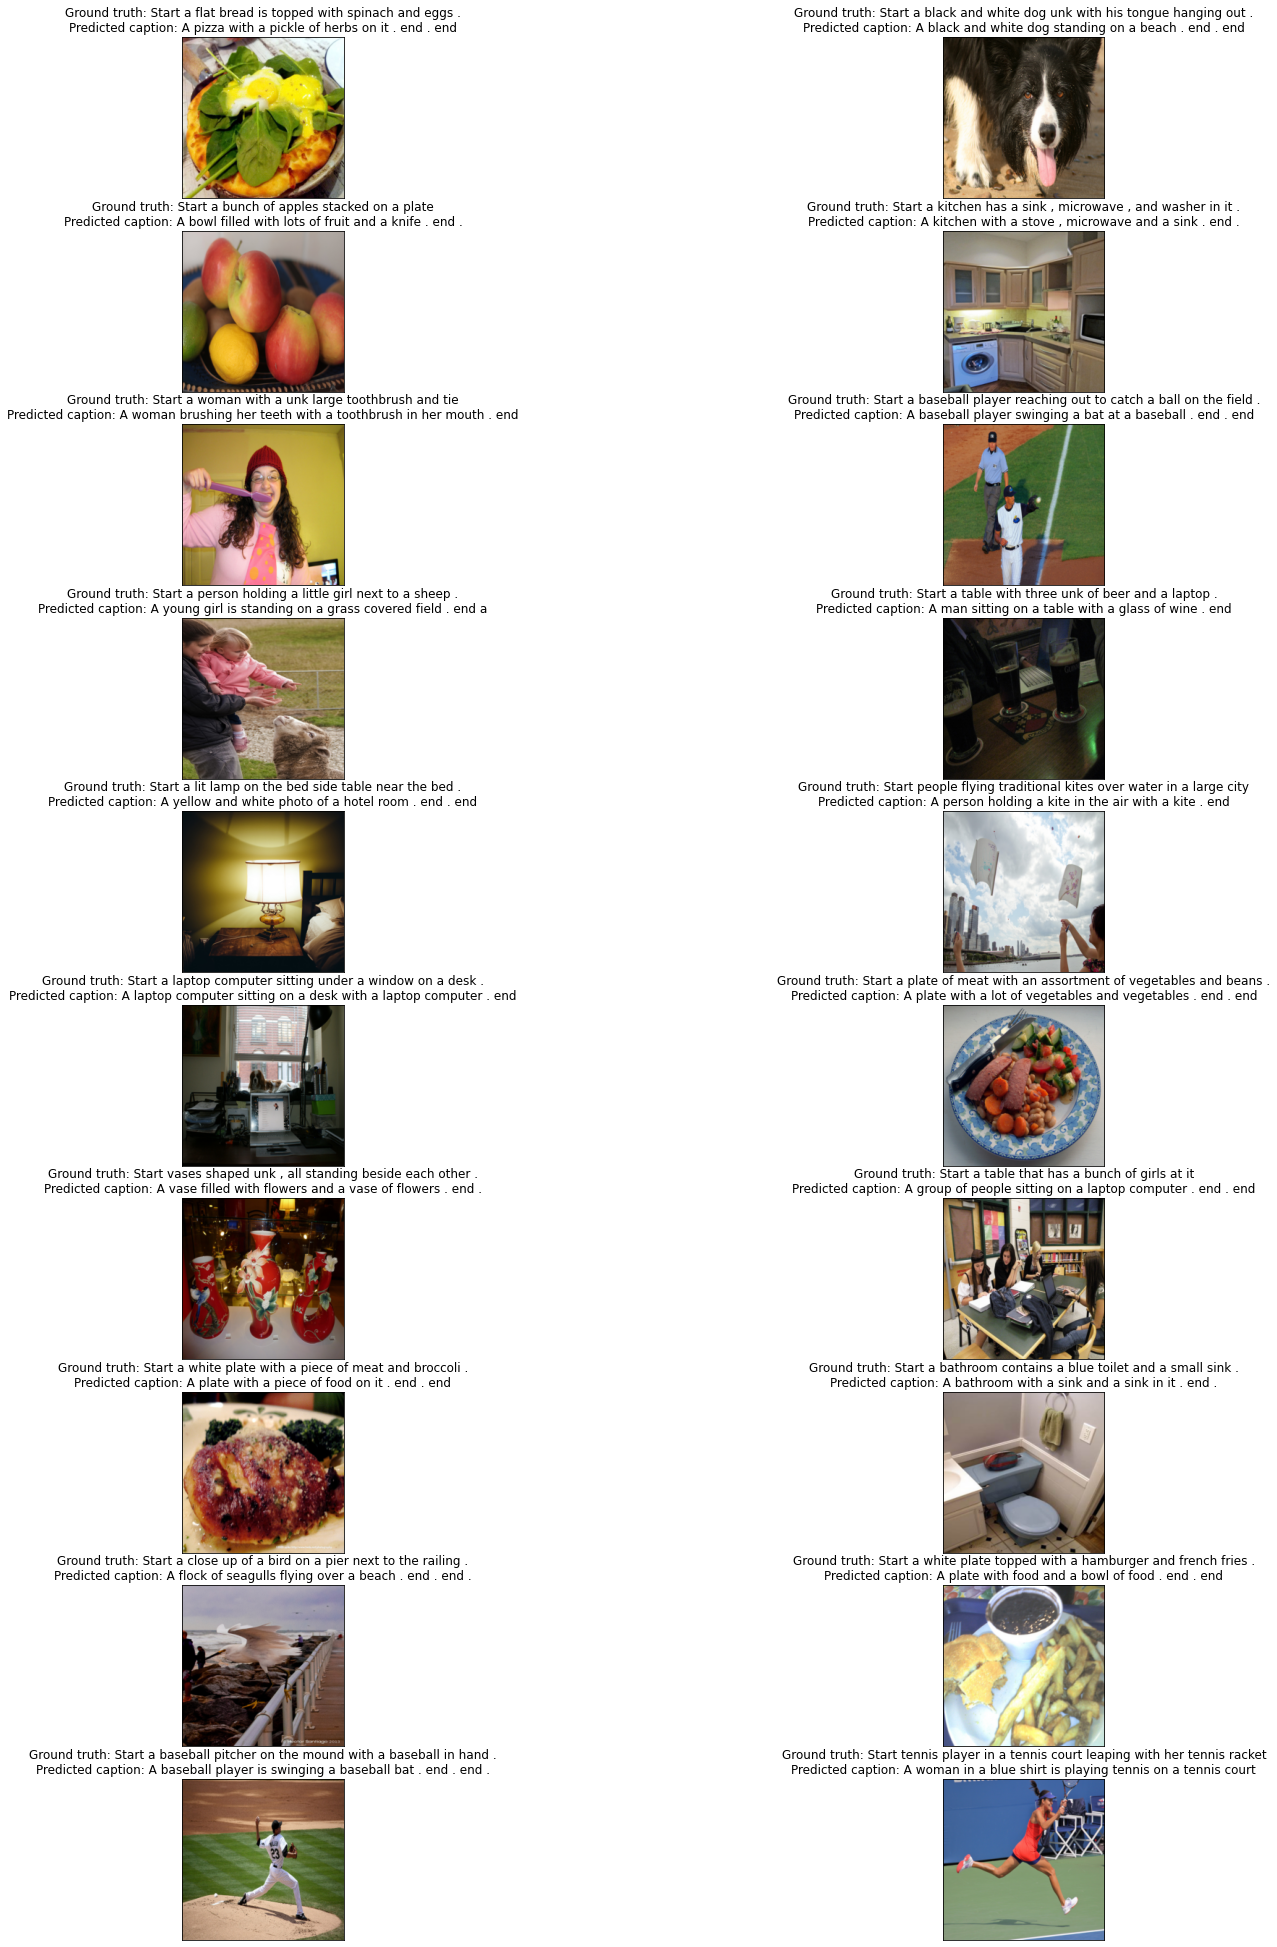

In [44]:
# iterate over 15 image pairs to manually inspect performance of the model
fig, axs = plt.subplots(nrows=10, ncols=2, figsize=(25, 35))

# helper for un-transforming the images for viz purposes
inv_transform = transforms.Compose([
    transforms.Normalize(mean = [ 0., 0., 0. ], 
                         std = [ 1/0.229, 1/0.224, 1/0.225 ]),
    transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                         std = [ 1., 1., 1. ]),
])

for i in range(10):
    test_indices = data_loader_test.dataset.get_func_train_indices() 
    test_targets = torch.tensor([x[0] for x in test_indices]).long()
    test_dists = torch.tensor([x[1] for x in test_indices]).long()
    
    # Create and assign a batch sampler to retrieve a batch with the sampled indices.
    new_sampler = torch.utils.data.sampler.SubsetRandomSampler(indices=test_indices)
    data_loader_test.batch_sampler.sampler = new_sampler        
    
    # get the images
    orig_image, dist_image, cap = next(iter(data_loader_test))            
    
    # retrieve saved features 
    saved_target_features = embedded_imgs[str(data_loader_test.dataset.ids[test_targets.item()])]#torch.index_select(embedded_imgs, 0,  test_targets).squeeze(1)
    saved_dist_features = embedded_imgs[str(data_loader_test.dataset.ids[test_dists.item()])]#torch.index_select(embedded_imgs, 0,  test_dists).squeeze(1)

    # both_images = [saved_target_features, saved_dist_features] #torch.cat((saved_target_features, saved_dist_features), dim=-1)
    both_images = torch.cat((saved_target_features.unsqueeze(0).unsqueeze(0), saved_dist_features.unsqueeze(0).unsqueeze(0)), dim=1)
    
    output, log_p, raw, topk = decoder.sample(both_images, 13) # features_emb.unsqueeze(1)
    # out, hidden_state = decoder(both_images, cap, decoder.init_hidden(1))
    # print("Output", out)
    sentence_t = clean_sentence(output)
#     print('example sentence for target:\n', sentence_t)
    
    both_images_d = torch.cat((saved_dist_features.unsqueeze(0).unsqueeze(1), saved_target_features.unsqueeze(0).unsqueeze(1)), dim=1) #[saved_dist_features, saved_target_features] #torch.cat((saved_dist_features, saved_target_features), dim=-1)
    output2, log_p2, raw2, topk2 = decoder.sample(both_images_d, 13) #both_features_d.unsqueeze(1)
    sentence_d = clean_sentence(output2)
#     print('example sentence for distractor:\n', sentence_d)
    
    # permute the images to get the ground truth caption of the distractor
    test_indices_d = [(test_indices[0][1], test_indices[0][0])]
    
    new_sampler_d = torch.utils.data.sampler.SubsetRandomSampler(indices=test_indices_d)
    data_loader_test.batch_sampler.sampler = new_sampler_d        
    _, _, cap_dist = next(iter(data_loader_test))
    
    # show the image, ground truth caption and predicted caption
    axs[i, 0].imshow(inv_transform(orig_image)[0].squeeze(0).permute(1,2,0))
    axs[i, 0].set_title("Ground truth: " + clean_sentence(cap) + "\nPredicted caption: " + sentence_t)
    axs[i, 0].tick_params(left = False, right = False , labelleft = False , labelbottom = False, bottom = False)
    # distractor 
    axs[i, 1].imshow(inv_transform(dist_image)[0].squeeze(0).permute(1,2,0))
    axs[i, 1].set_title("Ground truth: " + clean_sentence(cap_dist) + "\nPredicted caption: " + sentence_d)
    axs[i, 1].tick_params(left = False, right = False , labelleft = False , labelbottom = False, bottom = False)

fig.show()

In [81]:
# init validation data loader
data_loader_val = get_loader(transform=transform_test,
                         mode='train',
                         batch_size=64,
                         vocab_threshold=25,
                         vocab_from_file=True,
                         download_dir="../../../data/train", 
                              vocab_file="vocab4000.pkl"
#                          vocab_file='../../../data/vocab.pkl'
                        )
# data_loader_val.dataset.ids = val_split
print(len(data_loader_val.dataset.ids))

Vocabulary successfully loaded from vocab.pkl file!
loading annotations into memory...
Done (t=0.45s)
creating index...
index created!
Obtaining caption lengths...
264048


In [91]:
# validate
val_running_loss = 0.0
val_running_ppl = 0.0
losses_list = []
ppl_list = []
counter = 0
total = 0

total_steps = math.ceil(len(data_loader_val.dataset.ids) / data_loader_val.batch_sampler.batch_size)
print("Val total steps: ", total_steps+1)
criterion = nn.CrossEntropyLoss().cuda() if torch.cuda.is_available() else nn.CrossEntropyLoss()

decoder.eval()

with torch.no_grad():
        print("Validating the model...")
        for i in range(1, total_steps+1): 
            
            hidden = decoder.init_hidden(batch_size=64)
             # get val indices
            indices = data_loader_val.dataset.get_func_train_indices()
            # create separate lists for retrieving the image emebddings
            target_inds = [x[0] for x in indices]
            distractor_inds = [x[1] for x in indices]

            new_sampler = torch.utils.data.sampler.SubsetRandomSampler(indices=indices)
            data_loader_val.batch_sampler.sampler = new_sampler

            counter += 1
            # print("Counter: ", counter)
            # Obtain the batch.
            targets, distractors, target_captions = next(iter(data_loader_val))

            # Move batch of images and captions to GPU if CUDA is available.
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            targets = targets.to(device)
            distractors = distractors.to(device)
            target_captions = target_captions.to(device)

            # Pass the inputs through the CNN-RNN model.
            # after retrieving the resnet embeddings
            # target_features = torch.index_select(embedded_imgs, 0, target_inds)
            # distractor_features = torch.index_select(embedded_imgs, 0, distractor_inds)

            # compute val predictions and loss
#             target_features = encoder(targets)#encoder(target_features)
#             distractor_features = encoder(distractors) #encoder(distractor_features)
            test_targets = [str(data_loader_val.dataset.ids[i]) for i in target_inds]
            test_dists = [str(data_loader_val.dataset.ids[i]) for i in distractor_inds]
            target_features = [embedded_imgs[i] for i in test_targets]
            target_features_arr = torch.stack(target_features)
            
            distractor_features = [embedded_imgs[i] for i in test_dists]
            distractor_features_arr = torch.stack(distractor_features)
            
            both_images = torch.cat((target_features_arr.unsqueeze(1), distractor_features_arr.unsqueeze(1)), dim=1)
            outputs, hidden = decoder(both_images, target_captions, hidden)
            
            # The size of the vocabulary.
            vocab_size = len(data_loader_val.dataset.vocab)

            # Calculate the batch loss.
            loss = criterion(outputs.transpose(1,2), target_captions[:, 1:]) 
            losses_list.append(loss)
            ppl = np.exp(loss.item())
            ppl_list.append(ppl)

            val_running_loss += loss.item()
            val_running_ppl += ppl
            
            print("val running loss: ", val_running_loss)
            print("current PPL: ", ppl)
            
        
        val_loss = val_running_loss / counter
        ppl_avg = val_running_ppl / counter
        print("FINAL VAL LOSS ", val_loss)
        print("FINAL AVG PPL ", ppl_avg)


Val total steps:  4127
Validating the model...
reps  torch.Size([64, 12, 1024])
embs  torch.Size([64, 13, 512])
val running loss:  4.511882305145264
current PPL:  91.09312228974268
reps  torch.Size([64, 13, 1024])
embs  torch.Size([64, 14, 512])
val running loss:  9.003695011138916
current PPL:  89.2831433684935
reps  torch.Size([64, 14, 1024])
embs  torch.Size([64, 15, 512])
val running loss:  13.430891513824463
current PPL:  83.69644493391372
reps  torch.Size([64, 10, 1024])
embs  torch.Size([64, 11, 512])
val running loss:  18.309616565704346
current PPL:  131.46294855525025
reps  torch.Size([64, 12, 1024])
embs  torch.Size([64, 13, 512])
val running loss:  23.108072757720947
current PPL:  121.32297349212436
reps  torch.Size([64, 11, 1024])
embs  torch.Size([64, 12, 512])
val running loss:  28.075716495513916
current PPL:  143.6879217621651
reps  torch.Size([64, 15, 1024])
embs  torch.Size([64, 16, 512])
val running loss:  32.51902770996094
current PPL:  85.05611494103412
reps  torc

reps  torch.Size([64, 14, 1024])
embs  torch.Size([64, 15, 512])
val running loss:  290.18032217025757
current PPL:  99.37312665204004
reps  torch.Size([64, 13, 1024])
embs  torch.Size([64, 14, 512])
val running loss:  294.9081082344055
current PPL:  113.04501069628107
reps  torch.Size([64, 11, 1024])
embs  torch.Size([64, 12, 512])
val running loss:  299.699266910553
current PPL:  120.44083977491395
reps  torch.Size([64, 17, 1024])
embs  torch.Size([64, 18, 512])
val running loss:  304.5135803222656
current PPL:  123.26215289996941
reps  torch.Size([64, 13, 1024])
embs  torch.Size([64, 14, 512])
val running loss:  309.31597566604614
current PPL:  121.80182561355659
reps  torch.Size([64, 11, 1024])
embs  torch.Size([64, 12, 512])
val running loss:  313.5433006286621
current PPL:  68.53365665401282
reps  torch.Size([64, 9, 1024])
embs  torch.Size([64, 10, 512])
val running loss:  318.7255277633667
current PPL:  178.07897554029017
reps  torch.Size([64, 15, 1024])
embs  torch.Size([64, 16

reps  torch.Size([64, 12, 1024])
embs  torch.Size([64, 13, 512])
val running loss:  578.2440257072449
current PPL:  83.42255563514297
reps  torch.Size([64, 14, 1024])
embs  torch.Size([64, 15, 512])
val running loss:  582.7654714584351
current PPL:  91.9684654267278
reps  torch.Size([64, 12, 1024])
embs  torch.Size([64, 13, 512])
val running loss:  587.2325792312622
current PPL:  87.1044325419558
reps  torch.Size([64, 10, 1024])
embs  torch.Size([64, 11, 512])
val running loss:  592.3207511901855
current PPL:  162.09327788183856
reps  torch.Size([64, 12, 1024])
embs  torch.Size([64, 13, 512])
val running loss:  596.8967337608337
current PPL:  97.12342289320668
reps  torch.Size([64, 13, 1024])
embs  torch.Size([64, 14, 512])
val running loss:  601.2382760047913
current PPL:  76.82593234932257
reps  torch.Size([64, 10, 1024])
embs  torch.Size([64, 11, 512])
val running loss:  605.9460082054138
current PPL:  110.80060123671001
reps  torch.Size([64, 18, 1024])
embs  torch.Size([64, 19, 512

reps  torch.Size([64, 13, 1024])
embs  torch.Size([64, 14, 512])
val running loss:  862.9480080604553
current PPL:  73.26158470760953
reps  torch.Size([64, 11, 1024])
embs  torch.Size([64, 12, 512])
val running loss:  867.5019583702087
current PPL:  95.00697498056529
reps  torch.Size([64, 10, 1024])
embs  torch.Size([64, 11, 512])
val running loss:  872.4704251289368
current PPL:  143.80622860771769
reps  torch.Size([64, 16, 1024])
embs  torch.Size([64, 17, 512])
val running loss:  877.2444081306458
current PPL:  118.38985109926682
reps  torch.Size([64, 12, 1024])
embs  torch.Size([64, 13, 512])
val running loss:  881.6007614135742
current PPL:  77.9722725160913
reps  torch.Size([64, 12, 1024])
embs  torch.Size([64, 13, 512])
val running loss:  886.3144111633301
current PPL:  111.45821304463334
reps  torch.Size([64, 14, 1024])
embs  torch.Size([64, 15, 512])
val running loss:  890.6830611228943
current PPL:  78.93699160099777
reps  torch.Size([64, 14, 1024])
embs  torch.Size([64, 15, 5

reps  torch.Size([64, 11, 1024])
embs  torch.Size([64, 12, 512])
val running loss:  1150.5998539924622
current PPL:  118.07886727487693
reps  torch.Size([64, 17, 1024])
embs  torch.Size([64, 18, 512])
val running loss:  1155.295367717743
current PPL:  109.45502401388987
reps  torch.Size([64, 10, 1024])
embs  torch.Size([64, 11, 512])
val running loss:  1160.1176915168762
current PPL:  124.25349571812723
reps  torch.Size([64, 15, 1024])
embs  torch.Size([64, 16, 512])
val running loss:  1164.811912059784
current PPL:  109.31357018870337
reps  torch.Size([64, 15, 1024])
embs  torch.Size([64, 16, 512])
val running loss:  1169.5113878250122
current PPL:  109.88954942658735
reps  torch.Size([64, 14, 1024])
embs  torch.Size([64, 15, 512])
val running loss:  1174.1159362792969
current PPL:  99.93784615316832
reps  torch.Size([64, 10, 1024])
embs  torch.Size([64, 11, 512])
val running loss:  1179.4457573890686
current PPL:  206.40104772297502
reps  torch.Size([64, 11, 1024])
embs  torch.Size([

reps  torch.Size([64, 11, 1024])
embs  torch.Size([64, 12, 512])
val running loss:  1440.783761024475
current PPL:  118.74331987189225
reps  torch.Size([64, 10, 1024])
embs  torch.Size([64, 11, 512])
val running loss:  1446.0284571647644
current PPL:  189.55820737555734
reps  torch.Size([64, 12, 1024])
embs  torch.Size([64, 13, 512])
val running loss:  1450.254286289215
current PPL:  68.43121802968606
reps  torch.Size([64, 12, 1024])
embs  torch.Size([64, 13, 512])
val running loss:  1454.3886995315552
current PPL:  62.452935579236936
reps  torch.Size([64, 12, 1024])
embs  torch.Size([64, 13, 512])
val running loss:  1458.9653849601746
current PPL:  97.19171086073648
reps  torch.Size([64, 9, 1024])
embs  torch.Size([64, 10, 512])
val running loss:  1464.5773968696594
current PPL:  273.69433267271916
reps  torch.Size([64, 12, 1024])
embs  torch.Size([64, 13, 512])
val running loss:  1469.0492420196533
current PPL:  87.51805806829066
reps  torch.Size([64, 10, 1024])
embs  torch.Size([64,

reps  torch.Size([64, 13, 1024])
embs  torch.Size([64, 14, 512])
val running loss:  1728.9471926689148
current PPL:  105.39149518277684
reps  torch.Size([64, 12, 1024])
embs  torch.Size([64, 13, 512])
val running loss:  1733.563060283661
current PPL:  101.07548508225062
reps  torch.Size([64, 11, 1024])
embs  torch.Size([64, 12, 512])
val running loss:  1738.3905639648438
current PPL:  124.89878398593056
reps  torch.Size([64, 12, 1024])
embs  torch.Size([64, 13, 512])
val running loss:  1742.8245573043823
current PPL:  84.26725366474801
reps  torch.Size([64, 22, 1024])
embs  torch.Size([64, 23, 512])
val running loss:  1748.0455737113953
current PPL:  185.12224803087864
reps  torch.Size([64, 11, 1024])
embs  torch.Size([64, 12, 512])
val running loss:  1752.777011871338
current PPL:  113.45861670912812
reps  torch.Size([64, 12, 1024])
embs  torch.Size([64, 13, 512])
val running loss:  1757.3450474739075
current PPL:  96.35464492474156
reps  torch.Size([64, 11, 1024])
embs  torch.Size([6

reps  torch.Size([64, 9, 1024])
embs  torch.Size([64, 10, 512])
val running loss:  2015.7864451408386
current PPL:  240.6851176440946
reps  torch.Size([64, 10, 1024])
embs  torch.Size([64, 11, 512])
val running loss:  2020.6650862693787
current PPL:  131.45191620848396
reps  torch.Size([64, 13, 1024])
embs  torch.Size([64, 14, 512])
val running loss:  2025.0534582138062
current PPL:  80.50923871034637
reps  torch.Size([64, 18, 1024])
embs  torch.Size([64, 19, 512])
val running loss:  2029.9702100753784
current PPL:  136.5583316684261
reps  torch.Size([64, 11, 1024])
embs  torch.Size([64, 12, 512])
val running loss:  2034.5885224342346
current PPL:  101.32289107803308
reps  torch.Size([64, 12, 1024])
embs  torch.Size([64, 13, 512])
val running loss:  2039.1638913154602
current PPL:  97.06383756120375
reps  torch.Size([64, 12, 1024])
embs  torch.Size([64, 13, 512])
val running loss:  2043.6917152404785
current PPL:  92.55693095870195
reps  torch.Size([64, 17, 1024])
embs  torch.Size([64,

reps  torch.Size([64, 11, 1024])
embs  torch.Size([64, 12, 512])
val running loss:  2304.2699341773987
current PPL:  108.38280187724389
reps  torch.Size([64, 13, 1024])
embs  torch.Size([64, 14, 512])
val running loss:  2308.7408809661865
current PPL:  87.43947054536916
reps  torch.Size([64, 14, 1024])
embs  torch.Size([64, 15, 512])
val running loss:  2313.4697103500366
current PPL:  113.16301433022412
reps  torch.Size([64, 17, 1024])
embs  torch.Size([64, 18, 512])
val running loss:  2318.019160270691
current PPL:  94.58036729633287
reps  torch.Size([64, 17, 1024])
embs  torch.Size([64, 18, 512])
val running loss:  2322.9490208625793
current PPL:  138.36022245807928
reps  torch.Size([64, 18, 1024])
embs  torch.Size([64, 19, 512])
val running loss:  2327.9967107772827
current PPL:  155.66245527133694
reps  torch.Size([64, 10, 1024])
embs  torch.Size([64, 11, 512])
val running loss:  2332.979455947876
current PPL:  145.87428229480233
reps  torch.Size([64, 12, 1024])
embs  torch.Size([6

reps  torch.Size([64, 16, 1024])
embs  torch.Size([64, 17, 512])
val running loss:  2593.9648303985596
current PPL:  77.11360264474591
reps  torch.Size([64, 20, 1024])
embs  torch.Size([64, 21, 512])
val running loss:  2599.331521511078
current PPL:  214.15308559328093
reps  torch.Size([64, 13, 1024])
embs  torch.Size([64, 14, 512])
val running loss:  2603.6705751419067
current PPL:  76.63498002723459
reps  torch.Size([64, 12, 1024])
embs  torch.Size([64, 13, 512])
val running loss:  2608.4421153068542
current PPL:  118.1009969741973
reps  torch.Size([64, 12, 1024])
embs  torch.Size([64, 13, 512])
val running loss:  2612.7549896240234
current PPL:  74.6547623130848
reps  torch.Size([64, 11, 1024])
embs  torch.Size([64, 12, 512])
val running loss:  2617.711263656616
current PPL:  142.06348463576012
reps  torch.Size([64, 13, 1024])
embs  torch.Size([64, 14, 512])
val running loss:  2622.3577489852905
current PPL:  104.21804893578309
reps  torch.Size([64, 11, 1024])
embs  torch.Size([64, 

reps  torch.Size([64, 17, 1024])
embs  torch.Size([64, 18, 512])
val running loss:  2885.1763129234314
current PPL:  156.9942353835255
reps  torch.Size([64, 12, 1024])
embs  torch.Size([64, 13, 512])
val running loss:  2889.498956680298
current PPL:  75.38767173965648
reps  torch.Size([64, 26, 1024])
embs  torch.Size([64, 27, 512])
val running loss:  2896.346372127533
current PPL:  941.4445464714795
reps  torch.Size([64, 11, 1024])
embs  torch.Size([64, 12, 512])
val running loss:  2900.7816371917725
current PPL:  84.37448658363648
reps  torch.Size([64, 15, 1024])
embs  torch.Size([64, 16, 512])
val running loss:  2904.994801044464
current PPL:  67.56998345397174
reps  torch.Size([64, 11, 1024])
embs  torch.Size([64, 12, 512])
val running loss:  2909.448217868805
current PPL:  85.92001663241804
reps  torch.Size([64, 13, 1024])
embs  torch.Size([64, 14, 512])
val running loss:  2914.035090446472
current PPL:  98.1868776553688
reps  torch.Size([64, 11, 1024])
embs  torch.Size([64, 12, 51

reps  torch.Size([64, 11, 1024])
embs  torch.Size([64, 12, 512])
val running loss:  3176.7148175239563
current PPL:  91.11771071510593
reps  torch.Size([64, 13, 1024])
embs  torch.Size([64, 14, 512])
val running loss:  3181.1544971466064
current PPL:  84.74778605293575
reps  torch.Size([64, 10, 1024])
embs  torch.Size([64, 11, 512])
val running loss:  3186.4695019721985
current PPL:  203.3654944853915
reps  torch.Size([64, 12, 1024])
embs  torch.Size([64, 13, 512])
val running loss:  3191.0835938453674
current PPL:  100.89616040522344
reps  torch.Size([64, 16, 1024])
embs  torch.Size([64, 17, 512])
val running loss:  3195.451591491699
current PPL:  78.88551674753816
reps  torch.Size([64, 10, 1024])
embs  torch.Size([64, 11, 512])
val running loss:  3200.5119228363037
current PPL:  157.64274174249744
reps  torch.Size([64, 11, 1024])
embs  torch.Size([64, 12, 512])
val running loss:  3205.5683732032776
current PPL:  157.03211946030683
reps  torch.Size([64, 12, 1024])
embs  torch.Size([64

reps  torch.Size([64, 12, 1024])
embs  torch.Size([64, 13, 512])
val running loss:  3458.1012663841248
current PPL:  83.00746392395757
reps  torch.Size([64, 12, 1024])
embs  torch.Size([64, 13, 512])
val running loss:  3462.3460569381714
current PPL:  69.74115161211917
reps  torch.Size([64, 11, 1024])
embs  torch.Size([64, 12, 512])
val running loss:  3467.166058063507
current PPL:  123.9652302822438
reps  torch.Size([64, 11, 1024])
embs  torch.Size([64, 12, 512])
val running loss:  3471.9666047096252
current PPL:  121.57685887508825
reps  torch.Size([64, 11, 1024])
embs  torch.Size([64, 12, 512])
val running loss:  3476.5958733558655
current PPL:  102.43911747387025
reps  torch.Size([64, 10, 1024])
embs  torch.Size([64, 11, 512])
val running loss:  3481.657298564911
current PPL:  157.81527587933329
reps  torch.Size([64, 11, 1024])
embs  torch.Size([64, 12, 512])
val running loss:  3486.2113704681396
current PPL:  95.01852791120115
reps  torch.Size([64, 12, 1024])
embs  torch.Size([64,

reps  torch.Size([64, 14, 1024])
embs  torch.Size([64, 15, 512])
val running loss:  3744.7461981773376
current PPL:  91.92725192112285
reps  torch.Size([64, 17, 1024])
embs  torch.Size([64, 18, 512])
val running loss:  3749.6268367767334
current PPL:  131.7147499940615
reps  torch.Size([64, 12, 1024])
embs  torch.Size([64, 13, 512])
val running loss:  3754.358551979065
current PPL:  113.49005390986184
reps  torch.Size([64, 15, 1024])
embs  torch.Size([64, 16, 512])
val running loss:  3758.7651629447937
current PPL:  81.99112139479273
reps  torch.Size([64, 12, 1024])
embs  torch.Size([64, 13, 512])
val running loss:  3763.1085023880005
current PPL:  76.96412800263045
reps  torch.Size([64, 17, 1024])
embs  torch.Size([64, 18, 512])
val running loss:  3767.861129283905
current PPL:  115.88831155969444
reps  torch.Size([64, 13, 1024])
embs  torch.Size([64, 14, 512])
val running loss:  3772.148129940033
current PPL:  72.74794484708194
reps  torch.Size([64, 15, 1024])
embs  torch.Size([64, 1

reps  torch.Size([64, 23, 1024])
embs  torch.Size([64, 24, 512])
val running loss:  4031.740933895111
current PPL:  144.52549181157377
reps  torch.Size([64, 14, 1024])
embs  torch.Size([64, 15, 512])
val running loss:  4036.011944293976
current PPL:  71.59393751938147
reps  torch.Size([64, 11, 1024])
embs  torch.Size([64, 12, 512])
val running loss:  4040.481168270111
current PPL:  87.2889584085126
reps  torch.Size([64, 16, 1024])
embs  torch.Size([64, 17, 512])
val running loss:  4045.0572023391724
current PPL:  97.12842472415123
reps  torch.Size([64, 12, 1024])
embs  torch.Size([64, 13, 512])
val running loss:  4049.404504299164
current PPL:  77.26970467817588
reps  torch.Size([64, 10, 1024])
embs  torch.Size([64, 11, 512])
val running loss:  4054.167856693268
current PPL:  117.13796101358487
reps  torch.Size([64, 8, 1024])
embs  torch.Size([64, 9, 512])
val running loss:  4059.685933113098
current PPL:  249.15530573138255
reps  torch.Size([64, 9, 1024])
embs  torch.Size([64, 10, 512

reps  torch.Size([64, 10, 1024])
embs  torch.Size([64, 11, 512])
val running loss:  4318.676758766174
current PPL:  121.54358729171504
reps  torch.Size([64, 14, 1024])
embs  torch.Size([64, 15, 512])
val running loss:  4323.11717748642
current PPL:  84.81044609089653
reps  torch.Size([64, 11, 1024])
embs  torch.Size([64, 12, 512])
val running loss:  4327.873908042908
current PPL:  116.36485497339116
reps  torch.Size([64, 10, 1024])
embs  torch.Size([64, 11, 512])
val running loss:  4332.739928245544
current PPL:  129.8032967498673
reps  torch.Size([64, 14, 1024])
embs  torch.Size([64, 15, 512])
val running loss:  4337.4511733055115
current PPL:  111.19051261508854
reps  torch.Size([64, 14, 1024])
embs  torch.Size([64, 15, 512])
val running loss:  4342.310544490814
current PPL:  128.94309529604016
reps  torch.Size([64, 10, 1024])
embs  torch.Size([64, 11, 512])
val running loss:  4347.5191469192505
current PPL:  182.83834987146122
reps  torch.Size([64, 15, 1024])
embs  torch.Size([64, 1

reps  torch.Size([64, 13, 1024])
embs  torch.Size([64, 14, 512])
val running loss:  4606.427128314972
current PPL:  99.00473099997667
reps  torch.Size([64, 12, 1024])
embs  torch.Size([64, 13, 512])
val running loss:  4611.018502235413
current PPL:  98.6298466772959
reps  torch.Size([64, 15, 1024])
embs  torch.Size([64, 16, 512])
val running loss:  4615.7689843177795
current PPL:  115.64001910590339
reps  torch.Size([64, 11, 1024])
embs  torch.Size([64, 12, 512])
val running loss:  4620.864924430847
current PPL:  163.35734683481726
reps  torch.Size([64, 11, 1024])
embs  torch.Size([64, 12, 512])
val running loss:  4625.424763679504
current PPL:  95.56811589225654
reps  torch.Size([64, 9, 1024])
embs  torch.Size([64, 10, 512])
val running loss:  4630.8749742507935
current PPL:  232.80718325533897
reps  torch.Size([64, 18, 1024])
embs  torch.Size([64, 19, 512])
val running loss:  4635.582476139069
current PPL:  110.77508542856013
reps  torch.Size([64, 16, 1024])
embs  torch.Size([64, 17,

reps  torch.Size([64, 10, 1024])
embs  torch.Size([64, 11, 512])
val running loss:  4890.586168766022
current PPL:  114.44263360320765
reps  torch.Size([64, 21, 1024])
embs  torch.Size([64, 22, 512])
val running loss:  4895.705592632294
current PPL:  167.23898983726147
reps  torch.Size([64, 10, 1024])
embs  torch.Size([64, 11, 512])
val running loss:  4900.626976490021
current PPL:  137.19233655615113
reps  torch.Size([64, 14, 1024])
embs  torch.Size([64, 15, 512])
val running loss:  4905.258116722107
current PPL:  102.63102060177762
reps  torch.Size([64, 11, 1024])
embs  torch.Size([64, 12, 512])
val running loss:  4910.0647740364075
current PPL:  122.3220492049494
reps  torch.Size([64, 13, 1024])
embs  torch.Size([64, 14, 512])
val running loss:  4914.593004703522
current PPL:  92.59458541610188
reps  torch.Size([64, 20, 1024])
embs  torch.Size([64, 21, 512])
val running loss:  4919.637335777283
current PPL:  155.14048693841235
reps  torch.Size([64, 12, 1024])
embs  torch.Size([64, 1

reps  torch.Size([64, 12, 1024])
embs  torch.Size([64, 13, 512])
val running loss:  5177.6992564201355
current PPL:  89.35405642630596
reps  torch.Size([64, 12, 1024])
embs  torch.Size([64, 13, 512])
val running loss:  5182.196250915527
current PPL:  89.7469905555619
reps  torch.Size([64, 10, 1024])
embs  torch.Size([64, 11, 512])
val running loss:  5187.177375793457
current PPL:  145.63811464741764
reps  torch.Size([64, 16, 1024])
embs  torch.Size([64, 17, 512])
val running loss:  5191.7682638168335
current PPL:  98.5819343655205
reps  torch.Size([64, 10, 1024])
embs  torch.Size([64, 11, 512])
val running loss:  5196.645299911499
current PPL:  131.24110065840688
reps  torch.Size([64, 15, 1024])
embs  torch.Size([64, 16, 512])
val running loss:  5201.322126865387
current PPL:  107.42865511475352
reps  torch.Size([64, 11, 1024])
embs  torch.Size([64, 12, 512])
val running loss:  5206.142194271088
current PPL:  123.97344701525402
reps  torch.Size([64, 12, 1024])
embs  torch.Size([64, 13,

reps  torch.Size([64, 19, 1024])
embs  torch.Size([64, 20, 512])
val running loss:  5471.011451721191
current PPL:  187.83067025874124
reps  torch.Size([64, 13, 1024])
embs  torch.Size([64, 14, 512])
val running loss:  5475.496670722961
current PPL:  88.69637334885581
reps  torch.Size([64, 12, 1024])
embs  torch.Size([64, 13, 512])
val running loss:  5480.124084472656
current PPL:  102.2492796279657
reps  torch.Size([64, 12, 1024])
embs  torch.Size([64, 13, 512])
val running loss:  5484.414452075958
current PPL:  72.9932961450521
reps  torch.Size([64, 11, 1024])
embs  torch.Size([64, 12, 512])
val running loss:  5489.351779937744
current PPL:  139.39726269312516
reps  torch.Size([64, 10, 1024])
embs  torch.Size([64, 11, 512])
val running loss:  5493.898013591766
current PPL:  94.27666028012366
reps  torch.Size([64, 11, 1024])
embs  torch.Size([64, 12, 512])
val running loss:  5498.916346549988
current PPL:  151.1591050961697
reps  torch.Size([64, 11, 1024])
embs  torch.Size([64, 12, 51

reps  torch.Size([64, 14, 1024])
embs  torch.Size([64, 15, 512])
val running loss:  5760.891756057739
current PPL:  120.64701985667972
reps  torch.Size([64, 10, 1024])
embs  torch.Size([64, 11, 512])
val running loss:  5765.918386936188
current PPL:  152.4186297824457
reps  torch.Size([64, 10, 1024])
embs  torch.Size([64, 11, 512])
val running loss:  5770.851709365845
current PPL:  138.84003313602997
reps  torch.Size([64, 13, 1024])
embs  torch.Size([64, 14, 512])
val running loss:  5775.301824092865
current PPL:  85.63676828988508
reps  torch.Size([64, 11, 1024])
embs  torch.Size([64, 12, 512])
val running loss:  5779.8335337638855
current PPL:  92.91728334866578
reps  torch.Size([64, 12, 1024])
embs  torch.Size([64, 13, 512])
val running loss:  5784.338864803314
current PPL:  90.49829759542841
reps  torch.Size([64, 15, 1024])
embs  torch.Size([64, 16, 512])
val running loss:  5788.586706638336
current PPL:  69.9542764477549
reps  torch.Size([64, 10, 1024])
embs  torch.Size([64, 11, 5

reps  torch.Size([64, 12, 1024])
embs  torch.Size([64, 13, 512])
val running loss:  6046.794546127319
current PPL:  83.74558804244272
reps  torch.Size([64, 26, 1024])
embs  torch.Size([64, 27, 512])
val running loss:  6052.342918395996
current PPL:  256.8191828703336
reps  torch.Size([64, 10, 1024])
embs  torch.Size([64, 11, 512])
val running loss:  6057.223360538483
current PPL:  131.68887626300412
reps  torch.Size([64, 12, 1024])
embs  torch.Size([64, 13, 512])
val running loss:  6062.051997661591
current PPL:  125.04042976255445
reps  torch.Size([64, 13, 1024])
embs  torch.Size([64, 14, 512])
val running loss:  6066.46565580368
current PPL:  82.57096802832243
reps  torch.Size([64, 13, 1024])
embs  torch.Size([64, 14, 512])
val running loss:  6071.03543138504
current PPL:  96.52244590599491
reps  torch.Size([64, 16, 1024])
embs  torch.Size([64, 17, 512])
val running loss:  6075.807555198669
current PPL:  118.16994658459906
reps  torch.Size([64, 12, 1024])
embs  torch.Size([64, 13, 51

reps  torch.Size([64, 13, 1024])
embs  torch.Size([64, 14, 512])
val running loss:  6333.113760709763
current PPL:  87.22155580274912
reps  torch.Size([64, 10, 1024])
embs  torch.Size([64, 11, 512])
val running loss:  6338.0181176662445
current PPL:  134.87615088028792
reps  torch.Size([64, 11, 1024])
embs  torch.Size([64, 12, 512])
val running loss:  6342.697586297989
current PPL:  107.712822187796
reps  torch.Size([64, 12, 1024])
embs  torch.Size([64, 13, 512])
val running loss:  6347.244267702103
current PPL:  94.31888211510524
reps  torch.Size([64, 13, 1024])
embs  torch.Size([64, 14, 512])
val running loss:  6351.7355806827545
current PPL:  89.23853746543533
reps  torch.Size([64, 22, 1024])
embs  torch.Size([64, 23, 512])
val running loss:  6356.826267004013
current PPL:  162.50135192254598
reps  torch.Size([64, 10, 1024])
embs  torch.Size([64, 11, 512])
val running loss:  6361.571455717087
current PPL:  115.02951102758257
reps  torch.Size([64, 20, 1024])
embs  torch.Size([64, 21,

reps  torch.Size([64, 12, 1024])
embs  torch.Size([64, 13, 512])
val running loss:  6621.691121578217
current PPL:  112.35290762822349
reps  torch.Size([64, 13, 1024])
embs  torch.Size([64, 14, 512])
val running loss:  6626.041433811188
current PPL:  77.50265803300198
reps  torch.Size([64, 11, 1024])
embs  torch.Size([64, 12, 512])
val running loss:  6630.711461544037
current PPL:  106.70070150587485
reps  torch.Size([64, 11, 1024])
embs  torch.Size([64, 12, 512])
val running loss:  6635.351435661316
current PPL:  103.54166760850956
reps  torch.Size([64, 11, 1024])
embs  torch.Size([64, 12, 512])
val running loss:  6639.819362163544
current PPL:  87.17577670359958
reps  torch.Size([64, 12, 1024])
embs  torch.Size([64, 13, 512])
val running loss:  6644.596158981323
current PPL:  118.72344748420949
reps  torch.Size([64, 10, 1024])
embs  torch.Size([64, 11, 512])
val running loss:  6649.388676166534
current PPL:  120.60457093734325
reps  torch.Size([64, 12, 1024])
embs  torch.Size([64, 13

reps  torch.Size([64, 10, 1024])
embs  torch.Size([64, 11, 512])
val running loss:  6910.647281169891
current PPL:  154.38414889549435
reps  torch.Size([64, 12, 1024])
embs  torch.Size([64, 13, 512])
val running loss:  6915.201456069946
current PPL:  95.02831502201555
reps  torch.Size([64, 13, 1024])
embs  torch.Size([64, 14, 512])
val running loss:  6919.478862762451
current PPL:  72.05334104023781
reps  torch.Size([64, 12, 1024])
embs  torch.Size([64, 13, 512])
val running loss:  6924.243619441986
current PPL:  117.30257169878477
reps  torch.Size([64, 15, 1024])
embs  torch.Size([64, 16, 512])
val running loss:  6928.370589256287
current PPL:  61.989797453380994
reps  torch.Size([64, 13, 1024])
embs  torch.Size([64, 14, 512])
val running loss:  6932.515315532684
current PPL:  63.10034748322569
reps  torch.Size([64, 11, 1024])
embs  torch.Size([64, 12, 512])
val running loss:  6937.156725883484
current PPL:  103.69048446459553
reps  torch.Size([64, 10, 1024])
embs  torch.Size([64, 11,

reps  torch.Size([64, 14, 1024])
embs  torch.Size([64, 15, 512])
val running loss:  7197.069046974182
current PPL:  92.83017349186471
reps  torch.Size([64, 10, 1024])
embs  torch.Size([64, 11, 512])
val running loss:  7202.2146191596985
current PPL:  171.6696834809001
reps  torch.Size([64, 12, 1024])
embs  torch.Size([64, 13, 512])
val running loss:  7206.784268379211
current PPL:  96.51024992203038
reps  torch.Size([64, 10, 1024])
embs  torch.Size([64, 11, 512])
val running loss:  7211.423264026642
current PPL:  103.44040475807954
reps  torch.Size([64, 10, 1024])
embs  torch.Size([64, 11, 512])
val running loss:  7216.004437923431
current PPL:  97.62893325670676
reps  torch.Size([64, 11, 1024])
embs  torch.Size([64, 12, 512])
val running loss:  7220.9945521354675
current PPL:  146.95320636218875
reps  torch.Size([64, 14, 1024])
embs  torch.Size([64, 15, 512])
val running loss:  7225.673160076141
current PPL:  107.62015460835417
reps  torch.Size([64, 13, 1024])
embs  torch.Size([64, 14

reps  torch.Size([64, 12, 1024])
embs  torch.Size([64, 13, 512])
val running loss:  7488.364547729492
current PPL:  88.66791423751786
reps  torch.Size([64, 19, 1024])
embs  torch.Size([64, 20, 512])
val running loss:  7493.368972301483
current PPL:  149.07127868450925
reps  torch.Size([64, 13, 1024])
embs  torch.Size([64, 14, 512])
val running loss:  7497.896773338318
current PPL:  92.55481252291696
reps  torch.Size([64, 14, 1024])
embs  torch.Size([64, 15, 512])
val running loss:  7502.725346088409
current PPL:  125.03238079199505
reps  torch.Size([64, 11, 1024])
embs  torch.Size([64, 12, 512])
val running loss:  7507.626634597778
current PPL:  134.4629248498347
reps  torch.Size([64, 10, 1024])
embs  torch.Size([64, 11, 512])
val running loss:  7512.295729637146
current PPL:  106.60122885307318
reps  torch.Size([64, 13, 1024])
embs  torch.Size([64, 14, 512])
val running loss:  7516.924045562744
current PPL:  102.34156808813074
reps  torch.Size([64, 12, 1024])
embs  torch.Size([64, 13,

reps  torch.Size([64, 12, 1024])
embs  torch.Size([64, 13, 512])
val running loss:  7775.04016494751
current PPL:  84.1824325103602
reps  torch.Size([64, 10, 1024])
embs  torch.Size([64, 11, 512])
val running loss:  7780.106333732605
current PPL:  158.56566299439137
reps  torch.Size([64, 12, 1024])
embs  torch.Size([64, 13, 512])
val running loss:  7784.593298435211
current PPL:  88.8513459104862
reps  torch.Size([64, 15, 1024])
embs  torch.Size([64, 16, 512])
val running loss:  7789.339603900909
current PPL:  115.15804229137402
reps  torch.Size([64, 11, 1024])
embs  torch.Size([64, 12, 512])
val running loss:  7793.938513278961
current PPL:  99.37587500840515
reps  torch.Size([64, 9, 1024])
embs  torch.Size([64, 10, 512])
val running loss:  7799.38102722168
current PPL:  231.02223070707828
reps  torch.Size([64, 13, 1024])
embs  torch.Size([64, 14, 512])
val running loss:  7803.799690723419
current PPL:  82.98530149889625
reps  torch.Size([64, 14, 1024])
embs  torch.Size([64, 15, 512])

reps  torch.Size([64, 11, 1024])
embs  torch.Size([64, 12, 512])
val running loss:  8064.875725269318
current PPL:  97.0976768026042
reps  torch.Size([64, 12, 1024])
embs  torch.Size([64, 13, 512])
val running loss:  8069.34738445282
current PPL:  87.50178415531953
reps  torch.Size([64, 15, 1024])
embs  torch.Size([64, 16, 512])
val running loss:  8073.717323303223
current PPL:  79.03879836110718
reps  torch.Size([64, 14, 1024])
embs  torch.Size([64, 15, 512])
val running loss:  8078.319134712219
current PPL:  99.66468573899544
reps  torch.Size([64, 10, 1024])
embs  torch.Size([64, 11, 512])
val running loss:  8083.1727476119995
current PPL:  128.20273777788574
reps  torch.Size([64, 11, 1024])
embs  torch.Size([64, 12, 512])
val running loss:  8087.671619415283
current PPL:  89.915631535194
reps  torch.Size([64, 16, 1024])
embs  torch.Size([64, 17, 512])
val running loss:  8092.533148765564
current PPL:  129.22167627219133
reps  torch.Size([64, 14, 1024])
embs  torch.Size([64, 15, 512]

reps  torch.Size([64, 12, 1024])
embs  torch.Size([64, 13, 512])
val running loss:  8355.404574394226
current PPL:  118.5594999324375
reps  torch.Size([64, 22, 1024])
embs  torch.Size([64, 23, 512])
val running loss:  8360.605324745178
current PPL:  181.4083107177489
reps  torch.Size([64, 13, 1024])
embs  torch.Size([64, 14, 512])
val running loss:  8365.47215127945
current PPL:  129.90800346279627
reps  torch.Size([64, 11, 1024])
embs  torch.Size([64, 12, 512])
val running loss:  8370.168060779572
current PPL:  109.4983521321734
reps  torch.Size([64, 12, 1024])
embs  torch.Size([64, 13, 512])
val running loss:  8374.604787349701
current PPL:  84.49789054858003
reps  torch.Size([64, 10, 1024])
embs  torch.Size([64, 11, 512])
val running loss:  8379.758862495422
current PPL:  173.13560748245897
reps  torch.Size([64, 15, 1024])
embs  torch.Size([64, 16, 512])
val running loss:  8384.314571857452
current PPL:  95.174244290798
reps  torch.Size([64, 13, 1024])
embs  torch.Size([64, 14, 512]

reps  torch.Size([64, 11, 1024])
embs  torch.Size([64, 12, 512])
val running loss:  8650.035170555115
current PPL:  116.80152331221589
reps  torch.Size([64, 19, 1024])
embs  torch.Size([64, 20, 512])
val running loss:  8655.055648803711
current PPL:  151.48373335582738
reps  torch.Size([64, 11, 1024])
embs  torch.Size([64, 12, 512])
val running loss:  8659.833190441132
current PPL:  118.81190797922397
reps  torch.Size([64, 13, 1024])
embs  torch.Size([64, 14, 512])
val running loss:  8664.048007011414
current PPL:  67.68174988793967
reps  torch.Size([64, 15, 1024])
embs  torch.Size([64, 16, 512])
val running loss:  8668.852251052856
current PPL:  122.02720863217795
reps  torch.Size([64, 26, 1024])
embs  torch.Size([64, 27, 512])
val running loss:  8674.605808258057
current PPL:  315.31029113402997
reps  torch.Size([64, 19, 1024])
embs  torch.Size([64, 20, 512])
val running loss:  8679.631061553955
current PPL:  152.20880509635072
reps  torch.Size([64, 13, 1024])
embs  torch.Size([64, 1

reps  torch.Size([64, 14, 1024])
embs  torch.Size([64, 15, 512])
val running loss:  8948.400472164154
current PPL:  106.53074897310515
reps  torch.Size([64, 10, 1024])
embs  torch.Size([64, 11, 512])
val running loss:  8953.601494312286
current PPL:  181.45762368632174
reps  torch.Size([64, 12, 1024])
embs  torch.Size([64, 13, 512])
val running loss:  8958.376739501953
current PPL:  118.53937568786245
reps  torch.Size([64, 16, 1024])
embs  torch.Size([64, 17, 512])
val running loss:  8962.877357006073
current PPL:  90.07273441576856
reps  torch.Size([64, 10, 1024])
embs  torch.Size([64, 11, 512])
val running loss:  8967.863069534302
current PPL:  146.30778632284526
reps  torch.Size([64, 12, 1024])
embs  torch.Size([64, 13, 512])
val running loss:  8972.514125823975
current PPL:  104.69551598310082
reps  torch.Size([64, 11, 1024])
embs  torch.Size([64, 12, 512])
val running loss:  8977.343399524689
current PPL:  125.12005304052009
reps  torch.Size([64, 17, 1024])
embs  torch.Size([64, 1

reps  torch.Size([64, 15, 1024])
embs  torch.Size([64, 16, 512])
val running loss:  9243.536974906921
current PPL:  96.21245680350178
reps  torch.Size([64, 9, 1024])
embs  torch.Size([64, 10, 512])
val running loss:  9248.713544845581
current PPL:  177.0743921061067
reps  torch.Size([64, 11, 1024])
embs  torch.Size([64, 12, 512])
val running loss:  9253.244646549225
current PPL:  92.86080984042219
reps  torch.Size([64, 12, 1024])
embs  torch.Size([64, 13, 512])
val running loss:  9257.728652954102
current PPL:  88.58888558492015
reps  torch.Size([64, 11, 1024])
embs  torch.Size([64, 12, 512])
val running loss:  9262.401862621307
current PPL:  107.04075686387932
reps  torch.Size([64, 12, 1024])
embs  torch.Size([64, 13, 512])
val running loss:  9266.850671768188
current PPL:  85.52503557989854
reps  torch.Size([64, 10, 1024])
embs  torch.Size([64, 11, 512])
val running loss:  9271.515924930573
current PPL:  106.19246575705884
reps  torch.Size([64, 8, 1024])
embs  torch.Size([64, 9, 512]

reps  torch.Size([64, 11, 1024])
embs  torch.Size([64, 12, 512])
val running loss:  9538.192026853561
current PPL:  80.20262888801484
reps  torch.Size([64, 13, 1024])
embs  torch.Size([64, 14, 512])
val running loss:  9542.943457365036
current PPL:  115.7497474926072
reps  torch.Size([64, 14, 1024])
embs  torch.Size([64, 15, 512])
val running loss:  9547.595989465714
current PPL:  104.8501408481991
reps  torch.Size([64, 11, 1024])
embs  torch.Size([64, 12, 512])
val running loss:  9552.39994597435
current PPL:  121.9921268502465
reps  torch.Size([64, 12, 1024])
embs  torch.Size([64, 13, 512])
val running loss:  9557.197908639908
current PPL:  121.26311216744178
reps  torch.Size([64, 10, 1024])
embs  torch.Size([64, 11, 512])
val running loss:  9562.031550645828
current PPL:  125.66781113586872
reps  torch.Size([64, 11, 1024])
embs  torch.Size([64, 12, 512])
val running loss:  9566.76725268364
current PPL:  113.94342323732705
reps  torch.Size([64, 11, 1024])
embs  torch.Size([64, 12, 51

reps  torch.Size([64, 16, 1024])
embs  torch.Size([64, 17, 512])
val running loss:  9828.80946469307
current PPL:  211.77927298292394
reps  torch.Size([64, 11, 1024])
embs  torch.Size([64, 12, 512])
val running loss:  9833.460803747177
current PPL:  104.72512433740289
reps  torch.Size([64, 10, 1024])
embs  torch.Size([64, 11, 512])
val running loss:  9838.211146116257
current PPL:  115.6238637872671
reps  torch.Size([64, 20, 1024])
embs  torch.Size([64, 21, 512])
val running loss:  9843.000120401382
current PPL:  120.17803702234512
reps  torch.Size([64, 9, 1024])
embs  torch.Size([64, 10, 512])
val running loss:  9848.499606847763
current PPL:  244.56630209844613
reps  torch.Size([64, 12, 1024])
embs  torch.Size([64, 13, 512])
val running loss:  9852.956454515457
current PPL:  86.21530099795419
reps  torch.Size([64, 12, 1024])
embs  torch.Size([64, 13, 512])
val running loss:  9857.515768289566
current PPL:  95.51791047171295
reps  torch.Size([64, 11, 1024])
embs  torch.Size([64, 12, 5

reps  torch.Size([64, 13, 1024])
embs  torch.Size([64, 14, 512])
val running loss:  10121.194395303726
current PPL:  112.01653858562916
reps  torch.Size([64, 12, 1024])
embs  torch.Size([64, 13, 512])
val running loss:  10125.92292189598
current PPL:  113.12875470759276
reps  torch.Size([64, 12, 1024])
embs  torch.Size([64, 13, 512])
val running loss:  10130.454663991928
current PPL:  92.92029623361893
reps  torch.Size([64, 11, 1024])
embs  torch.Size([64, 12, 512])
val running loss:  10135.001034498215
current PPL:  94.28956313743596
reps  torch.Size([64, 11, 1024])
embs  torch.Size([64, 12, 512])
val running loss:  10139.577530145645
current PPL:  97.17326745245313
reps  torch.Size([64, 13, 1024])
embs  torch.Size([64, 14, 512])
val running loss:  10143.686368227005
current PPL:  60.875943567201645
reps  torch.Size([64, 14, 1024])
embs  torch.Size([64, 15, 512])
val running loss:  10148.43469119072
current PPL:  115.39060793474226
reps  torch.Size([64, 26, 1024])
embs  torch.Size([64

reps  torch.Size([64, 13, 1024])
embs  torch.Size([64, 14, 512])
val running loss:  10407.94863820076
current PPL:  93.93768398766666
reps  torch.Size([64, 11, 1024])
embs  torch.Size([64, 12, 512])
val running loss:  10412.777714967728
current PPL:  125.09541510583284
reps  torch.Size([64, 11, 1024])
embs  torch.Size([64, 12, 512])
val running loss:  10417.185703516006
current PPL:  82.10414876727847
reps  torch.Size([64, 15, 1024])
embs  torch.Size([64, 16, 512])
val running loss:  10421.564593076706
current PPL:  79.74942732005829
reps  torch.Size([64, 11, 1024])
embs  torch.Size([64, 12, 512])
val running loss:  10426.186033964157
current PPL:  101.64037901618623
reps  torch.Size([64, 9, 1024])
embs  torch.Size([64, 10, 512])
val running loss:  10431.908327817917
current PPL:  305.6051330435459
reps  torch.Size([64, 13, 1024])
embs  torch.Size([64, 14, 512])
val running loss:  10436.228521585464
current PPL:  75.20319881973732
reps  torch.Size([64, 12, 1024])
embs  torch.Size([64, 

reps  torch.Size([64, 10, 1024])
embs  torch.Size([64, 11, 512])
val running loss:  10692.33440899849
current PPL:  149.83323588819428
reps  torch.Size([64, 12, 1024])
embs  torch.Size([64, 13, 512])
val running loss:  10697.059138536453
current PPL:  112.70001317667476
reps  torch.Size([64, 12, 1024])
embs  torch.Size([64, 13, 512])
val running loss:  10701.448683977127
current PPL:  80.6037714558311
reps  torch.Size([64, 10, 1024])
embs  torch.Size([64, 11, 512])
val running loss:  10706.646736860275
current PPL:  180.91962704077906
reps  torch.Size([64, 15, 1024])
embs  torch.Size([64, 16, 512])
val running loss:  10711.30608868599
current PPL:  105.56763375018845
reps  torch.Size([64, 11, 1024])
embs  torch.Size([64, 12, 512])
val running loss:  10716.176478624344
current PPL:  130.37174392941012
reps  torch.Size([64, 11, 1024])
embs  torch.Size([64, 12, 512])
val running loss:  10720.792486906052
current PPL:  101.08970406368347
reps  torch.Size([64, 13, 1024])
embs  torch.Size([6

reps  torch.Size([64, 13, 1024])
embs  torch.Size([64, 14, 512])
val running loss:  10979.883877515793
current PPL:  89.48248191976207
reps  torch.Size([64, 11, 1024])
embs  torch.Size([64, 12, 512])
val running loss:  10984.58855843544
current PPL:  110.46303274017141
reps  torch.Size([64, 12, 1024])
embs  torch.Size([64, 13, 512])
val running loss:  10989.341912031174
current PPL:  115.97255818319569
reps  torch.Size([64, 11, 1024])
embs  torch.Size([64, 12, 512])
val running loss:  10993.904724359512
current PPL:  95.8526703076777
reps  torch.Size([64, 14, 1024])
embs  torch.Size([64, 15, 512])
val running loss:  10998.619262456894
current PPL:  111.5572706758513
reps  torch.Size([64, 10, 1024])
embs  torch.Size([64, 11, 512])
val running loss:  11003.504339933395
current PPL:  132.3007151337802
reps  torch.Size([64, 14, 1024])
embs  torch.Size([64, 15, 512])
val running loss:  11007.739270925522
current PPL:  69.05691309836106
reps  torch.Size([64, 12, 1024])
embs  torch.Size([64, 

reps  torch.Size([64, 14, 1024])
embs  torch.Size([64, 15, 512])
val running loss:  11264.129418611526
current PPL:  86.02311763102124
reps  torch.Size([64, 15, 1024])
embs  torch.Size([64, 16, 512])
val running loss:  11268.50743174553
current PPL:  79.67956341267109
reps  torch.Size([64, 13, 1024])
embs  torch.Size([64, 14, 512])
val running loss:  11273.091217756271
current PPL:  97.88428451354663
reps  torch.Size([64, 22, 1024])
embs  torch.Size([64, 23, 512])
val running loss:  11278.28396487236
current PPL:  179.96225169446328
reps  torch.Size([64, 10, 1024])
embs  torch.Size([64, 11, 512])
val running loss:  11283.60499739647
current PPL:  204.59502226354533
reps  torch.Size([64, 10, 1024])
embs  torch.Size([64, 11, 512])
val running loss:  11288.394786119461
current PPL:  120.2759544347948
reps  torch.Size([64, 10, 1024])
embs  torch.Size([64, 11, 512])
val running loss:  11293.513097047806
current PPL:  167.05296675782864
reps  torch.Size([64, 10, 1024])
embs  torch.Size([64, 

reps  torch.Size([64, 13, 1024])
embs  torch.Size([64, 14, 512])
val running loss:  11555.403321504593
current PPL:  130.89479906096452
reps  torch.Size([64, 17, 1024])
embs  torch.Size([64, 18, 512])
val running loss:  11560.215672254562
current PPL:  123.02046823829389
reps  torch.Size([64, 11, 1024])
embs  torch.Size([64, 12, 512])
val running loss:  11565.10557770729
current PPL:  132.94100424781936
reps  torch.Size([64, 15, 1024])
embs  torch.Size([64, 16, 512])
val running loss:  11569.664159059525
current PPL:  95.44797667827552
reps  torch.Size([64, 12, 1024])
embs  torch.Size([64, 13, 512])
val running loss:  11574.171726465225
current PPL:  90.70091141074823
reps  torch.Size([64, 20, 1024])
embs  torch.Size([64, 21, 512])
val running loss:  11579.586173295975
current PPL:  224.62825386175234
reps  torch.Size([64, 9, 1024])
embs  torch.Size([64, 10, 512])
val running loss:  11584.89493393898
current PPL:  202.09959955860705
reps  torch.Size([64, 12, 1024])
embs  torch.Size([64

reps  torch.Size([64, 12, 1024])
embs  torch.Size([64, 13, 512])
val running loss:  11842.065881967545
current PPL:  68.16348740373613
reps  torch.Size([64, 11, 1024])
embs  torch.Size([64, 12, 512])
val running loss:  11846.650685071945
current PPL:  97.98389264539975
reps  torch.Size([64, 13, 1024])
embs  torch.Size([64, 14, 512])
val running loss:  11850.952740907669
current PPL:  73.85146421974346
reps  torch.Size([64, 10, 1024])
embs  torch.Size([64, 11, 512])
val running loss:  11855.785944223404
current PPL:  125.61269399104344
reps  torch.Size([64, 14, 1024])
embs  torch.Size([64, 15, 512])
val running loss:  11860.391162157059
current PPL:  100.00477488066318
reps  torch.Size([64, 11, 1024])
embs  torch.Size([64, 12, 512])
val running loss:  11865.173139333725
current PPL:  119.34007334308367
reps  torch.Size([64, 16, 1024])
embs  torch.Size([64, 17, 512])
val running loss:  11869.734365224838
current PPL:  95.70072661978195
reps  torch.Size([64, 10, 1024])
embs  torch.Size([6

reps  torch.Size([64, 10, 1024])
embs  torch.Size([64, 11, 512])
val running loss:  12134.012615919113
current PPL:  122.77217362985566
reps  torch.Size([64, 24, 1024])
embs  torch.Size([64, 25, 512])
val running loss:  12139.274705171585
current PPL:  192.8840541099824
reps  torch.Size([64, 12, 1024])
embs  torch.Size([64, 13, 512])
val running loss:  12144.15040755272
current PPL:  131.06617929999095
reps  torch.Size([64, 10, 1024])
embs  torch.Size([64, 11, 512])
val running loss:  12149.14997124672
current PPL:  148.34841967494478
reps  torch.Size([64, 11, 1024])
embs  torch.Size([64, 12, 512])
val running loss:  12153.972973585129
current PPL:  124.33783520575906
reps  torch.Size([64, 9, 1024])
embs  torch.Size([64, 10, 512])
val running loss:  12159.75374007225
current PPL:  324.007442796163
reps  torch.Size([64, 12, 1024])
embs  torch.Size([64, 13, 512])
val running loss:  12164.119866609573
current PPL:  78.73805135142806
reps  torch.Size([64, 13, 1024])
embs  torch.Size([64, 1

reps  torch.Size([64, 8, 1024])
embs  torch.Size([64, 9, 512])
val running loss:  12423.13512635231
current PPL:  175.12928677445345
reps  torch.Size([64, 11, 1024])
embs  torch.Size([64, 12, 512])
val running loss:  12427.98614525795
current PPL:  127.87061158021754
reps  torch.Size([64, 11, 1024])
embs  torch.Size([64, 12, 512])
val running loss:  12432.537885427475
current PPL:  94.79722811356817
reps  torch.Size([64, 10, 1024])
embs  torch.Size([64, 11, 512])
val running loss:  12437.432416677475
current PPL:  133.5573869140851
reps  torch.Size([64, 11, 1024])
embs  torch.Size([64, 12, 512])
val running loss:  12441.788351297379
current PPL:  77.93963524110806
reps  torch.Size([64, 9, 1024])
embs  torch.Size([64, 10, 512])
val running loss:  12447.172747373581
current PPL:  217.97842199208446
reps  torch.Size([64, 13, 1024])
embs  torch.Size([64, 14, 512])
val running loss:  12451.334790945053
current PPL:  64.20259121412677
reps  torch.Size([64, 14, 1024])
embs  torch.Size([64, 15

reps  torch.Size([64, 11, 1024])
embs  torch.Size([64, 12, 512])
val running loss:  12711.28897023201
current PPL:  131.21087769293194
reps  torch.Size([64, 15, 1024])
embs  torch.Size([64, 16, 512])
val running loss:  12715.939527750015
current PPL:  104.64330984656937
reps  torch.Size([64, 13, 1024])
embs  torch.Size([64, 14, 512])
val running loss:  12720.38895535469
current PPL:  85.57794556436095
reps  torch.Size([64, 13, 1024])
embs  torch.Size([64, 14, 512])
val running loss:  12724.93274140358
current PPL:  94.0461904071743
reps  torch.Size([64, 19, 1024])
embs  torch.Size([64, 20, 512])
val running loss:  12729.984923124313
current PPL:  156.36323352835205
reps  torch.Size([64, 11, 1024])
embs  torch.Size([64, 12, 512])
val running loss:  12734.613052129745
current PPL:  102.32244017298565
reps  torch.Size([64, 11, 1024])
embs  torch.Size([64, 12, 512])
val running loss:  12739.204850912094
current PPL:  98.67175964511819
reps  torch.Size([64, 16, 1024])
embs  torch.Size([64, 

reps  torch.Size([64, 10, 1024])
embs  torch.Size([64, 11, 512])
val running loss:  13003.772978544235
current PPL:  129.04760039820022
reps  torch.Size([64, 14, 1024])
embs  torch.Size([64, 15, 512])
val running loss:  13008.536031961441
current PPL:  117.10294470413496
reps  torch.Size([64, 14, 1024])
embs  torch.Size([64, 15, 512])
val running loss:  13013.384775400162
current PPL:  127.57997702372359
reps  torch.Size([64, 12, 1024])
embs  torch.Size([64, 13, 512])
val running loss:  13018.346892118454
current PPL:  142.89594646412453
reps  torch.Size([64, 13, 1024])
embs  torch.Size([64, 14, 512])
val running loss:  13022.951009988785
current PPL:  99.89482378326747
reps  torch.Size([64, 11, 1024])
embs  torch.Size([64, 12, 512])
val running loss:  13027.623217821121
current PPL:  106.93357340023817
reps  torch.Size([64, 9, 1024])
embs  torch.Size([64, 10, 512])
val running loss:  13033.108765363693
current PPL:  241.1809646969853
reps  torch.Size([64, 11, 1024])
embs  torch.Size([

reps  torch.Size([64, 11, 1024])
embs  torch.Size([64, 12, 512])
val running loss:  13292.101346731186
current PPL:  108.57398307670806
reps  torch.Size([64, 14, 1024])
embs  torch.Size([64, 15, 512])
val running loss:  13296.518691301346
current PPL:  82.87592171219124
reps  torch.Size([64, 13, 1024])
embs  torch.Size([64, 14, 512])
val running loss:  13301.200479745865
current PPL:  107.96298582291136
reps  torch.Size([64, 10, 1024])
embs  torch.Size([64, 11, 512])
val running loss:  13306.087587118149
current PPL:  132.56954455299146
reps  torch.Size([64, 13, 1024])
embs  torch.Size([64, 14, 512])
val running loss:  13310.829718351364
current PPL:  114.67834772541754
reps  torch.Size([64, 11, 1024])
embs  torch.Size([64, 12, 512])
val running loss:  13315.27643942833
current PPL:  85.34663964247162
reps  torch.Size([64, 10, 1024])
embs  torch.Size([64, 11, 512])
val running loss:  13320.058409452438
current PPL:  119.33921975941485
reps  torch.Size([64, 12, 1024])
embs  torch.Size([

reps  torch.Size([64, 14, 1024])
embs  torch.Size([64, 15, 512])
val running loss:  13579.7644469738
current PPL:  97.44773073435172
reps  torch.Size([64, 12, 1024])
embs  torch.Size([64, 13, 512])
val running loss:  13584.105122327805
current PPL:  76.75936157932681
reps  torch.Size([64, 11, 1024])
embs  torch.Size([64, 12, 512])
val running loss:  13589.218187093735
current PPL:  166.17887458189017
reps  torch.Size([64, 12, 1024])
embs  torch.Size([64, 13, 512])
val running loss:  13593.637940645218
current PPL:  83.07580892535873
reps  torch.Size([64, 11, 1024])
embs  torch.Size([64, 12, 512])
val running loss:  13598.574656248093
current PPL:  139.3119415988192
reps  torch.Size([64, 9, 1024])
embs  torch.Size([64, 10, 512])
val running loss:  13604.230407953262
current PPL:  285.93133802744364
reps  torch.Size([64, 9, 1024])
embs  torch.Size([64, 10, 512])
val running loss:  13609.596739053726
current PPL:  214.07600177735515
reps  torch.Size([64, 14, 1024])
embs  torch.Size([64, 1

reps  torch.Size([64, 12, 1024])
embs  torch.Size([64, 13, 512])
val running loss:  13869.133998155594
current PPL:  84.32288357175212
reps  torch.Size([64, 12, 1024])
embs  torch.Size([64, 13, 512])
val running loss:  13873.845752477646
current PPL:  111.24715214833004
reps  torch.Size([64, 13, 1024])
embs  torch.Size([64, 14, 512])
val running loss:  13878.245914697647
current PPL:  81.46408269674352
reps  torch.Size([64, 14, 1024])
embs  torch.Size([64, 15, 512])
val running loss:  13882.687393903732
current PPL:  84.90043407510467
reps  torch.Size([64, 14, 1024])
embs  torch.Size([64, 15, 512])
val running loss:  13887.236778974533
current PPL:  94.57423397224298
reps  torch.Size([64, 10, 1024])
embs  torch.Size([64, 11, 512])
val running loss:  13892.040536642075
current PPL:  121.96787221365497
reps  torch.Size([64, 10, 1024])
embs  torch.Size([64, 11, 512])
val running loss:  13896.724200487137
current PPL:  108.1656496436908
reps  torch.Size([64, 13, 1024])
embs  torch.Size([64

reps  torch.Size([64, 12, 1024])
embs  torch.Size([64, 13, 512])
val running loss:  14155.379090547562
current PPL:  120.43567112572264
reps  torch.Size([64, 13, 1024])
embs  torch.Size([64, 14, 512])
val running loss:  14159.992485761642
current PPL:  100.82589465659728
reps  torch.Size([64, 12, 1024])
embs  torch.Size([64, 13, 512])
val running loss:  14164.584860563278
current PPL:  98.72861285446737
reps  torch.Size([64, 12, 1024])
embs  torch.Size([64, 13, 512])
val running loss:  14169.290882825851
current PPL:  110.6113009647615
reps  torch.Size([64, 15, 1024])
embs  torch.Size([64, 16, 512])
val running loss:  14174.067182302475
current PPL:  118.66441610817586
reps  torch.Size([64, 11, 1024])
embs  torch.Size([64, 12, 512])
val running loss:  14178.843657255173
current PPL:  118.68524070111945
reps  torch.Size([64, 11, 1024])
embs  torch.Size([64, 12, 512])
val running loss:  14183.544135332108
current PPL:  109.99974822595195
reps  torch.Size([64, 11, 1024])
embs  torch.Size(

reps  torch.Size([64, 11, 1024])
embs  torch.Size([64, 12, 512])
val running loss:  14439.84202170372
current PPL:  79.28872914554417
reps  torch.Size([64, 13, 1024])
embs  torch.Size([64, 14, 512])
val running loss:  14444.059179067612
current PPL:  67.84036446513463
reps  torch.Size([64, 9, 1024])
embs  torch.Size([64, 10, 512])
val running loss:  14449.737145662308
current PPL:  292.35435022210646
reps  torch.Size([64, 13, 1024])
embs  torch.Size([64, 14, 512])
val running loss:  14454.57416844368
current PPL:  126.09338476591526
reps  torch.Size([64, 12, 1024])
embs  torch.Size([64, 13, 512])
val running loss:  14459.04456448555
current PPL:  87.3913267852095
reps  torch.Size([64, 19, 1024])
embs  torch.Size([64, 20, 512])
val running loss:  14464.172250032425
current PPL:  168.6263881852404
reps  torch.Size([64, 12, 1024])
embs  torch.Size([64, 13, 512])
val running loss:  14468.605492830276
current PPL:  84.20403130649817
reps  torch.Size([64, 13, 1024])
embs  torch.Size([64, 14,

reps  torch.Size([64, 12, 1024])
embs  torch.Size([64, 13, 512])
val running loss:  14727.146026849747
current PPL:  132.34128558483215
reps  torch.Size([64, 13, 1024])
embs  torch.Size([64, 14, 512])
val running loss:  14731.256891965866
current PPL:  60.9994663710446
reps  torch.Size([64, 10, 1024])
embs  torch.Size([64, 11, 512])
val running loss:  14736.118423223495
current PPL:  129.22192274321395
reps  torch.Size([64, 12, 1024])
embs  torch.Size([64, 13, 512])
val running loss:  14740.594132184982
current PPL:  87.85686546935236
reps  torch.Size([64, 11, 1024])
embs  torch.Size([64, 12, 512])
val running loss:  14745.11766409874
current PPL:  92.16052686269191
reps  torch.Size([64, 11, 1024])
embs  torch.Size([64, 12, 512])
val running loss:  14750.023166894913
current PPL:  135.0307859039126
reps  torch.Size([64, 10, 1024])
embs  torch.Size([64, 11, 512])
val running loss:  14755.421218633652
current PPL:  220.9754785864059
reps  torch.Size([64, 11, 1024])
embs  torch.Size([64, 

reps  torch.Size([64, 10, 1024])
embs  torch.Size([64, 11, 512])
val running loss:  15014.230768918991
current PPL:  106.02716505552395
reps  torch.Size([64, 12, 1024])
embs  torch.Size([64, 13, 512])
val running loss:  15018.839279413223
current PPL:  100.334589329053
reps  torch.Size([64, 11, 1024])
embs  torch.Size([64, 12, 512])
val running loss:  15023.600807905197
current PPL:  116.92450755525532
reps  torch.Size([64, 15, 1024])
embs  torch.Size([64, 16, 512])
val running loss:  15027.969457387924
current PPL:  78.936953960916
reps  torch.Size([64, 13, 1024])
embs  torch.Size([64, 14, 512])
val running loss:  15032.473751783371
current PPL:  90.40453168917907
reps  torch.Size([64, 14, 1024])
embs  torch.Size([64, 15, 512])
val running loss:  15036.806701421738
current PPL:  76.16862544721177
reps  torch.Size([64, 12, 1024])
embs  torch.Size([64, 13, 512])
val running loss:  15041.148419618607
current PPL:  76.83945128510186
reps  torch.Size([64, 9, 1024])
embs  torch.Size([64, 10

reps  torch.Size([64, 12, 1024])
embs  torch.Size([64, 13, 512])
val running loss:  15301.761667013168
current PPL:  58.34342354506637
reps  torch.Size([64, 10, 1024])
embs  torch.Size([64, 11, 512])
val running loss:  15306.550154924393
current PPL:  120.11959977394815
reps  torch.Size([64, 10, 1024])
embs  torch.Size([64, 11, 512])
val running loss:  15311.048681020737
current PPL:  89.8845524498223
reps  torch.Size([64, 14, 1024])
embs  torch.Size([64, 15, 512])
val running loss:  15315.611049413681
current PPL:  95.81012735855033
reps  torch.Size([64, 17, 1024])
embs  torch.Size([64, 18, 512])
val running loss:  15320.08610367775
current PPL:  87.7993646312363
reps  torch.Size([64, 11, 1024])
embs  torch.Size([64, 12, 512])
val running loss:  15324.826094865799
current PPL:  114.43319329605988
reps  torch.Size([64, 11, 1024])
embs  torch.Size([64, 12, 512])
val running loss:  15329.518670797348
current PPL:  109.13393960125741
reps  torch.Size([64, 15, 1024])
embs  torch.Size([64, 

reps  torch.Size([64, 12, 1024])
embs  torch.Size([64, 13, 512])
val running loss:  15591.161374807358
current PPL:  81.14973466930273
reps  torch.Size([64, 12, 1024])
embs  torch.Size([64, 13, 512])
val running loss:  15595.610003232956
current PPL:  85.50958078229093
reps  torch.Size([64, 14, 1024])
embs  torch.Size([64, 15, 512])
val running loss:  15600.25159239769
current PPL:  103.70902742589536
reps  torch.Size([64, 15, 1024])
embs  torch.Size([64, 16, 512])
val running loss:  15604.928580522537
current PPL:  107.44597088953576
reps  torch.Size([64, 12, 1024])
embs  torch.Size([64, 13, 512])
val running loss:  15609.174878358841
current PPL:  69.84635047480528
reps  torch.Size([64, 10, 1024])
embs  torch.Size([64, 11, 512])
val running loss:  15613.90480685234
current PPL:  113.28746126914649
reps  torch.Size([64, 12, 1024])
embs  torch.Size([64, 13, 512])
val running loss:  15618.424084424973
current PPL:  91.7692773875949
reps  torch.Size([64, 13, 1024])
embs  torch.Size([64, 

reps  torch.Size([64, 13, 1024])
embs  torch.Size([64, 14, 512])
val running loss:  15877.546579122543
current PPL:  86.0222562359361
reps  torch.Size([64, 12, 1024])
embs  torch.Size([64, 13, 512])
val running loss:  15881.677446603775
current PPL:  62.231884517878484
reps  torch.Size([64, 12, 1024])
embs  torch.Size([64, 13, 512])
val running loss:  15886.161823511124
current PPL:  88.62171406715571
reps  torch.Size([64, 15, 1024])
embs  torch.Size([64, 16, 512])
val running loss:  15890.608811616898
current PPL:  85.36943269703848
reps  torch.Size([64, 14, 1024])
embs  torch.Size([64, 15, 512])
val running loss:  15895.11326098442
current PPL:  90.41854295282162
reps  torch.Size([64, 10, 1024])
embs  torch.Size([64, 11, 512])
val running loss:  15900.087789773941
current PPL:  144.68063405228284
reps  torch.Size([64, 11, 1024])
embs  torch.Size([64, 12, 512])
val running loss:  15904.749952077866
current PPL:  105.86474660360307
reps  torch.Size([64, 15, 1024])
embs  torch.Size([64,

reps  torch.Size([64, 12, 1024])
embs  torch.Size([64, 13, 512])
val running loss:  16167.255895853043
current PPL:  95.48967582237904
reps  torch.Size([64, 13, 1024])
embs  torch.Size([64, 14, 512])
val running loss:  16171.718239068985
current PPL:  86.69040562881935
reps  torch.Size([64, 11, 1024])
embs  torch.Size([64, 12, 512])
val running loss:  16176.06850028038
current PPL:  77.49870382612635
reps  torch.Size([64, 11, 1024])
embs  torch.Size([64, 12, 512])
val running loss:  16180.511529684067
current PPL:  85.03214858974404
reps  torch.Size([64, 10, 1024])
embs  torch.Size([64, 11, 512])
val running loss:  16185.515328168869
current PPL:  148.97797627748727
reps  torch.Size([64, 12, 1024])
embs  torch.Size([64, 13, 512])
val running loss:  16189.994998216629
current PPL:  88.20556425021651
reps  torch.Size([64, 11, 1024])
embs  torch.Size([64, 12, 512])
val running loss:  16194.625862836838
current PPL:  102.60273817117177
reps  torch.Size([64, 16, 1024])
embs  torch.Size([64,

reps  torch.Size([64, 12, 1024])
embs  torch.Size([64, 13, 512])
val running loss:  16456.960257291794
current PPL:  62.36264874814434
reps  torch.Size([64, 16, 1024])
embs  torch.Size([64, 17, 512])
val running loss:  16461.92577958107
current PPL:  143.3834183420212
reps  torch.Size([64, 11, 1024])
embs  torch.Size([64, 12, 512])
val running loss:  16466.853803873062
current PPL:  138.10638472836246
reps  torch.Size([64, 11, 1024])
embs  torch.Size([64, 12, 512])
val running loss:  16471.39855647087
current PPL:  94.13713459483519
reps  torch.Size([64, 13, 1024])
embs  torch.Size([64, 14, 512])
val running loss:  16476.252370119095
current PPL:  128.2284768614144
reps  torch.Size([64, 9, 1024])
embs  torch.Size([64, 10, 512])
val running loss:  16481.695328950882
current PPL:  231.12503283820084
reps  torch.Size([64, 12, 1024])
embs  torch.Size([64, 13, 512])
val running loss:  16486.266612768173
current PPL:  96.66813436576413
reps  torch.Size([64, 15, 1024])
embs  torch.Size([64, 1

reps  torch.Size([64, 10, 1024])
embs  torch.Size([64, 11, 512])
val running loss:  16749.1047270298
current PPL:  141.62952159724907
reps  torch.Size([64, 11, 1024])
embs  torch.Size([64, 12, 512])
val running loss:  16753.67607665062
current PPL:  96.67449567933049
reps  torch.Size([64, 13, 1024])
embs  torch.Size([64, 14, 512])
val running loss:  16758.212126493454
current PPL:  93.32143673603338
reps  torch.Size([64, 12, 1024])
embs  torch.Size([64, 13, 512])
val running loss:  16762.66259598732
current PPL:  85.6671547657859
reps  torch.Size([64, 17, 1024])
embs  torch.Size([64, 18, 512])
val running loss:  16767.443644285202
current PPL:  119.22927234916584
reps  torch.Size([64, 9, 1024])
embs  torch.Size([64, 10, 512])
val running loss:  16772.489869356155
current PPL:  155.43460102280252
reps  torch.Size([64, 11, 1024])
embs  torch.Size([64, 12, 512])
val running loss:  16777.199454545975
current PPL:  111.00610389209761
reps  torch.Size([64, 11, 1024])
embs  torch.Size([64, 12

reps  torch.Size([64, 10, 1024])
embs  torch.Size([64, 11, 512])
val running loss:  17039.258180379868
current PPL:  181.65405683058626
reps  torch.Size([64, 11, 1024])
embs  torch.Size([64, 12, 512])
val running loss:  17044.18003678322
current PPL:  137.25718151430075
reps  torch.Size([64, 21, 1024])
embs  torch.Size([64, 22, 512])
val running loss:  17049.217475175858
current PPL:  154.07482986906965
reps  torch.Size([64, 12, 1024])
embs  torch.Size([64, 13, 512])
val running loss:  17053.53339266777
current PPL:  74.88229583678837
reps  torch.Size([64, 15, 1024])
embs  torch.Size([64, 16, 512])
val running loss:  17058.17686200142
current PPL:  103.90420133791076
reps  torch.Size([64, 10, 1024])
embs  torch.Size([64, 11, 512])
val running loss:  17063.453876256943
current PPL:  195.78443949700014
reps  torch.Size([64, 11, 1024])
embs  torch.Size([64, 12, 512])
val running loss:  17067.95869898796
current PPL:  90.4523082389902
reps  torch.Size([64, 14, 1024])
embs  torch.Size([64, 

reps  torch.Size([64, 20, 1024])
embs  torch.Size([64, 21, 512])
val running loss:  17325.7720181942
current PPL:  153.04816240894783
reps  torch.Size([64, 14, 1024])
embs  torch.Size([64, 15, 512])
val running loss:  17329.822352170944
current PPL:  57.41662966278223
reps  torch.Size([64, 10, 1024])
embs  torch.Size([64, 11, 512])
val running loss:  17334.87380051613
current PPL:  156.24860259496995
reps  torch.Size([64, 11, 1024])
embs  torch.Size([64, 12, 512])
val running loss:  17339.747357606888
current PPL:  130.78530567254876
reps  torch.Size([64, 12, 1024])
embs  torch.Size([64, 13, 512])
val running loss:  17343.81304192543
current PPL:  58.30479392543377
reps  torch.Size([64, 18, 1024])
embs  torch.Size([64, 19, 512])
val running loss:  17348.89185166359
current PPL:  160.58280654584172
reps  torch.Size([64, 14, 1024])
embs  torch.Size([64, 15, 512])
val running loss:  17353.42791867256
current PPL:  93.3230387184162
reps  torch.Size([64, 9, 1024])
embs  torch.Size([64, 10, 

reps  torch.Size([64, 9, 1024])
embs  torch.Size([64, 10, 512])
val running loss:  17613.020497083664
current PPL:  151.3453979906987
reps  torch.Size([64, 13, 1024])
embs  torch.Size([64, 14, 512])
val running loss:  17617.26417374611
current PPL:  69.66351077881897
reps  torch.Size([64, 11, 1024])
embs  torch.Size([64, 12, 512])
val running loss:  17621.93263888359
current PPL:  106.53410168195555
reps  torch.Size([64, 10, 1024])
embs  torch.Size([64, 11, 512])
val running loss:  17626.98002552986
current PPL:  155.6152549200595
reps  torch.Size([64, 11, 1024])
embs  torch.Size([64, 12, 512])
val running loss:  17631.5751349926
current PPL:  98.99897165308221
reps  torch.Size([64, 21, 1024])
embs  torch.Size([64, 22, 512])
val running loss:  17636.492737531662
current PPL:  136.67454819166218
reps  torch.Size([64, 21, 1024])
embs  torch.Size([64, 22, 512])
val running loss:  17641.66557908058
current PPL:  176.41541897704917
reps  torch.Size([64, 12, 1024])
embs  torch.Size([64, 13, 

reps  torch.Size([64, 13, 1024])
embs  torch.Size([64, 14, 512])
val running loss:  17900.734007120132
current PPL:  83.74379107635251
reps  torch.Size([64, 13, 1024])
embs  torch.Size([64, 14, 512])
val running loss:  17905.129561662674
current PPL:  81.08958592186796
reps  torch.Size([64, 10, 1024])
embs  torch.Size([64, 11, 512])
val running loss:  17910.041127443314
current PPL:  135.85196233580928
reps  torch.Size([64, 11, 1024])
embs  torch.Size([64, 12, 512])
val running loss:  17914.55228447914
current PPL:  91.02707919550902
reps  torch.Size([64, 14, 1024])
embs  torch.Size([64, 15, 512])
val running loss:  17918.759226083755
current PPL:  67.1508515778622
reps  torch.Size([64, 12, 1024])
embs  torch.Size([64, 13, 512])
val running loss:  17923.488488435745
current PPL:  113.21202091839577
reps  torch.Size([64, 11, 1024])
embs  torch.Size([64, 12, 512])
val running loss:  17927.904425382614
current PPL:  82.75934570132748
reps  torch.Size([64, 10, 1024])
embs  torch.Size([64, 

reps  torch.Size([64, 18, 1024])
embs  torch.Size([64, 19, 512])
val running loss:  18187.821687459946
current PPL:  144.79050640141912
reps  torch.Size([64, 12, 1024])
embs  torch.Size([64, 13, 512])
val running loss:  18192.115560770035
current PPL:  73.2496383064522
reps  torch.Size([64, 11, 1024])
embs  torch.Size([64, 12, 512])
val running loss:  18196.70174574852
current PPL:  98.11938764429446
reps  torch.Size([64, 9, 1024])
embs  torch.Size([64, 10, 512])
val running loss:  18201.590759038925
current PPL:  132.82245218435358
reps  torch.Size([64, 9, 1024])
embs  torch.Size([64, 10, 512])
val running loss:  18207.150103330612
current PPL:  259.65252417291816
reps  torch.Size([64, 17, 1024])
embs  torch.Size([64, 18, 512])
val running loss:  18212.23193669319
current PPL:  161.06908343002928
reps  torch.Size([64, 10, 1024])
embs  torch.Size([64, 11, 512])
val running loss:  18217.38068461418
current PPL:  172.21572757135388
reps  torch.Size([64, 10, 1024])
embs  torch.Size([64, 1

reps  torch.Size([64, 10, 1024])
embs  torch.Size([64, 11, 512])
val running loss:  18474.007217645645
current PPL:  135.06974607959768
reps  torch.Size([64, 9, 1024])
embs  torch.Size([64, 10, 512])
val running loss:  18479.131121873856
current PPL:  167.98996209949922
reps  torch.Size([64, 12, 1024])
embs  torch.Size([64, 13, 512])
val running loss:  18483.6966650486
current PPL:  96.1147869650706
reps  torch.Size([64, 13, 1024])
embs  torch.Size([64, 14, 512])
val running loss:  18488.15305161476
current PPL:  86.175556154492
reps  torch.Size([64, 12, 1024])
embs  torch.Size([64, 13, 512])
val running loss:  18492.846558332443
current PPL:  109.23556724832257
reps  torch.Size([64, 10, 1024])
embs  torch.Size([64, 11, 512])
val running loss:  18497.72778391838
current PPL:  131.79208747546753
reps  torch.Size([64, 11, 1024])
embs  torch.Size([64, 12, 512])
val running loss:  18502.508878469467
current PPL:  119.23478721260285
reps  torch.Size([64, 14, 1024])
embs  torch.Size([64, 15,

reps  torch.Size([64, 10, 1024])
embs  torch.Size([64, 11, 512])
val running loss:  18763.218492269516
current PPL:  167.33008430090175
reps  torch.Size([64, 25, 1024])
embs  torch.Size([64, 26, 512])
val running loss:  18768.523015737534
current PPL:  201.24507984357464
reps  torch.Size([64, 11, 1024])
embs  torch.Size([64, 12, 512])
val running loss:  18773.150203466415
current PPL:  102.22617177418306
reps  torch.Size([64, 11, 1024])
embs  torch.Size([64, 12, 512])
val running loss:  18777.862875699997
current PPL:  111.34931407254652
reps  torch.Size([64, 14, 1024])
embs  torch.Size([64, 15, 512])
val running loss:  18782.175761938095
current PPL:  74.65565227250706
reps  torch.Size([64, 16, 1024])
embs  torch.Size([64, 17, 512])
val running loss:  18786.72891688347
current PPL:  94.93143985977957
reps  torch.Size([64, 12, 1024])
embs  torch.Size([64, 13, 512])
val running loss:  18791.20730614662
current PPL:  88.09266423701197
reps  torch.Size([64, 11, 1024])
embs  torch.Size([64

reps  torch.Size([64, 14, 1024])
embs  torch.Size([64, 15, 512])
val running loss:  19047.846525907516
current PPL:  86.79223759392247
reps  torch.Size([64, 11, 1024])
embs  torch.Size([64, 12, 512])
val running loss:  19052.890820741653
current PPL:  155.13486480736748
reps  torch.Size([64, 13, 1024])
embs  torch.Size([64, 14, 512])
val running loss:  19057.00328564644
current PPL:  61.097130726297834
reps  torch.Size([64, 12, 1024])
embs  torch.Size([64, 13, 512])
val running loss:  19061.967720270157
current PPL:  143.22754991804658
reps  torch.Size([64, 21, 1024])
embs  torch.Size([64, 22, 512])
val running loss:  19066.89712691307
current PPL:  138.2974282307336
reps  torch.Size([64, 10, 1024])
embs  torch.Size([64, 11, 512])
val running loss:  19071.710928678513
current PPL:  123.19910241026271
reps  torch.Size([64, 12, 1024])
embs  torch.Size([64, 13, 512])
val running loss:  19076.212844610214
current PPL:  90.18976329882408
reps  torch.Size([64, 15, 1024])
embs  torch.Size([64

reps  torch.Size([64, 12, 1024])
embs  torch.Size([64, 13, 512])
val running loss:  19333.88366484642
current PPL:  108.5008019876757
reps  torch.Size([64, 12, 1024])
embs  torch.Size([64, 13, 512])
val running loss:  19338.273131608963
current PPL:  80.5974299512052
reps  torch.Size([64, 10, 1024])
embs  torch.Size([64, 11, 512])
val running loss:  19342.8873026371
current PPL:  100.9041471536893
reps  torch.Size([64, 12, 1024])
embs  torch.Size([64, 13, 512])
val running loss:  19347.735355615616
current PPL:  127.49191853056493
reps  torch.Size([64, 21, 1024])
embs  torch.Size([64, 22, 512])
val running loss:  19352.584175348282
current PPL:  127.58971097482966
reps  torch.Size([64, 9, 1024])
embs  torch.Size([64, 10, 512])
val running loss:  19358.174288988113
current PPL:  267.7660468732054
reps  torch.Size([64, 12, 1024])
embs  torch.Size([64, 13, 512])
val running loss:  19362.651074171066
current PPL:  87.95146981239269
reps  torch.Size([64, 12, 1024])
embs  torch.Size([64, 13,

In [63]:
# plot the train and val losses and perplexities
# train_losses_1 = pd.read_csv('../../../data/pretraining_losses_epoch_1.csv')
# train_losses_2 = pd.read_csv('../../../data/pretraining_losses_epoch_2.csv')
# train_losses_3 = pd.read_csv('../../../data/pretraining_losses_epoch_3.csv')
# val_losses = pd.read_csv('../../../data/pretraining_2imgs_token0_1024dim_val_losses_6000vocab_epoch_8.csv')
# val_losses_1 = pd.read_csv('../../../data/pretrain_val_losses_epoch_1.csv')
# val_losses_2 = pd.read_csv('../../../data/pretrain_val_losses_epoch_2.csv')
# val_losses_3 = pd.read_csv('../../../data/pretrain_val_losses_epoch_3.csv')
# train_losses = pd.read_csv('../../../data/pretraining_2imgs_token0_1024dim_losses_6000vocab_epoch_8.csv')
# train_losses = pd.read_csv("../functional_training_losses_token0_noEnc_vocab4000_metrics_epoch_5.csv")
train_losses = pd.read_csv("../../../data/pretrain_noEnc_prepend_512dim_losses_4000vocab_rs1234_leon_DSfix_cont_epoch_7.csv")

In [96]:
len(ppl_list)
csv_val = pd.DataFrame({"losses":losses_list, "ppl": ppl_list})
csv_val.to_csv("val_results_leon_df_fixed.csv")

In [64]:
# len(val_losses)
# val_steps = [i*1000 for i in range(1, len(val_losses)+1)]
# # val_losses.head()
# train_losses["speaker"] = train_losses["speaker_s"] + train_losses["speaker_f"]
# train_losses["plot_steps"] = list(range(0, len(train_losses["listener"])))
train_losses.head()
# len(train_losses)

,steps,losses,perplexities
0,1,2.991168,19.908918
1,2,3.039926,20.903687
2,3,2.974365,19.577179
3,4,3.008687,20.260777
4,5,2.990944,19.904457


In [27]:
inds2keep = list(np.arange(0, len(train_losses), 20))
train_losses_plot = train_losses[train_losses.index.isin(inds2keep)]
len(train_losses_plot)
train_losses_plot.head()

,steps,speaker_s,speaker_f,listener,perplexities,accuracies,speaker,plot_steps
0,1,7.210864,-19.303410,0.749412,1354.061157,0.453125,-12.092546,0
20,21,7.471138,-23.065058,0.702742,1756.605347,0.421875,-15.593919,20
40,41,7.537291,-23.859810,0.728382,1876.738281,0.437500,-16.322519,40
60,61,7.237387,6.465183,0.726273,1390.456177,0.578125,13.702570,60
80,81,7.376411,-32.573551,0.682326,1597.844727,0.406250,-25.197140,80


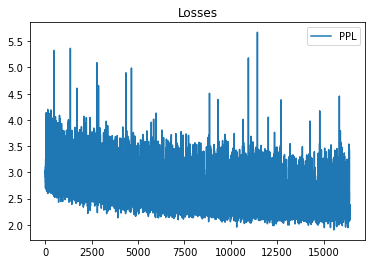

In [68]:
plt.plot(list(range(0, len(train_losses["steps"]))), train_losses['losses'], label="PPL")
# plt.plot(val_steps, val_losses["val_losses"], label="Val")
# plt.plot(list(range(0, len(train_losses["perplexities"][200:]))), train_losses['perplexities'][200:], label="PPL")
# plt.plot(list(range(0, len(train_losses["perplexities"]))), train_losses['perplexities'], label="PPL")
# plt.plot(list(range(0, len(train_losses["listener"]))), train_losses['speaker_f'], label="S F")
# plt.plot(list(range(0, len(train_losses["listener"]))), train_losses['listener'], label="Listener")
# plt.plot(list(range(0, len(train_losses["listener"]))), train_losses['accuracies'], label="Acc")

plt.legend()
plt.title("Losses")
plt.show()

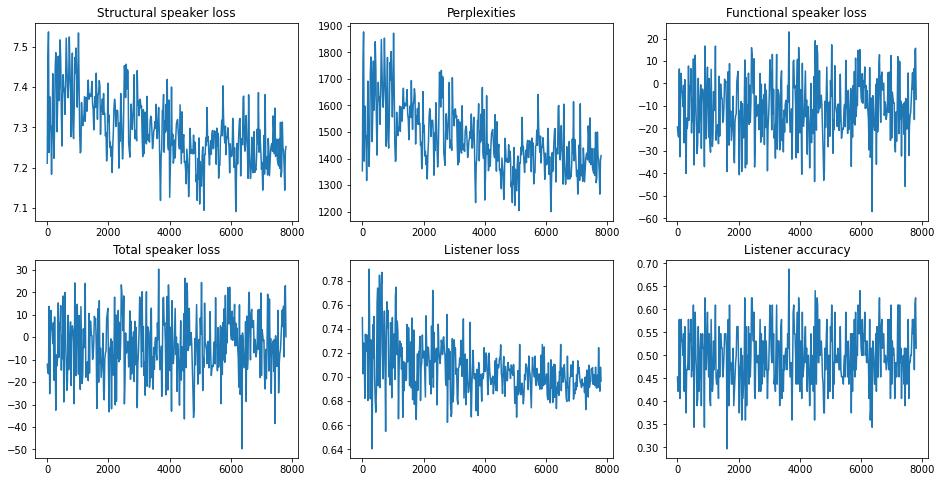

In [28]:
fig = plt.figure(figsize=(16, 8))
columns = 3
rows = 3

fig.add_subplot(2,3, 1)
plt.plot(train_losses_plot["plot_steps"], train_losses_plot['speaker_s'], label="S_s")
plt.title("Structural speaker loss")
fig.add_subplot(2,3, 2)
plt.plot(train_losses_plot["plot_steps"], train_losses_plot['perplexities'], label="PPL")
plt.title("Perplexities")
fig.add_subplot(2,3,3)
plt.plot(train_losses_plot["plot_steps"], train_losses_plot['speaker_f'], label="S_f")
plt.title("Functional speaker loss")

fig.add_subplot(2,3, 4)
plt.plot(train_losses_plot["plot_steps"], train_losses_plot['speaker'], label="Speaker loss")
plt.title("Total speaker loss")
fig.add_subplot(2,3,5)
plt.plot(train_losses_plot["plot_steps"], train_losses_plot['listener'], label="Listener loss")
plt.title("Listener loss")
fig.add_subplot(2,3,6)
plt.plot(train_losses_plot["plot_steps"], train_losses_plot['accuracies'], label="Acc")
plt.title("Listener accuracy")

plt.show()


In [63]:
# plot drift metric
train_metrics = pd.read_csv("../functional_language_drift_metrics_train_epoch_5.csv")

train_metrics["drift_num"] = train_metrics["semantic_drifts"].apply(lambda s: float(re.sub("[^0-9\.-]", "", s)))
train_metrics.head()
metrics_tensor = torch.tensor(train_metrics["drift_num"]).view(-1, 64)
# metrics_tensor.shape # len(train_metrics)
metrics_mean = metrics_tensor.mean(dim=1)
metrics_mean_list = metrics_mean.tolist()
metrics_steps = list(range(0, len(metrics_mean_list)))
# train_metrics.iloc[2, 2]

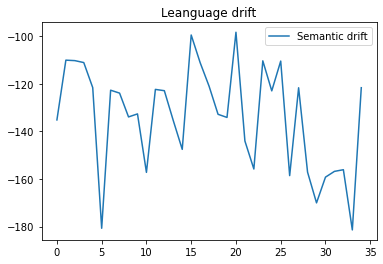

In [64]:
plt.plot(metrics_steps, metrics_mean_list, label="Semantic drift")

plt.legend()
plt.title("Leanguage drift")
plt.show()

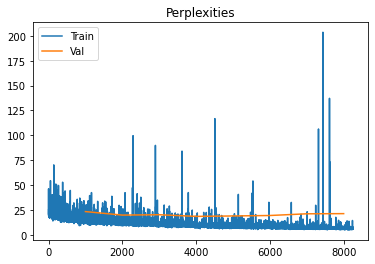

In [9]:
val_perplexities = [np.exp(x) for x in val_losses["val_losses"]]

plt.plot(list(range(0, len(train_losses["perplexities"][500:]))), train_losses['perplexities'][500:], label="Train")
plt.plot(val_steps, val_perplexities, label="Val")
plt.legend()
plt.title("Perplexities")
plt.show()

Ideally, the pretrained speaker model should be evaluated in order to estimate the quality of the base performance, since it is critical for any kinds of changes that could follow from functional training. The evaluation should contain some standard methods like BLEU, and maybe one or two language drift explorations. Some examples should be inspected manually, too.  
In case the performance is bad, the following aspects could be tweaked: train longer (larger early stopping delta), different NN weight initialization, more data. 

### References

The code was created with the help of [this](https://medium.com/@deepeshrishu09/automatic-image-captioning-with-pytorch-cf576c98d319) and [this](https://medium.com/@thechrisyoon/deriving-policy-gradients-and-implementing-reinforce-f887949bd63) tutorial.

In [70]:
## create a test corpus

# data_loader_val = get_loader(transform=transform_test,
#                          mode='val',
#                          batch_size=1,
#                          vocab_threshold=11,
#                          vocab_from_file=True,
#                          download_dir="../../../data/val", 
#                               vocab_file="vocab.pkl"
# #                          vocab_file='../../../data/vocab.pkl'
#                         )
train_coco = COCO("../../../data/train/annotations/captions_train2014.json") #.anns.keys()
used_val_ids = torch.load("../pretrain_val_img_IDs_2imgs_main.pt").tolist()

loading annotations into memory...
Done (t=0.45s)
creating index...
index created!


In [45]:
len(val_ids)
len(used_val_ids)

3700

In [46]:
# sample 7000 test images and captions which were not used before
possible_test_ids = [x for x in val_ids if x not in used_val_ids]
test_ds = list(np.random.choice(possible_test_ids, 7000))

In [51]:
len(test_ds)

7000

In [52]:
# torch.save(test_ds, "testset_IDs_fromVal_ds.pt")

In [60]:
# create a loop iterating over the test images to compute the BLEU score for two models

torch.manual_seed(42)
transform_test = transforms.Compose([transforms.Resize((224, 224)), \
                                     transforms.ToTensor(), \
                                     transforms.Normalize((0.485, 0.456, 0.406), \
                                                          (0.229, 0.224, 0.225))])
data_loader_test = get_loader(transform=transform_test,
                         mode='val',
                         batch_size=1,
                         vocab_threshold=11,
                         vocab_from_file=True,
                         download_dir="../../../data/val", 
                              vocab_file="vocab.pkl"
#                          vocab_file='../../../data/vocab.pkl'
                        )
encoder_file_prepend = 'encoder-byImage-prepend-1024dim-6000vocab-wResNet-1.pkl' 
decoder_file_prepend = 'decoder-byImage-prepend-1024dim-6000vocab-wResNet-1.pkl'

encoder_file_token0 = 'encoder-byImage-1024dim-6000vocab-wResNet-2.pkl' 
decoder_file_token0 = 'decoder-byImage-1024dim-6000vocab-wResNet-2.pkl'


embed_size = 2048 #512
visual_embed_size = 1024
hidden_size = 512

# The size of the vocabulary.
vocab_size = len(data_loader_test.dataset.vocab)
print("VOCAB: ", vocab_size)
# Initialize the encoder and decoder, and set each to inference mode.
encoder_prepend = EncoderCNN(visual_embed_size)
encoder_prepend.eval()
decoder_prepend = DecoderRNN(embed_size, hidden_size, vocab_size, 1024)
decoder_prepend.eval()

# Load the trained weights.
encoder_prepend.load_state_dict(torch.load(os.path.join('./../models', encoder_file_prepend)))
decoder_prepend.load_state_dict(torch.load(os.path.join('./../models', decoder_file_prepend)))

# Move models to GPU if CUDA is available.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder_prepend.to(device)
decoder_prepend.to(device)

## second model
encoder_token0 = EncoderCNN(visual_embed_size)
encoder_token0.eval()
decoder_token0 = DecoderRNN_token0(embed_size, hidden_size, vocab_size, 1024)
decoder_token0.eval()

# Load the trained weights.
encoder_token0.load_state_dict(torch.load(os.path.join('./../models', encoder_file_token0)))
decoder_token0.load_state_dict(torch.load(os.path.join('./../models', decoder_file_token0)))

# Move models to GPU if CUDA is available.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder_token0.to(device)
decoder_token0.to(device)


Vocabulary successfully loaded from vocab.pkl file!
loading annotations into memory...
Done (t=0.21s)
creating index...
index created!
Obtaining caption lengths...
VOCAB:  6039


DecoderRNN_token0(
  (embed): Embedding(6039, 2048)
  (lstm): LSTM(2048, 512, batch_first=True)
  (linear): Linear(in_features=512, out_features=6039, bias=True)
)

In [61]:
# create dicts
orig_captions = []
decoder_token0_captions = []
decoder_prepend_captions = []

# iterate over dataset
for i in range(len(test_ds)):
    test_indices = data_loader_test.dataset.get_func_train_indices() 
    print("Test inds: ", test_indices)
    # Create and assign a batch sampler to retrieve a batch with the sampled indices.
    new_sampler = torch.utils.data.sampler.SubsetRandomSampler(indices=test_indices)
    data_loader_test.batch_sampler.sampler = new_sampler  

    orig_image, dist_image, cap = next(iter(data_loader_test))
    orig_captions.append(cap)
    
    # get the predictions
    # model with prepended images
    features_t_emb, _ = encoder_prepend(orig_image)
    features_d_emb, _ = encoder_prepend(dist_image)
    both_images = torch.cat((features_t_emb, features_d_emb), dim=-1)

    output_prepend, log_p, raw = decoder_prepend.sample(both_images.unsqueeze(1), 27)
    sentence_prepend = clean_sentence(output_prepend)
    decoder_prepend_captions.append(sentence_prepend)
    
    # model with token 0 images
    features_t_emb, _ = encoder_token0(orig_image)
    features_d_emb, _ = encoder_token0(dist_image)
    both_images = torch.cat((features_t_emb, features_d_emb), dim=-1)

    output_token0, log_p, raw = decoder_token0.sample(both_images.unsqueeze(1), 27)
    sentence_token0 = clean_sentence(output_token0)
    decoder_token0_captions.append(sentence_token0)

Test inds:  [(1848, 1785)]
Ann_id in getitem:  42557
Test inds:  [(995, 1005)]
Ann_id in getitem:  23655
Test inds:  [(337, 1525)]
Ann_id in getitem:  8226
Test inds:  [(48, 426)]
Ann_id in getitem:  974
Test inds:  [(492, 2181)]
Ann_id in getitem:  11821
Test inds:  [(2177, 1697)]
Ann_id in getitem:  49079
Test inds:  [(865, 1777)]
Ann_id in getitem:  20910
Test inds:  [(3419, 1826)]
Ann_id in getitem:  78749
Test inds:  [(2198, 1367)]
Ann_id in getitem:  49494
Test inds:  [(2820, 3557)]
Ann_id in getitem:  64986
Test inds:  [(3571, 3646)]
Ann_id in getitem:  82346
Test inds:  [(1831, 1280)]
Ann_id in getitem:  42080
Test inds:  [(2739, 2219)]
Ann_id in getitem:  63066
Test inds:  [(1980, 2835)]
Ann_id in getitem:  45155
Test inds:  [(2078, 1303)]
Ann_id in getitem:  47189
Test inds:  [(595, 617)]
Ann_id in getitem:  14427
Test inds:  [(2211, 588)]
Ann_id in getitem:  49740
Test inds:  [(1574, 305)]
Ann_id in getitem:  37275
Test inds:  [(2543, 4)]
Ann_id in getitem:  57767
Test inds:

Test inds:  [(3546, 611)]
Ann_id in getitem:  81822
Test inds:  [(2136, 3583)]
Ann_id in getitem:  48396
Test inds:  [(3697, 115)]
Ann_id in getitem:  85435
Test inds:  [(235, 2673)]
Ann_id in getitem:  5749
Test inds:  [(1886, 2478)]
Ann_id in getitem:  43376
Test inds:  [(1037, 1390)]
Ann_id in getitem:  24537
Test inds:  [(3301, 2375)]
Ann_id in getitem:  75728
Test inds:  [(2910, 282)]
Ann_id in getitem:  67092
Test inds:  [(3124, 3120)]
Ann_id in getitem:  72017
Test inds:  [(2907, 1060)]
Ann_id in getitem:  67051
Test inds:  [(2877, 2738)]
Ann_id in getitem:  66124
Test inds:  [(402, 1295)]
Ann_id in getitem:  9897
Test inds:  [(1212, 2074)]
Ann_id in getitem:  28241
Test inds:  [(1921, 2782)]
Ann_id in getitem:  43968
Test inds:  [(176, 1849)]
Ann_id in getitem:  4451
Test inds:  [(972, 2369)]
Ann_id in getitem:  22947
Test inds:  [(2738, 795)]
Ann_id in getitem:  63062
Test inds:  [(3397, 561)]
Ann_id in getitem:  78099
Test inds:  [(2849, 3046)]
Ann_id in getitem:  65577
Test 

Test inds:  [(2140, 811)]
Ann_id in getitem:  48460
Test inds:  [(468, 706)]
Ann_id in getitem:  11279
Test inds:  [(1947, 1682)]
Ann_id in getitem:  44320
Test inds:  [(2089, 228)]
Ann_id in getitem:  47397
Test inds:  [(2518, 2206)]
Ann_id in getitem:  57251
Test inds:  [(3067, 2359)]
Ann_id in getitem:  70680
Test inds:  [(198, 2472)]
Ann_id in getitem:  4985
Test inds:  [(1236, 1468)]
Ann_id in getitem:  28894
Test inds:  [(1001, 119)]
Ann_id in getitem:  23725
Test inds:  [(2919, 1852)]
Ann_id in getitem:  67228
Test inds:  [(1287, 1488)]
Ann_id in getitem:  30176
Test inds:  [(1730, 112)]
Ann_id in getitem:  40309
Test inds:  [(702, 2227)]
Ann_id in getitem:  17065
Test inds:  [(602, 3304)]
Ann_id in getitem:  14565
Test inds:  [(20, 3215)]
Ann_id in getitem:  452
Test inds:  [(2390, 1677)]
Ann_id in getitem:  54109
Test inds:  [(867, 2853)]
Ann_id in getitem:  20919
Test inds:  [(3402, 1442)]
Ann_id in getitem:  78308
Test inds:  [(1110, 372)]
Ann_id in getitem:  25767
Test inds

Test inds:  [(2507, 2111)]
Ann_id in getitem:  57060
Test inds:  [(1724, 1222)]
Ann_id in getitem:  40226
Test inds:  [(2436, 733)]
Ann_id in getitem:  55096
Test inds:  [(1004, 3684)]
Ann_id in getitem:  23799
Test inds:  [(1325, 1491)]
Ann_id in getitem:  31012
Test inds:  [(3315, 760)]
Ann_id in getitem:  76162
Test inds:  [(283, 3050)]
Ann_id in getitem:  6647
Test inds:  [(1900, 2653)]
Ann_id in getitem:  43579
Test inds:  [(2143, 913)]
Ann_id in getitem:  48494
Test inds:  [(2334, 845)]
Ann_id in getitem:  52637
Test inds:  [(2831, 2226)]
Ann_id in getitem:  65285
Test inds:  [(940, 130)]
Ann_id in getitem:  22343
Test inds:  [(1091, 1202)]
Ann_id in getitem:  25434
Test inds:  [(2804, 198)]
Ann_id in getitem:  64707
Test inds:  [(2271, 3566)]
Ann_id in getitem:  51386
Test inds:  [(51, 1230)]
Ann_id in getitem:  1037
Test inds:  [(1783, 1501)]
Ann_id in getitem:  41100
Test inds:  [(3431, 2644)]
Ann_id in getitem:  79085
Test inds:  [(760, 2006)]
Ann_id in getitem:  18463
Test i

Test inds:  [(580, 3649)]
Ann_id in getitem:  14091
Test inds:  [(1645, 1429)]
Ann_id in getitem:  38521
Test inds:  [(2683, 1260)]
Ann_id in getitem:  61622
Test inds:  [(1688, 3397)]
Ann_id in getitem:  39530
Test inds:  [(2781, 1680)]
Ann_id in getitem:  64155
Test inds:  [(2962, 2422)]
Ann_id in getitem:  68179
Test inds:  [(2571, 2417)]
Ann_id in getitem:  58628
Test inds:  [(2370, 2253)]
Ann_id in getitem:  53599
Test inds:  [(3302, 1136)]
Ann_id in getitem:  75751
Test inds:  [(3186, 1261)]
Ann_id in getitem:  73364
Test inds:  [(2574, 1125)]
Ann_id in getitem:  58663
Test inds:  [(1270, 643)]
Ann_id in getitem:  29641
Test inds:  [(2143, 3257)]
Ann_id in getitem:  48494
Test inds:  [(2862, 1068)]
Ann_id in getitem:  65761
Test inds:  [(2562, 2551)]
Ann_id in getitem:  58233
Test inds:  [(2990, 2698)]
Ann_id in getitem:  68939
Test inds:  [(1873, 523)]
Ann_id in getitem:  43075
Test inds:  [(2543, 1195)]
Ann_id in getitem:  57767
Test inds:  [(1968, 568)]
Ann_id in getitem:  449

Test inds:  [(1017, 2972)]
Ann_id in getitem:  24110
Test inds:  [(768, 348)]
Ann_id in getitem:  18562
Test inds:  [(845, 1356)]
Ann_id in getitem:  20472
Test inds:  [(629, 25)]
Ann_id in getitem:  15332
Test inds:  [(1835, 991)]
Ann_id in getitem:  42156
Test inds:  [(1223, 1953)]
Ann_id in getitem:  28576
Test inds:  [(1429, 292)]
Ann_id in getitem:  33892
Test inds:  [(2611, 3596)]
Ann_id in getitem:  59841
Test inds:  [(2916, 1487)]
Ann_id in getitem:  67135
Test inds:  [(2034, 776)]
Ann_id in getitem:  46308
Test inds:  [(1290, 3632)]
Ann_id in getitem:  30285
Test inds:  [(1566, 1677)]
Ann_id in getitem:  36993
Test inds:  [(1592, 3174)]
Ann_id in getitem:  37549
Test inds:  [(2842, 3607)]
Ann_id in getitem:  65439
Test inds:  [(3606, 32)]
Ann_id in getitem:  83291
Test inds:  [(939, 937)]
Ann_id in getitem:  22341
Test inds:  [(2572, 170)]
Ann_id in getitem:  58645
Test inds:  [(3131, 2447)]
Ann_id in getitem:  72184
Test inds:  [(2380, 1870)]
Ann_id in getitem:  53783
Test in

Test inds:  [(2611, 1933)]
Ann_id in getitem:  59841
Test inds:  [(3430, 2388)]
Ann_id in getitem:  79058
Test inds:  [(1429, 3110)]
Ann_id in getitem:  33892
Test inds:  [(468, 2304)]
Ann_id in getitem:  11279
Test inds:  [(2875, 3226)]
Ann_id in getitem:  66059
Test inds:  [(2859, 2344)]
Ann_id in getitem:  65727
Test inds:  [(1449, 956)]
Ann_id in getitem:  34312
Test inds:  [(1042, 3197)]
Ann_id in getitem:  24664
Test inds:  [(3098, 3058)]
Ann_id in getitem:  71418
Test inds:  [(2177, 3345)]
Ann_id in getitem:  49079
Test inds:  [(1171, 2745)]
Ann_id in getitem:  27251
Test inds:  [(2505, 1751)]
Ann_id in getitem:  57045
Test inds:  [(2550, 68)]
Ann_id in getitem:  57948
Test inds:  [(3603, 1620)]
Ann_id in getitem:  83130
Test inds:  [(2165, 3484)]
Ann_id in getitem:  48865
Test inds:  [(397, 102)]
Ann_id in getitem:  9769
Test inds:  [(2745, 1590)]
Ann_id in getitem:  63173
Test inds:  [(3218, 1829)]
Ann_id in getitem:  74015
Test inds:  [(3558, 3606)]
Ann_id in getitem:  82054


Test inds:  [(1228, 1048)]
Ann_id in getitem:  28712
Test inds:  [(904, 2000)]
Ann_id in getitem:  21602
Test inds:  [(1359, 3150)]
Ann_id in getitem:  32039
Test inds:  [(2407, 3324)]
Ann_id in getitem:  54427
Test inds:  [(1865, 1261)]
Ann_id in getitem:  42971
Test inds:  [(3517, 114)]
Ann_id in getitem:  81156
Test inds:  [(3010, 1153)]
Ann_id in getitem:  69388
Test inds:  [(476, 2261)]
Ann_id in getitem:  11512
Test inds:  [(650, 499)]
Ann_id in getitem:  15861
Test inds:  [(3501, 259)]
Ann_id in getitem:  80649
Test inds:  [(2613, 3325)]
Ann_id in getitem:  59857
Test inds:  [(2473, 1964)]
Ann_id in getitem:  56274
Test inds:  [(419, 2483)]
Ann_id in getitem:  10187
Test inds:  [(704, 1225)]
Ann_id in getitem:  17085
Test inds:  [(909, 1161)]
Ann_id in getitem:  21647
Test inds:  [(1641, 2007)]
Ann_id in getitem:  38500
Test inds:  [(3523, 2315)]
Ann_id in getitem:  81287
Test inds:  [(3676, 2923)]
Ann_id in getitem:  84764
Test inds:  [(1653, 56)]
Ann_id in getitem:  38727
Test

Test inds:  [(914, 3286)]
Ann_id in getitem:  21788
Test inds:  [(2582, 3457)]
Ann_id in getitem:  58999
Test inds:  [(2776, 3064)]
Ann_id in getitem:  63953
Test inds:  [(32, 1365)]
Ann_id in getitem:  701
Test inds:  [(3591, 860)]
Ann_id in getitem:  82805
Test inds:  [(3292, 2720)]
Ann_id in getitem:  75467
Test inds:  [(985, 850)]
Ann_id in getitem:  23419
Test inds:  [(414, 3137)]
Ann_id in getitem:  10100
Test inds:  [(3330, 1343)]
Ann_id in getitem:  76518
Test inds:  [(2275, 1777)]
Ann_id in getitem:  51424
Test inds:  [(2660, 2613)]
Ann_id in getitem:  61028
Test inds:  [(214, 3514)]
Ann_id in getitem:  5369
Test inds:  [(2822, 469)]
Ann_id in getitem:  65049
Test inds:  [(2799, 1333)]
Ann_id in getitem:  64555
Test inds:  [(953, 72)]
Ann_id in getitem:  22578
Test inds:  [(594, 2172)]
Ann_id in getitem:  14398
Test inds:  [(2179, 2091)]
Ann_id in getitem:  49124
Test inds:  [(1957, 2022)]
Ann_id in getitem:  44503
Test inds:  [(1997, 3568)]
Ann_id in getitem:  45522
Test inds

Test inds:  [(1914, 3157)]
Ann_id in getitem:  43829
Test inds:  [(397, 1721)]
Ann_id in getitem:  9769
Test inds:  [(2271, 3649)]
Ann_id in getitem:  51386
Test inds:  [(3312, 147)]
Ann_id in getitem:  76011
Test inds:  [(2633, 599)]
Ann_id in getitem:  60290
Test inds:  [(773, 2130)]
Ann_id in getitem:  18756
Test inds:  [(202, 1885)]
Ann_id in getitem:  5018
Test inds:  [(2612, 1923)]
Ann_id in getitem:  59845
Test inds:  [(518, 2488)]
Ann_id in getitem:  12357
Test inds:  [(2093, 2067)]
Ann_id in getitem:  47425
Test inds:  [(1153, 2160)]
Ann_id in getitem:  26813
Test inds:  [(1399, 843)]
Ann_id in getitem:  33180
Test inds:  [(923, 1976)]
Ann_id in getitem:  22116
Test inds:  [(2888, 1885)]
Ann_id in getitem:  66440
Test inds:  [(2435, 2681)]
Ann_id in getitem:  55095
Test inds:  [(2678, 3696)]
Ann_id in getitem:  61409
Test inds:  [(1106, 1006)]
Ann_id in getitem:  25701
Test inds:  [(3589, 1354)]
Ann_id in getitem:  82774
Test inds:  [(1616, 3674)]
Ann_id in getitem:  37888
Tes

Test inds:  [(3010, 416)]
Ann_id in getitem:  69388
Test inds:  [(886, 3394)]
Ann_id in getitem:  21159
Test inds:  [(1421, 2230)]
Ann_id in getitem:  33710
Test inds:  [(2433, 304)]
Ann_id in getitem:  55019
Test inds:  [(867, 804)]
Ann_id in getitem:  20919
Test inds:  [(2013, 1626)]
Ann_id in getitem:  45826
Test inds:  [(1483, 2083)]
Ann_id in getitem:  35229
Test inds:  [(360, 1842)]
Ann_id in getitem:  8724
Test inds:  [(242, 522)]
Ann_id in getitem:  5871
Test inds:  [(1749, 1325)]
Ann_id in getitem:  40552
Test inds:  [(1810, 116)]
Ann_id in getitem:  41711
Test inds:  [(1375, 2759)]
Ann_id in getitem:  32506
Test inds:  [(3086, 454)]
Ann_id in getitem:  71201
Test inds:  [(3487, 3309)]
Ann_id in getitem:  80344
Test inds:  [(963, 2496)]
Ann_id in getitem:  22776
Test inds:  [(143, 806)]
Ann_id in getitem:  3464
Test inds:  [(1220, 3462)]
Ann_id in getitem:  28505
Test inds:  [(3468, 3102)]
Ann_id in getitem:  80052
Test inds:  [(434, 555)]
Ann_id in getitem:  10667
Test inds: 

Test inds:  [(974, 1935)]
Ann_id in getitem:  22963
Test inds:  [(3580, 1938)]
Ann_id in getitem:  82483
Test inds:  [(478, 1705)]
Ann_id in getitem:  11519
Test inds:  [(841, 1012)]
Ann_id in getitem:  20304
Test inds:  [(238, 1658)]
Ann_id in getitem:  5795
Test inds:  [(2004, 161)]
Ann_id in getitem:  45648
Test inds:  [(2762, 405)]
Ann_id in getitem:  63517
Test inds:  [(1239, 3454)]
Ann_id in getitem:  28966
Test inds:  [(1530, 866)]
Ann_id in getitem:  36222
Test inds:  [(648, 676)]
Ann_id in getitem:  15817
Test inds:  [(3273, 2610)]
Ann_id in getitem:  74988
Test inds:  [(1966, 908)]
Ann_id in getitem:  44888
Test inds:  [(3542, 1931)]
Ann_id in getitem:  81710
Test inds:  [(1421, 3142)]
Ann_id in getitem:  33710
Test inds:  [(3344, 1816)]
Ann_id in getitem:  76854
Test inds:  [(2576, 2686)]
Ann_id in getitem:  58713
Test inds:  [(4, 2073)]
Ann_id in getitem:  98
Test inds:  [(70, 1554)]
Ann_id in getitem:  1562
Test inds:  [(1568, 2436)]
Ann_id in getitem:  37096
Test inds:  [

Test inds:  [(2281, 2405)]
Ann_id in getitem:  51602
Test inds:  [(3670, 337)]
Ann_id in getitem:  84666
Test inds:  [(1651, 2467)]
Ann_id in getitem:  38642
Test inds:  [(3384, 2607)]
Ann_id in getitem:  77826
Test inds:  [(2106, 3630)]
Ann_id in getitem:  47683
Test inds:  [(1594, 3456)]
Ann_id in getitem:  37627
Test inds:  [(2228, 3321)]
Ann_id in getitem:  50166
Test inds:  [(154, 747)]
Ann_id in getitem:  3765
Test inds:  [(1549, 1589)]
Ann_id in getitem:  36600
Test inds:  [(2133, 3128)]
Ann_id in getitem:  48316
Test inds:  [(1055, 3265)]
Ann_id in getitem:  24930
Test inds:  [(746, 1212)]
Ann_id in getitem:  18027
Test inds:  [(1991, 1986)]
Ann_id in getitem:  45378
Test inds:  [(2867, 3293)]
Ann_id in getitem:  65912
Test inds:  [(3254, 435)]
Ann_id in getitem:  74750
Test inds:  [(1297, 3362)]
Ann_id in getitem:  30406
Test inds:  [(3058, 3170)]
Ann_id in getitem:  70591
Test inds:  [(619, 3572)]
Ann_id in getitem:  15172
Test inds:  [(108, 2882)]
Ann_id in getitem:  2473
Te

Test inds:  [(3381, 2337)]
Ann_id in getitem:  77762
Test inds:  [(3420, 1702)]
Ann_id in getitem:  78757
Test inds:  [(1351, 1628)]
Ann_id in getitem:  31835
Test inds:  [(2345, 1280)]
Ann_id in getitem:  52927
Test inds:  [(122, 2081)]
Ann_id in getitem:  2919
Test inds:  [(1671, 3183)]
Ann_id in getitem:  39137
Test inds:  [(1745, 2100)]
Ann_id in getitem:  40508
Test inds:  [(2673, 1248)]
Ann_id in getitem:  61322
Test inds:  [(1991, 3359)]
Ann_id in getitem:  45378
Test inds:  [(1736, 1141)]
Ann_id in getitem:  40402
Test inds:  [(2521, 1791)]
Ann_id in getitem:  57302
Test inds:  [(2433, 262)]
Ann_id in getitem:  55019
Test inds:  [(3606, 374)]
Ann_id in getitem:  83291
Test inds:  [(729, 877)]
Ann_id in getitem:  17588
Test inds:  [(3638, 1221)]
Ann_id in getitem:  83968
Test inds:  [(2059, 164)]
Ann_id in getitem:  46861
Test inds:  [(3506, 1462)]
Ann_id in getitem:  80903
Test inds:  [(571, 148)]
Ann_id in getitem:  13792
Test inds:  [(2199, 2022)]
Ann_id in getitem:  49505
Te

Test inds:  [(2234, 2122)]
Ann_id in getitem:  50316
Test inds:  [(1285, 1531)]
Ann_id in getitem:  30071
Test inds:  [(1326, 325)]
Ann_id in getitem:  31015
Test inds:  [(3522, 2697)]
Ann_id in getitem:  81276
Test inds:  [(1235, 2736)]
Ann_id in getitem:  28884
Test inds:  [(3636, 1224)]
Ann_id in getitem:  83948
Test inds:  [(2686, 974)]
Ann_id in getitem:  61648
Test inds:  [(133, 656)]
Ann_id in getitem:  3202
Test inds:  [(3129, 777)]
Ann_id in getitem:  72149
Test inds:  [(1152, 833)]
Ann_id in getitem:  26807
Test inds:  [(1330, 1626)]
Ann_id in getitem:  31230
Test inds:  [(1092, 599)]
Ann_id in getitem:  25487
Test inds:  [(1744, 3058)]
Ann_id in getitem:  40485
Test inds:  [(688, 2003)]
Ann_id in getitem:  16752
Test inds:  [(1325, 1978)]
Ann_id in getitem:  31012
Test inds:  [(1013, 3626)]
Ann_id in getitem:  24056
Test inds:  [(423, 948)]
Ann_id in getitem:  10264
Test inds:  [(2194, 1807)]
Ann_id in getitem:  49381
Test inds:  [(3096, 2967)]
Ann_id in getitem:  71328
Test

Test inds:  [(2936, 1456)]
Ann_id in getitem:  67660
Test inds:  [(117, 3361)]
Ann_id in getitem:  2734
Test inds:  [(1691, 2715)]
Ann_id in getitem:  39673
Test inds:  [(3080, 1869)]
Ann_id in getitem:  71062
Test inds:  [(1163, 2484)]
Ann_id in getitem:  27101
Test inds:  [(2039, 1682)]
Ann_id in getitem:  46433
Test inds:  [(3323, 3081)]
Ann_id in getitem:  76368
Test inds:  [(1049, 329)]
Ann_id in getitem:  24779
Test inds:  [(2088, 2315)]
Ann_id in getitem:  47370
Test inds:  [(1437, 2684)]
Ann_id in getitem:  34092
Test inds:  [(2954, 3244)]
Ann_id in getitem:  68034
Test inds:  [(476, 2907)]
Ann_id in getitem:  11512
Test inds:  [(3575, 155)]
Ann_id in getitem:  82426
Test inds:  [(2469, 1301)]
Ann_id in getitem:  56160
Test inds:  [(910, 481)]
Ann_id in getitem:  21662
Test inds:  [(1671, 1456)]
Ann_id in getitem:  39137
Test inds:  [(2931, 3156)]
Ann_id in getitem:  67503
Test inds:  [(1386, 2300)]
Ann_id in getitem:  32931
Test inds:  [(741, 1516)]
Ann_id in getitem:  17964
T

Test inds:  [(2052, 2205)]
Ann_id in getitem:  46731
Test inds:  [(2727, 738)]
Ann_id in getitem:  62746
Test inds:  [(3340, 1345)]
Ann_id in getitem:  76767
Test inds:  [(2361, 1767)]
Ann_id in getitem:  53387
Test inds:  [(2673, 2713)]
Ann_id in getitem:  61322
Test inds:  [(617, 1616)]
Ann_id in getitem:  15161
Test inds:  [(2634, 1784)]
Ann_id in getitem:  60296
Test inds:  [(1803, 6)]
Ann_id in getitem:  41600
Test inds:  [(3243, 1620)]
Ann_id in getitem:  74554
Test inds:  [(550, 263)]
Ann_id in getitem:  13214
Test inds:  [(2078, 3078)]
Ann_id in getitem:  47189
Test inds:  [(191, 3258)]
Ann_id in getitem:  4844
Test inds:  [(2423, 823)]
Ann_id in getitem:  54783
Test inds:  [(1101, 2537)]
Ann_id in getitem:  25609
Test inds:  [(2441, 231)]
Ann_id in getitem:  55355
Test inds:  [(2456, 2769)]
Ann_id in getitem:  55772
Test inds:  [(2335, 1760)]
Ann_id in getitem:  52659
Test inds:  [(2611, 179)]
Ann_id in getitem:  59841
Test inds:  [(3140, 2505)]
Ann_id in getitem:  72439
Test 

Test inds:  [(1105, 1773)]
Ann_id in getitem:  25692
Test inds:  [(3599, 1563)]
Ann_id in getitem:  83057
Test inds:  [(699, 148)]
Ann_id in getitem:  16995
Test inds:  [(2562, 712)]
Ann_id in getitem:  58233
Test inds:  [(2367, 295)]
Ann_id in getitem:  53536
Test inds:  [(3645, 1893)]
Ann_id in getitem:  84145
Test inds:  [(2697, 748)]
Ann_id in getitem:  62007
Test inds:  [(1215, 1925)]
Ann_id in getitem:  28350
Test inds:  [(1777, 969)]
Ann_id in getitem:  41029
Test inds:  [(1776, 1794)]
Ann_id in getitem:  41018
Test inds:  [(2953, 388)]
Ann_id in getitem:  68021
Test inds:  [(718, 457)]
Ann_id in getitem:  17374
Test inds:  [(2428, 279)]
Ann_id in getitem:  54859
Test inds:  [(3388, 2910)]
Ann_id in getitem:  77853
Test inds:  [(2970, 2403)]
Ann_id in getitem:  68330
Test inds:  [(1359, 2883)]
Ann_id in getitem:  32039
Test inds:  [(689, 1960)]
Ann_id in getitem:  16759
Test inds:  [(898, 2429)]
Ann_id in getitem:  21512
Test inds:  [(1957, 1193)]
Ann_id in getitem:  44503
Test 

Test inds:  [(3357, 1577)]
Ann_id in getitem:  77015
Test inds:  [(1350, 2394)]
Ann_id in getitem:  31821
Test inds:  [(463, 693)]
Ann_id in getitem:  11200
Test inds:  [(87, 1952)]
Ann_id in getitem:  2028
Test inds:  [(233, 650)]
Ann_id in getitem:  5653
Test inds:  [(1871, 802)]
Ann_id in getitem:  43067
Test inds:  [(2797, 2127)]
Ann_id in getitem:  64518
Test inds:  [(2205, 732)]
Ann_id in getitem:  49639
Test inds:  [(1801, 475)]
Ann_id in getitem:  41579
Test inds:  [(1217, 3037)]
Ann_id in getitem:  28419
Test inds:  [(83, 3642)]
Ann_id in getitem:  1886
Test inds:  [(37, 2746)]
Ann_id in getitem:  833
Test inds:  [(110, 428)]
Ann_id in getitem:  2599
Test inds:  [(952, 1305)]
Ann_id in getitem:  22575
Test inds:  [(2851, 3661)]
Ann_id in getitem:  65613
Test inds:  [(2542, 3032)]
Ann_id in getitem:  57740
Test inds:  [(194, 1982)]
Ann_id in getitem:  4857
Test inds:  [(2795, 2819)]
Ann_id in getitem:  64487
Test inds:  [(3058, 2063)]
Ann_id in getitem:  70591
Test inds:  [(274

Test inds:  [(3522, 368)]
Ann_id in getitem:  81276
Test inds:  [(2553, 2708)]
Ann_id in getitem:  58014
Test inds:  [(1121, 970)]
Ann_id in getitem:  26049
Test inds:  [(1726, 3622)]
Ann_id in getitem:  40251
Test inds:  [(2385, 1534)]
Ann_id in getitem:  53913
Test inds:  [(114, 752)]
Ann_id in getitem:  2666
Test inds:  [(1419, 767)]
Ann_id in getitem:  33592
Test inds:  [(2306, 425)]
Ann_id in getitem:  52013
Test inds:  [(14, 1739)]
Ann_id in getitem:  342
Test inds:  [(81, 3559)]
Ann_id in getitem:  1865
Test inds:  [(3696, 2081)]
Ann_id in getitem:  85427
Test inds:  [(265, 2661)]
Ann_id in getitem:  6301
Test inds:  [(2695, 86)]
Ann_id in getitem:  61967
Test inds:  [(38, 930)]
Ann_id in getitem:  834
Test inds:  [(2981, 1285)]
Ann_id in getitem:  68777
Test inds:  [(3535, 2791)]
Ann_id in getitem:  81561
Test inds:  [(949, 3408)]
Ann_id in getitem:  22516
Test inds:  [(504, 1026)]
Ann_id in getitem:  12014
Test inds:  [(2829, 35)]
Ann_id in getitem:  65267
Test inds:  [(762, 7

Test inds:  [(3273, 1670)]
Ann_id in getitem:  74988
Test inds:  [(1029, 954)]
Ann_id in getitem:  24278
Test inds:  [(3217, 2504)]
Ann_id in getitem:  73990
Test inds:  [(2253, 2791)]
Ann_id in getitem:  50937
Test inds:  [(3136, 572)]
Ann_id in getitem:  72308
Test inds:  [(1347, 3302)]
Ann_id in getitem:  31739
Test inds:  [(2300, 433)]
Ann_id in getitem:  51858
Test inds:  [(2696, 615)]
Ann_id in getitem:  61994
Test inds:  [(2352, 3629)]
Ann_id in getitem:  53192
Test inds:  [(3583, 359)]
Ann_id in getitem:  82545
Test inds:  [(321, 935)]
Ann_id in getitem:  7911
Test inds:  [(1373, 1961)]
Ann_id in getitem:  32386
Test inds:  [(2117, 2712)]
Ann_id in getitem:  47986
Test inds:  [(2106, 782)]
Ann_id in getitem:  47683
Test inds:  [(501, 1960)]
Ann_id in getitem:  11986
Test inds:  [(1777, 112)]
Ann_id in getitem:  41029
Test inds:  [(546, 1272)]
Ann_id in getitem:  13014
Test inds:  [(2358, 2080)]
Ann_id in getitem:  53318
Test inds:  [(1140, 2314)]
Ann_id in getitem:  26661
Test 

Test inds:  [(3639, 2930)]
Ann_id in getitem:  83970
Test inds:  [(2574, 19)]
Ann_id in getitem:  58663
Test inds:  [(3207, 164)]
Ann_id in getitem:  73741
Test inds:  [(3538, 2026)]
Ann_id in getitem:  81588
Test inds:  [(2428, 3369)]
Ann_id in getitem:  54859
Test inds:  [(70, 295)]
Ann_id in getitem:  1562
Test inds:  [(900, 1688)]
Ann_id in getitem:  21526
Test inds:  [(634, 476)]
Ann_id in getitem:  15425
Test inds:  [(3429, 1368)]
Ann_id in getitem:  79028
Test inds:  [(1372, 3612)]
Ann_id in getitem:  32365
Test inds:  [(1005, 2905)]
Ann_id in getitem:  23874
Test inds:  [(3368, 2258)]
Ann_id in getitem:  77355
Test inds:  [(1453, 2528)]
Ann_id in getitem:  34392
Test inds:  [(3419, 1667)]
Ann_id in getitem:  78749
Test inds:  [(2846, 2316)]
Ann_id in getitem:  65541
Test inds:  [(2307, 2944)]
Ann_id in getitem:  52025
Test inds:  [(2520, 694)]
Ann_id in getitem:  57279
Test inds:  [(2119, 3519)]
Ann_id in getitem:  48004
Test inds:  [(1284, 1885)]
Ann_id in getitem:  30063
Test

Test inds:  [(865, 1567)]
Ann_id in getitem:  20910
Test inds:  [(77, 3619)]
Ann_id in getitem:  1707
Test inds:  [(2941, 3263)]
Ann_id in getitem:  67736
Test inds:  [(753, 441)]
Ann_id in getitem:  18251
Test inds:  [(2493, 3375)]
Ann_id in getitem:  56700
Test inds:  [(2554, 1113)]
Ann_id in getitem:  58015
Test inds:  [(20, 1878)]
Ann_id in getitem:  452
Test inds:  [(19, 3420)]
Ann_id in getitem:  447
Test inds:  [(1440, 3611)]
Ann_id in getitem:  34155
Test inds:  [(2377, 3609)]
Ann_id in getitem:  53753
Test inds:  [(592, 1659)]
Ann_id in getitem:  14358
Test inds:  [(3127, 2475)]
Ann_id in getitem:  72114
Test inds:  [(3353, 800)]
Ann_id in getitem:  76922
Test inds:  [(3673, 2858)]
Ann_id in getitem:  84720
Test inds:  [(1520, 2880)]
Ann_id in getitem:  36030
Test inds:  [(48, 3581)]
Ann_id in getitem:  974
Test inds:  [(197, 1246)]
Ann_id in getitem:  4957
Test inds:  [(3634, 1038)]
Ann_id in getitem:  83867
Test inds:  [(769, 3568)]
Ann_id in getitem:  18639
Test inds:  [(53

Test inds:  [(2629, 3278)]
Ann_id in getitem:  60199
Test inds:  [(2426, 914)]
Ann_id in getitem:  54841
Test inds:  [(1286, 432)]
Ann_id in getitem:  30110
Test inds:  [(287, 2485)]
Ann_id in getitem:  6700
Test inds:  [(3697, 2122)]
Ann_id in getitem:  85435
Test inds:  [(3346, 402)]
Ann_id in getitem:  76881
Test inds:  [(1115, 1839)]
Ann_id in getitem:  25844
Test inds:  [(2855, 1195)]
Ann_id in getitem:  65690
Test inds:  [(1540, 58)]
Ann_id in getitem:  36496
Test inds:  [(3205, 3429)]
Ann_id in getitem:  73728
Test inds:  [(2405, 2052)]
Ann_id in getitem:  54377
Test inds:  [(1243, 2224)]
Ann_id in getitem:  29124
Test inds:  [(2008, 3555)]
Ann_id in getitem:  45701
Test inds:  [(41, 1786)]
Ann_id in getitem:  891
Test inds:  [(2684, 2456)]
Ann_id in getitem:  61636
Test inds:  [(2700, 950)]
Ann_id in getitem:  62024
Test inds:  [(1876, 883)]
Ann_id in getitem:  43156
Test inds:  [(2468, 1342)]
Ann_id in getitem:  56148
Test inds:  [(1679, 2855)]
Ann_id in getitem:  39303
Test i

Test inds:  [(1847, 906)]
Ann_id in getitem:  42519
Test inds:  [(3548, 2211)]
Ann_id in getitem:  81846
Test inds:  [(3354, 1913)]
Ann_id in getitem:  76925
Test inds:  [(867, 2132)]
Ann_id in getitem:  20919
Test inds:  [(2991, 520)]
Ann_id in getitem:  68948
Test inds:  [(1055, 316)]
Ann_id in getitem:  24930
Test inds:  [(1616, 526)]
Ann_id in getitem:  37888
Test inds:  [(1469, 2191)]
Ann_id in getitem:  34786
Test inds:  [(3371, 2947)]
Ann_id in getitem:  77508
Test inds:  [(2159, 2741)]
Ann_id in getitem:  48721
Test inds:  [(1533, 3148)]
Ann_id in getitem:  36312
Test inds:  [(2010, 426)]
Ann_id in getitem:  45719
Test inds:  [(3440, 2835)]
Ann_id in getitem:  79259
Test inds:  [(3306, 3472)]
Ann_id in getitem:  75935
Test inds:  [(867, 567)]
Ann_id in getitem:  20919
Test inds:  [(3062, 2736)]
Ann_id in getitem:  70624
Test inds:  [(2335, 1072)]
Ann_id in getitem:  52659
Test inds:  [(1110, 1919)]
Ann_id in getitem:  25767
Test inds:  [(1950, 1989)]
Ann_id in getitem:  44354
T

Test inds:  [(2510, 1067)]
Ann_id in getitem:  57133
Test inds:  [(2199, 77)]
Ann_id in getitem:  49505
Test inds:  [(2657, 2042)]
Ann_id in getitem:  60988
Test inds:  [(1306, 3410)]
Ann_id in getitem:  30522
Test inds:  [(3671, 3639)]
Ann_id in getitem:  84679
Test inds:  [(1309, 292)]
Ann_id in getitem:  30639
Test inds:  [(1658, 333)]
Ann_id in getitem:  38806
Test inds:  [(2511, 1195)]
Ann_id in getitem:  57146
Test inds:  [(1837, 1210)]
Ann_id in getitem:  42181
Test inds:  [(1454, 2822)]
Ann_id in getitem:  34463
Test inds:  [(1800, 1702)]
Ann_id in getitem:  41577
Test inds:  [(143, 2568)]
Ann_id in getitem:  3464
Test inds:  [(2879, 658)]
Ann_id in getitem:  66209
Test inds:  [(3687, 470)]
Ann_id in getitem:  85147
Test inds:  [(1457, 2231)]
Ann_id in getitem:  34516
Test inds:  [(156, 2863)]
Ann_id in getitem:  3903
Test inds:  [(2853, 1736)]
Ann_id in getitem:  65665
Test inds:  [(1084, 840)]
Ann_id in getitem:  25277
Test inds:  [(1756, 730)]
Ann_id in getitem:  40646
Test 

Test inds:  [(3614, 2285)]
Ann_id in getitem:  83432
Test inds:  [(2392, 221)]
Ann_id in getitem:  54130
Test inds:  [(1922, 1718)]
Ann_id in getitem:  43980
Test inds:  [(2451, 732)]
Ann_id in getitem:  55680
Test inds:  [(767, 80)]
Ann_id in getitem:  18549
Test inds:  [(663, 141)]
Ann_id in getitem:  16179
Test inds:  [(3245, 3183)]
Ann_id in getitem:  74570
Test inds:  [(3533, 2005)]
Ann_id in getitem:  81544
Test inds:  [(1974, 2527)]
Ann_id in getitem:  44994
Test inds:  [(537, 1609)]
Ann_id in getitem:  12746
Test inds:  [(1145, 3468)]
Ann_id in getitem:  26740
Test inds:  [(195, 1506)]
Ann_id in getitem:  4882
Test inds:  [(982, 355)]
Ann_id in getitem:  23306
Test inds:  [(985, 1548)]
Ann_id in getitem:  23419
Test inds:  [(3252, 1230)]
Ann_id in getitem:  74681
Test inds:  [(3256, 1852)]
Ann_id in getitem:  74775
Test inds:  [(3313, 184)]
Ann_id in getitem:  76065
Test inds:  [(1262, 1452)]
Ann_id in getitem:  29544
Test inds:  [(649, 70)]
Ann_id in getitem:  15827
Test inds:

Test inds:  [(313, 2482)]
Ann_id in getitem:  7637
Test inds:  [(3655, 2319)]
Ann_id in getitem:  84414
Test inds:  [(1175, 2776)]
Ann_id in getitem:  27341
Test inds:  [(2295, 3176)]
Ann_id in getitem:  51786
Test inds:  [(3486, 2941)]
Ann_id in getitem:  80301
Test inds:  [(3265, 2863)]
Ann_id in getitem:  74882
Test inds:  [(3214, 3109)]
Ann_id in getitem:  73941
Test inds:  [(988, 1131)]
Ann_id in getitem:  23520
Test inds:  [(2916, 3384)]
Ann_id in getitem:  67135
Test inds:  [(3197, 1816)]
Ann_id in getitem:  73538
Test inds:  [(248, 901)]
Ann_id in getitem:  6023
Test inds:  [(2987, 863)]
Ann_id in getitem:  68923
Test inds:  [(1695, 2971)]
Ann_id in getitem:  39757
Test inds:  [(3113, 969)]
Ann_id in getitem:  71793
Test inds:  [(1186, 1090)]
Ann_id in getitem:  27671
Test inds:  [(2654, 2749)]
Ann_id in getitem:  60806
Test inds:  [(1741, 3237)]
Ann_id in getitem:  40458
Test inds:  [(3111, 3259)]
Ann_id in getitem:  71777
Test inds:  [(3623, 2744)]
Ann_id in getitem:  83592
T

Test inds:  [(586, 1900)]
Ann_id in getitem:  14235
Test inds:  [(1538, 2906)]
Ann_id in getitem:  36453
Test inds:  [(2156, 3363)]
Ann_id in getitem:  48659
Test inds:  [(2243, 3381)]
Ann_id in getitem:  50665
Test inds:  [(1325, 1311)]
Ann_id in getitem:  31012
Test inds:  [(2472, 3288)]
Ann_id in getitem:  56252
Test inds:  [(858, 2211)]
Ann_id in getitem:  20818
Test inds:  [(2495, 2207)]
Ann_id in getitem:  56735
Test inds:  [(3340, 2229)]
Ann_id in getitem:  76767
Test inds:  [(2821, 1300)]
Ann_id in getitem:  65005
Test inds:  [(2239, 3587)]
Ann_id in getitem:  50558
Test inds:  [(508, 339)]
Ann_id in getitem:  12169
Test inds:  [(2037, 1875)]
Ann_id in getitem:  46407
Test inds:  [(314, 1886)]
Ann_id in getitem:  7670
Test inds:  [(978, 3268)]
Ann_id in getitem:  23081
Test inds:  [(1830, 2006)]
Ann_id in getitem:  42053
Test inds:  [(2195, 1230)]
Ann_id in getitem:  49448
Test inds:  [(3544, 3279)]
Ann_id in getitem:  81777
Test inds:  [(3465, 2655)]
Ann_id in getitem:  80003


Test inds:  [(3049, 3245)]
Ann_id in getitem:  70292
Test inds:  [(692, 2999)]
Ann_id in getitem:  16853
Test inds:  [(671, 1085)]
Ann_id in getitem:  16340
Test inds:  [(923, 2977)]
Ann_id in getitem:  22116
Test inds:  [(988, 3696)]
Ann_id in getitem:  23520
Test inds:  [(1304, 2640)]
Ann_id in getitem:  30493
Test inds:  [(237, 2970)]
Ann_id in getitem:  5786
Test inds:  [(447, 680)]
Ann_id in getitem:  10897
Test inds:  [(3291, 2633)]
Ann_id in getitem:  75455
Test inds:  [(3159, 1349)]
Ann_id in getitem:  72813
Test inds:  [(2350, 3260)]
Ann_id in getitem:  53156
Test inds:  [(2550, 2122)]
Ann_id in getitem:  57948
Test inds:  [(3523, 2374)]
Ann_id in getitem:  81287
Test inds:  [(2007, 1066)]
Ann_id in getitem:  45683
Test inds:  [(539, 1860)]
Ann_id in getitem:  12831
Test inds:  [(3345, 799)]
Ann_id in getitem:  76870
Test inds:  [(3078, 2379)]
Ann_id in getitem:  71032
Test inds:  [(908, 2736)]
Ann_id in getitem:  21641
Test inds:  [(925, 3181)]
Ann_id in getitem:  22129
Test 

Test inds:  [(98, 2083)]
Ann_id in getitem:  2158
Test inds:  [(3015, 1566)]
Ann_id in getitem:  69504
Test inds:  [(1194, 455)]
Ann_id in getitem:  27832
Test inds:  [(15, 550)]
Ann_id in getitem:  391
Test inds:  [(1397, 173)]
Ann_id in getitem:  33147
Test inds:  [(1163, 1198)]
Ann_id in getitem:  27101
Test inds:  [(2702, 2298)]
Ann_id in getitem:  62121
Test inds:  [(3516, 2976)]
Ann_id in getitem:  81120
Test inds:  [(2488, 184)]
Ann_id in getitem:  56607
Test inds:  [(2077, 2942)]
Ann_id in getitem:  47186
Test inds:  [(3691, 2180)]
Ann_id in getitem:  85334
Test inds:  [(1208, 33)]
Ann_id in getitem:  28145
Test inds:  [(1500, 778)]
Ann_id in getitem:  35693
Test inds:  [(3386, 461)]
Ann_id in getitem:  77842
Test inds:  [(1596, 3328)]
Ann_id in getitem:  37674
Test inds:  [(3345, 2378)]
Ann_id in getitem:  76870
Test inds:  [(2881, 1562)]
Ann_id in getitem:  66219
Test inds:  [(345, 668)]
Ann_id in getitem:  8357
Test inds:  [(1617, 240)]
Ann_id in getitem:  37890
Test inds:  

Test inds:  [(2993, 3318)]
Ann_id in getitem:  68987
Test inds:  [(3490, 2520)]
Ann_id in getitem:  80401
Test inds:  [(2040, 1712)]
Ann_id in getitem:  46440
Test inds:  [(2244, 2632)]
Ann_id in getitem:  50687
Test inds:  [(795, 98)]
Ann_id in getitem:  19259
Test inds:  [(1975, 1670)]
Ann_id in getitem:  45007
Test inds:  [(1670, 2515)]
Ann_id in getitem:  39069
Test inds:  [(1446, 104)]
Ann_id in getitem:  34252
Test inds:  [(1091, 3347)]
Ann_id in getitem:  25434
Test inds:  [(2370, 1151)]
Ann_id in getitem:  53599
Test inds:  [(34, 875)]
Ann_id in getitem:  754
Test inds:  [(1405, 2446)]
Ann_id in getitem:  33265
Test inds:  [(866, 2349)]
Ann_id in getitem:  20914
Test inds:  [(1417, 2398)]
Ann_id in getitem:  33495
Test inds:  [(3314, 2011)]
Ann_id in getitem:  76128
Test inds:  [(1434, 405)]
Ann_id in getitem:  33991
Test inds:  [(312, 198)]
Ann_id in getitem:  7627
Test inds:  [(1522, 1646)]
Ann_id in getitem:  36046
Test inds:  [(3152, 1661)]
Ann_id in getitem:  72637
Test in

Test inds:  [(3559, 1765)]
Ann_id in getitem:  82087
Test inds:  [(2, 3533)]
Ann_id in getitem:  49
Test inds:  [(3380, 89)]
Ann_id in getitem:  77732
Test inds:  [(549, 2081)]
Ann_id in getitem:  13155
Test inds:  [(623, 609)]
Ann_id in getitem:  15198
Test inds:  [(3177, 3440)]
Ann_id in getitem:  73139
Test inds:  [(3153, 2874)]
Ann_id in getitem:  72644
Test inds:  [(2594, 2584)]
Ann_id in getitem:  59476
Test inds:  [(2657, 3088)]
Ann_id in getitem:  60988
Test inds:  [(1120, 1886)]
Ann_id in getitem:  26024
Test inds:  [(3176, 3171)]
Ann_id in getitem:  73113
Test inds:  [(3465, 1697)]
Ann_id in getitem:  80003
Test inds:  [(2460, 3234)]
Ann_id in getitem:  55940
Test inds:  [(2253, 3439)]
Ann_id in getitem:  50937
Test inds:  [(329, 2476)]
Ann_id in getitem:  8083
Test inds:  [(3512, 1447)]
Ann_id in getitem:  81066
Test inds:  [(2341, 2012)]
Ann_id in getitem:  52808
Test inds:  [(872, 2543)]
Ann_id in getitem:  20982
Test inds:  [(3660, 2816)]
Ann_id in getitem:  84499
Test in

Test inds:  [(1165, 261)]
Ann_id in getitem:  27148
Test inds:  [(3000, 2285)]
Ann_id in getitem:  69126
Test inds:  [(1970, 2314)]
Ann_id in getitem:  44957
Test inds:  [(2024, 2327)]
Ann_id in getitem:  45988
Test inds:  [(3624, 2382)]
Ann_id in getitem:  83639
Test inds:  [(3537, 2828)]
Ann_id in getitem:  81573
Test inds:  [(1735, 959)]
Ann_id in getitem:  40385
Test inds:  [(3081, 2295)]
Ann_id in getitem:  71066
Test inds:  [(2296, 2513)]
Ann_id in getitem:  51800
Test inds:  [(3686, 2421)]
Ann_id in getitem:  85001
Test inds:  [(3577, 1329)]
Ann_id in getitem:  82448
Test inds:  [(2728, 1746)]
Ann_id in getitem:  62756
Test inds:  [(674, 3163)]
Ann_id in getitem:  16395
Test inds:  [(1537, 3356)]
Ann_id in getitem:  36395
Test inds:  [(1289, 638)]
Ann_id in getitem:  30246
Test inds:  [(692, 105)]
Ann_id in getitem:  16853
Test inds:  [(2950, 2557)]
Ann_id in getitem:  67958
Test inds:  [(27, 461)]
Ann_id in getitem:  565
Test inds:  [(893, 2825)]
Ann_id in getitem:  21407
Test 

Test inds:  [(427, 3292)]
Ann_id in getitem:  10533
Test inds:  [(1221, 1854)]
Ann_id in getitem:  28520
Test inds:  [(2231, 2775)]
Ann_id in getitem:  50219
Test inds:  [(225, 883)]
Ann_id in getitem:  5509
Test inds:  [(1001, 905)]
Ann_id in getitem:  23725
Test inds:  [(1720, 764)]
Ann_id in getitem:  40136
Test inds:  [(1243, 585)]
Ann_id in getitem:  29124
Test inds:  [(2578, 2018)]
Ann_id in getitem:  58767
Test inds:  [(354, 291)]
Ann_id in getitem:  8522
Test inds:  [(2226, 2486)]
Ann_id in getitem:  50147
Test inds:  [(538, 1778)]
Ann_id in getitem:  12762
Test inds:  [(63, 138)]
Ann_id in getitem:  1392
Test inds:  [(2911, 2110)]
Ann_id in getitem:  67095
Test inds:  [(1075, 3686)]
Ann_id in getitem:  25173
Test inds:  [(2724, 3154)]
Ann_id in getitem:  62609
Test inds:  [(635, 2927)]
Ann_id in getitem:  15441
Test inds:  [(1272, 3253)]
Ann_id in getitem:  29682
Test inds:  [(2163, 1132)]
Ann_id in getitem:  48782
Test inds:  [(870, 3516)]
Ann_id in getitem:  20955
Test inds:

Test inds:  [(1271, 2666)]
Ann_id in getitem:  29649
Test inds:  [(1419, 1081)]
Ann_id in getitem:  33592
Test inds:  [(2862, 1242)]
Ann_id in getitem:  65761
Test inds:  [(620, 1129)]
Ann_id in getitem:  15185
Test inds:  [(3038, 990)]
Ann_id in getitem:  70026
Test inds:  [(575, 1050)]
Ann_id in getitem:  14008
Test inds:  [(1180, 2774)]
Ann_id in getitem:  27482
Test inds:  [(1825, 2678)]
Ann_id in getitem:  41999
Test inds:  [(3133, 2959)]
Ann_id in getitem:  72259
Test inds:  [(1703, 2753)]
Ann_id in getitem:  39868
Test inds:  [(3115, 1906)]
Ann_id in getitem:  71900
Test inds:  [(1442, 3107)]
Ann_id in getitem:  34192
Test inds:  [(2103, 1982)]
Ann_id in getitem:  47624
Test inds:  [(314, 367)]
Ann_id in getitem:  7670
Test inds:  [(1501, 521)]
Ann_id in getitem:  35694
Test inds:  [(1063, 1640)]
Ann_id in getitem:  24998
Test inds:  [(483, 3664)]
Ann_id in getitem:  11615
Test inds:  [(1577, 407)]
Ann_id in getitem:  37319
Test inds:  [(3145, 3188)]
Ann_id in getitem:  72549
Te

Test inds:  [(911, 1373)]
Ann_id in getitem:  21670
Test inds:  [(1840, 2047)]
Ann_id in getitem:  42233
Test inds:  [(1105, 1246)]
Ann_id in getitem:  25692
Test inds:  [(863, 1537)]
Ann_id in getitem:  20885
Test inds:  [(108, 1233)]
Ann_id in getitem:  2473
Test inds:  [(1390, 856)]
Ann_id in getitem:  33008
Test inds:  [(981, 654)]
Ann_id in getitem:  23182
Test inds:  [(372, 3277)]
Ann_id in getitem:  9113
Test inds:  [(251, 2864)]
Ann_id in getitem:  6079
Test inds:  [(1137, 3192)]
Ann_id in getitem:  26499
Test inds:  [(2063, 873)]
Ann_id in getitem:  46965
Test inds:  [(576, 1567)]
Ann_id in getitem:  14041
Test inds:  [(714, 543)]
Ann_id in getitem:  17325
Test inds:  [(3602, 2344)]
Ann_id in getitem:  83079
Test inds:  [(3051, 3144)]
Ann_id in getitem:  70473
Test inds:  [(3674, 1959)]
Ann_id in getitem:  84726
Test inds:  [(1623, 3469)]
Ann_id in getitem:  38044
Test inds:  [(888, 3400)]
Ann_id in getitem:  21197
Test inds:  [(639, 2646)]
Ann_id in getitem:  15485
Test inds:

Test inds:  [(2709, 2729)]
Ann_id in getitem:  62332
Test inds:  [(2143, 701)]
Ann_id in getitem:  48494
Test inds:  [(1726, 301)]
Ann_id in getitem:  40251
Test inds:  [(2474, 3315)]
Ann_id in getitem:  56288
Test inds:  [(1027, 1569)]
Ann_id in getitem:  24239
Test inds:  [(322, 745)]
Ann_id in getitem:  7941
Test inds:  [(6, 120)]
Ann_id in getitem:  109
Test inds:  [(512, 1869)]
Ann_id in getitem:  12242
Test inds:  [(3051, 1048)]
Ann_id in getitem:  70473
Test inds:  [(988, 831)]
Ann_id in getitem:  23520
Test inds:  [(3192, 683)]
Ann_id in getitem:  73441
Test inds:  [(1582, 3217)]
Ann_id in getitem:  37382
Test inds:  [(928, 3256)]
Ann_id in getitem:  22166
Test inds:  [(577, 1600)]
Ann_id in getitem:  14044
Test inds:  [(3402, 24)]
Ann_id in getitem:  78308
Test inds:  [(2095, 736)]
Ann_id in getitem:  47451
Test inds:  [(2809, 2701)]
Ann_id in getitem:  64750
Test inds:  [(2095, 1147)]
Ann_id in getitem:  47451
Test inds:  [(2099, 2158)]
Ann_id in getitem:  47510
Test inds:  [

Test inds:  [(480, 2687)]
Ann_id in getitem:  11542
Test inds:  [(1706, 716)]
Ann_id in getitem:  39906
Test inds:  [(1642, 1537)]
Ann_id in getitem:  38504
Test inds:  [(3516, 3320)]
Ann_id in getitem:  81120
Test inds:  [(1156, 1103)]
Ann_id in getitem:  26881
Test inds:  [(2102, 2977)]
Ann_id in getitem:  47580
Test inds:  [(2465, 135)]
Ann_id in getitem:  56083
Test inds:  [(1179, 1137)]
Ann_id in getitem:  27439
Test inds:  [(3359, 1991)]
Ann_id in getitem:  77075
Test inds:  [(55, 1511)]
Ann_id in getitem:  1137
Test inds:  [(3034, 1537)]
Ann_id in getitem:  69918
Test inds:  [(854, 813)]
Ann_id in getitem:  20773
Test inds:  [(999, 2756)]
Ann_id in getitem:  23697
Test inds:  [(1328, 599)]
Ann_id in getitem:  31105
Test inds:  [(1768, 1497)]
Ann_id in getitem:  40851
Test inds:  [(1525, 1834)]
Ann_id in getitem:  36111
Test inds:  [(796, 1896)]
Ann_id in getitem:  19268
Test inds:  [(2011, 3218)]
Ann_id in getitem:  45775
Test inds:  [(2874, 3185)]
Ann_id in getitem:  66053
Test

Test inds:  [(1236, 2698)]
Ann_id in getitem:  28894
Test inds:  [(180, 156)]
Ann_id in getitem:  4604
Test inds:  [(2791, 2191)]
Ann_id in getitem:  64441
Test inds:  [(2556, 1571)]
Ann_id in getitem:  58084
Test inds:  [(2690, 2783)]
Ann_id in getitem:  61838
Test inds:  [(2532, 774)]
Ann_id in getitem:  57478
Test inds:  [(3385, 3360)]
Ann_id in getitem:  77829
Test inds:  [(3684, 3619)]
Ann_id in getitem:  84931
Test inds:  [(2600, 930)]
Ann_id in getitem:  59568
Test inds:  [(527, 486)]
Ann_id in getitem:  12564
Test inds:  [(3186, 3439)]
Ann_id in getitem:  73364
Test inds:  [(1266, 3084)]
Ann_id in getitem:  29600
Test inds:  [(1601, 2303)]
Ann_id in getitem:  37728
Test inds:  [(2329, 2761)]
Ann_id in getitem:  52539
Test inds:  [(1627, 3042)]
Ann_id in getitem:  38118
Test inds:  [(2208, 3247)]
Ann_id in getitem:  49698
Test inds:  [(2327, 2008)]
Ann_id in getitem:  52386
Test inds:  [(1959, 1916)]
Ann_id in getitem:  44542
Test inds:  [(3411, 665)]
Ann_id in getitem:  78612
T

Test inds:  [(1941, 28)]
Ann_id in getitem:  44231
Test inds:  [(1869, 3142)]
Ann_id in getitem:  43048
Test inds:  [(2171, 3067)]
Ann_id in getitem:  48943
Test inds:  [(2119, 1622)]
Ann_id in getitem:  48004
Test inds:  [(2002, 3081)]
Ann_id in getitem:  45579
Test inds:  [(1580, 926)]
Ann_id in getitem:  37362
Test inds:  [(3385, 583)]
Ann_id in getitem:  77829
Test inds:  [(2875, 3483)]
Ann_id in getitem:  66059
Test inds:  [(1103, 512)]
Ann_id in getitem:  25651
Test inds:  [(2777, 569)]
Ann_id in getitem:  63977
Test inds:  [(3564, 3285)]
Ann_id in getitem:  82213
Test inds:  [(761, 3527)]
Ann_id in getitem:  18483
Test inds:  [(1519, 666)]
Ann_id in getitem:  35969
Test inds:  [(254, 976)]
Ann_id in getitem:  6108
Test inds:  [(3157, 78)]
Ann_id in getitem:  72771
Test inds:  [(121, 3194)]
Ann_id in getitem:  2884
Test inds:  [(2794, 639)]
Ann_id in getitem:  64476
Test inds:  [(3454, 1930)]
Ann_id in getitem:  79706
Test inds:  [(921, 1424)]
Ann_id in getitem:  22052
Test inds:

Test inds:  [(63, 3209)]
Ann_id in getitem:  1392
Test inds:  [(1929, 1992)]
Ann_id in getitem:  44065
Test inds:  [(1985, 3140)]
Ann_id in getitem:  45252
Test inds:  [(730, 2406)]
Ann_id in getitem:  17696
Test inds:  [(220, 2494)]
Ann_id in getitem:  5431
Test inds:  [(433, 129)]
Ann_id in getitem:  10657
Test inds:  [(1718, 2468)]
Ann_id in getitem:  40106
Test inds:  [(2792, 2784)]
Ann_id in getitem:  64467
Test inds:  [(1228, 407)]
Ann_id in getitem:  28712
Test inds:  [(1269, 2137)]
Ann_id in getitem:  29634
Test inds:  [(3698, 3227)]
Ann_id in getitem:  85452
Test inds:  [(1933, 367)]
Ann_id in getitem:  44105
Test inds:  [(1172, 2100)]
Ann_id in getitem:  27254
Test inds:  [(1193, 2345)]
Ann_id in getitem:  27827
Test inds:  [(2250, 2591)]
Ann_id in getitem:  50843
Test inds:  [(129, 2560)]
Ann_id in getitem:  3106
Test inds:  [(3634, 3639)]
Ann_id in getitem:  83867
Test inds:  [(2253, 3699)]
Ann_id in getitem:  50937
Test inds:  [(1293, 2324)]
Ann_id in getitem:  30350
Test 

Test inds:  [(451, 1529)]
Ann_id in getitem:  10947
Test inds:  [(1322, 2320)]
Ann_id in getitem:  30914
Test inds:  [(3489, 1622)]
Ann_id in getitem:  80394
Test inds:  [(2631, 3549)]
Ann_id in getitem:  60240
Test inds:  [(64, 2170)]
Ann_id in getitem:  1400
Test inds:  [(3626, 922)]
Ann_id in getitem:  83645
Test inds:  [(2210, 337)]
Ann_id in getitem:  49723
Test inds:  [(2775, 2090)]
Ann_id in getitem:  63945
Test inds:  [(1089, 1540)]
Ann_id in getitem:  25412
Test inds:  [(116, 2106)]
Ann_id in getitem:  2688
Test inds:  [(1721, 1273)]
Ann_id in getitem:  40158
Test inds:  [(780, 1695)]
Ann_id in getitem:  18906
Test inds:  [(3418, 1239)]
Ann_id in getitem:  78740
Test inds:  [(3532, 3199)]
Ann_id in getitem:  81499
Test inds:  [(3446, 631)]
Ann_id in getitem:  79388
Test inds:  [(2122, 2397)]
Ann_id in getitem:  48071
Test inds:  [(942, 3587)]
Ann_id in getitem:  22356
Test inds:  [(1217, 782)]
Ann_id in getitem:  28419
Test inds:  [(860, 734)]
Ann_id in getitem:  20842
Test in

Test inds:  [(1750, 1288)]
Ann_id in getitem:  40556
Test inds:  [(3394, 3316)]
Ann_id in getitem:  78013
Test inds:  [(1962, 1888)]
Ann_id in getitem:  44627
Test inds:  [(877, 3445)]
Ann_id in getitem:  21051
Test inds:  [(793, 3084)]
Ann_id in getitem:  19206
Test inds:  [(325, 490)]
Ann_id in getitem:  7993
Test inds:  [(2267, 674)]
Ann_id in getitem:  51199
Test inds:  [(409, 1762)]
Ann_id in getitem:  10030
Test inds:  [(2521, 665)]
Ann_id in getitem:  57302
Test inds:  [(1167, 2196)]
Ann_id in getitem:  27174
Test inds:  [(2304, 2482)]
Ann_id in getitem:  51975
Test inds:  [(3658, 2113)]
Ann_id in getitem:  84486
Test inds:  [(477, 2319)]
Ann_id in getitem:  11517
Test inds:  [(520, 3612)]
Ann_id in getitem:  12426
Test inds:  [(138, 1138)]
Ann_id in getitem:  3365
Test inds:  [(3163, 2459)]
Ann_id in getitem:  72875
Test inds:  [(2137, 2182)]
Ann_id in getitem:  48404
Test inds:  [(2062, 2822)]
Ann_id in getitem:  46911
Test inds:  [(3223, 1907)]
Ann_id in getitem:  74111
Test 

Test inds:  [(2344, 1147)]
Ann_id in getitem:  52889
Test inds:  [(3226, 1360)]
Ann_id in getitem:  74133
Test inds:  [(2951, 537)]
Ann_id in getitem:  68015
Test inds:  [(150, 1479)]
Ann_id in getitem:  3728
Test inds:  [(3560, 1)]
Ann_id in getitem:  82096
Test inds:  [(3677, 225)]
Ann_id in getitem:  84816
Test inds:  [(659, 174)]
Ann_id in getitem:  16114
Test inds:  [(1611, 1132)]
Ann_id in getitem:  37821
Test inds:  [(239, 1670)]
Ann_id in getitem:  5812
Test inds:  [(156, 1118)]
Ann_id in getitem:  3903
Test inds:  [(3486, 2017)]
Ann_id in getitem:  80301
Test inds:  [(3263, 3556)]
Ann_id in getitem:  74856
Test inds:  [(1208, 3630)]
Ann_id in getitem:  28145
Test inds:  [(1283, 2200)]
Ann_id in getitem:  30022
Test inds:  [(3149, 585)]
Ann_id in getitem:  72598
Test inds:  [(3343, 3348)]
Ann_id in getitem:  76833
Test inds:  [(3167, 3509)]
Ann_id in getitem:  72946
Test inds:  [(178, 1197)]
Ann_id in getitem:  4571
Test inds:  [(1894, 2266)]
Ann_id in getitem:  43476
Test inds

In [70]:
from torchtext.data.metrics import bleu_score 
from nltk import word_tokenize

decoder_token0_captions_tokenized = [word_tokenize(s) for s in decoder_token0_captions]
decoder_prepend_captions_tokenized = [word_tokenize(s) for s in decoder_prepend_captions]
orig_captions_cleaned = [word_tokenize(clean_sentence(s)) for s in orig_captions]


TypeError: expected string or bytes-like object

In [79]:
bleu_token0 = bleu_score(decoder_token0_captions_tokenized, orig_captions_cleaned, max_n=2, weights=[0.5, 0.5])
bleu_prepend = bleu_score(decoder_prepend_captions_tokenized, orig_captions_cleaned, max_n=2, weights=[0.5, 0.5])
print("BLEU score for token0 model: ", bleu_token0)
print("BLEU score for prepending model: ", bleu_prepend)

BLEU score for token0 model:  0.0
BLEU score for prepending model:  0.0


In [80]:
bleu_df = pd.DataFrame({"ground_truth": [clean_sentence(s) for s in orig_captions],
                       "prepend_model": decoder_prepend_captions,
                       "token0_model": decoder_token0_captions})
bleu_df.to_csv("decoder_test_BLEU_eval.csv")

In [85]:
bleu_df.head(20)

,ground_truth,prepend_model,token0_model
0,A bathroom with a sink and a toilet,Toilet and a toilet in a bathroom . end . end ...,A bathroom with a toilet and sink in it . end ...
1,A bathroom with a black and white checkered fl...,Bathroom with a toilet and a toilet . end . en...,A bathroom with a sink and a mirror . end . en...
2,An older man unk up a truck with a bicycle in ...,Red truck is parked in a parking lot . end . e...,A person is standing next to a car . end . end...
3,A brown purse is sitting on a green bench .,Cat is sitting on a bench . end . end . end . ...,A woman is sitting on a bench in front of a mi...
4,A desk with multiple computer screens forming ...,Desk with a laptop computer on a desk . end . ...,A desk with a laptop computer and a keyboard ....
5,A man in a red shirt and black pants resting o...,Man is standing on a bench . end . end . end ....,A woman is sitting on a bench in the rain . en...
6,A lap top computer next to a computer monitor ...,Laptop computer on a desk with a laptop comput...,A laptop computer sitting on a desk . end . en...
7,A black cat standing in front of a motorcycle,Black and white dog standing next to a motorcy...,A black and white photo of a train on a track ...
8,A well decorated toilet seat with unk surround...,White toilet sitting on a table . end . end . ...,A bathroom with a toilet and sink in it end . ...
9,Three adults and one child skiing on a snow co...,Group of skiers skiers skiers on skis . end . ...,A man is skiing down a hill on skis . end . en...


In [71]:
# count occurences of images in the sampled img IDs
train_ids = torch.load("../pretrain_img_IDs_2imgs_512dim_100000imgs.pt").tolist()

In [72]:
train_img_ids = [train_coco.anns[i]["image_id"] for i in train_ids]

In [74]:
train_img_ids[:10]

[246376, 83328, 302129, 561180, 12224, 184371, 137836, 552052, 263600, 105768]

In [89]:
train_counter = Counter(train_img_ids)
train_counter.items()
train_counter_singletons = [c for c in list(train_counter.items()) if c[1] == 1]

In [83]:
sorted(train_counter.items(), key=lambda item: item[1], reverse = True)[:70]

[(505113, 5),
 (121557, 5),
 (72646, 5),
 (75450, 5),
 (280494, 5),
 (10321, 5),
 (108293, 5),
 (518124, 5),
 (314044, 5),
 (481120, 5),
 (456035, 5),
 (43971, 5),
 (354268, 5),
 (78667, 5),
 (473462, 5),
 (172012, 5),
 (119979, 5),
 (159723, 5),
 (268105, 5),
 (236759, 5),
 (325206, 5),
 (63109, 5),
 (4978, 5),
 (462261, 5),
 (362591, 5),
 (326750, 5),
 (121589, 5),
 (31017, 5),
 (173482, 5),
 (479949, 5),
 (188482, 5),
 (87234, 5),
 (450212, 5),
 (342681, 5),
 (424867, 5),
 (222411, 5),
 (369230, 5),
 (382958, 5),
 (234000, 5),
 (487245, 5),
 (507828, 5),
 (127268, 5),
 (482984, 5),
 (295280, 5),
 (85731, 5),
 (40732, 5),
 (79513, 5),
 (526312, 5),
 (226899, 5),
 (418135, 5),
 (525660, 5),
 (64350, 5),
 (355629, 5),
 (266486, 5),
 (237903, 5),
 (209304, 5),
 (438479, 5),
 (550353, 5),
 (399001, 5),
 (288397, 5),
 (521775, 5),
 (399332, 5),
 (34039, 5),
 (106874, 5),
 (197780, 5),
 (134712, 5),
 (125699, 5),
 (556763, 5),
 (190084, 4),
 (563986, 4)]

In [90]:
len(train_counter_singletons)

33051

In [72]:
# index the train image features with ann ids
saved_fts = torch.load("../COCO_train_ResNet_features_reshaped.pt")
raw_ann_ids = list(coco_train.anns.keys())

In [88]:
# len(raw_ann_ids)
raw_ann_ids[0]
saved_fts.shape

48

In [86]:
# create dict
saved_fts_dict = {}
for num, i in enumerate(raw_ann_ids):
    saved_fts_dict[str(i)] = saved_fts[num, :].squeeze(0)

In [87]:
list(saved_fts_dict.keys())[0]
saved_fts_dict['48'].shape

'48'

In [91]:
torch.save(saved_fts_dict, "../COCO_train_ResNet_features_reshaped_dict.pt")

In [93]:
with open("../imgID2annID.json", "r") as fp:
    f = json.load(fp)


In [95]:
f['507882']

[693783, 695214, 698544, 699405, 702189]

In [96]:
len(f.keys())

82783